# Riot API를 사용한 리그 오브 레전드 Data Analysis & Feature Analysis

## 주의!!!!!!!!!!!!!!
- **API 키를 개개인별로 따로 발급을 받을텐데, Open API키는 개인적인 프로젝트 할때 사용해도 상관은 없지만, Public으로 배포하면 절대 안됩니다!!**


In [ ]:
# python 코드 포메터 라이브러리입니다. 필요하신분은 한번만 설치후 '%%pycodestyle'을 셀 위에 복붙하고 쓰시면 됩니다!
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

In [ ]:
!pip install requests

In [ ]:
from urllib import parse # 한글 아이디를 인코딩하기 위한 parse.quote
import requests
import pandas as pd
import random
import numpy as np
from collections import Counter
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from time import sleep
import statsmodels.api as sm
#from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

# Working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/team_LimJung_2")

## Riot Open API 데이터 ETL
Riot Open Api에서 데이터를 가져온다. 데이터를 긁어오려면 라이엇 계정으로 로그인 한 후 API key를 발급받아 관련된 데이터를 가져오면 된다.

In [ ]:
# 라이엇 Open Api를 받아 오려면 API Key를 발급받아야 한다. 따로 발급받아서 api-key에 넣으면
# 데이터를 가져올 수 있다.
api_key = 'your-api-key'
request_header =  {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": api_key
}

In [ ]:
# 작동이 잘 되는지 확인하기 위해 Riot ID를 집어넣어 테스트 해본다.
def account_by_riot_id(riotID, tag_line):
    encoding_riot_ID = parse.quote(riotID)
    url = f'https://asia.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{encoding_riot_ID}/{tag_line}'
    return requests.get(url, headers=request_header).json()

INFO:pycodestyle:5:80: E501 line too long (109 > 79 characters)
INFO:pycodestyle:7:1: W391 blank line at end of file


In [ ]:
# 페이커의 아이디를 넣어보니 잘 호출이 되는 것을 발견 할 수 있다!
summoner_info = account_by_riot_id('Hide on bush', 'KR1')
summoner_info

{'puuid': 'Z4nIEa3WkKFOur7_FCybJEmQQVO5Qr1pShaNdDQ4hkwyiJFldjDgs5NUa6woOYrK8KtwCWDSSYslVw',
 'gameName': 'Hide on bush',
 'tagLine': 'KR1'}

이를 바탕으로 솔랭 데이터를 수집해보기로 한다. 데이터는 다음과 같은 스텝으로 가져온다:
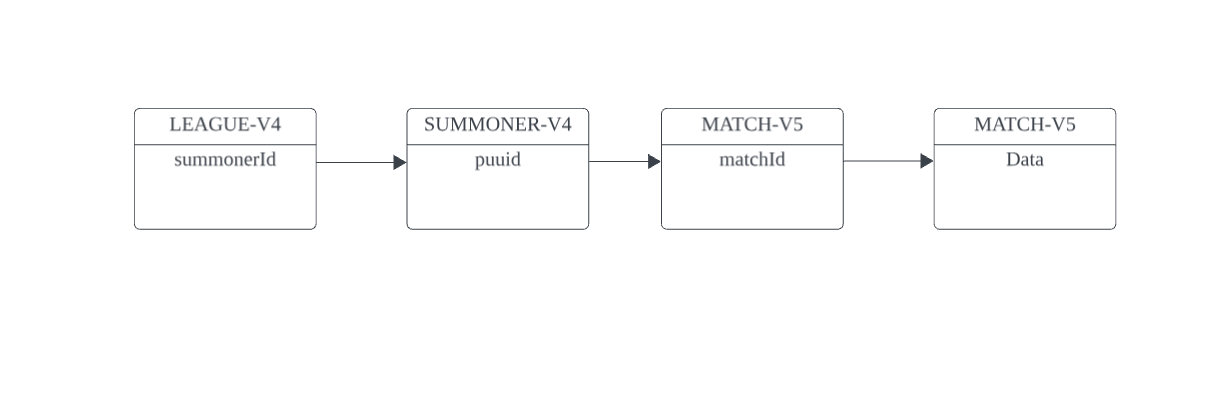

관심있는 데이터는 천상계의 매치 데이터로, 일단 먼저 챌린저 큐의 데이터를 가져와보기로 한다.



In [ ]:
# 솔랭 기준으로 챌린저 데이터를 가져온다.
def league_v4_tier(tier):
    queue = 'RANKED_SOLO_5x5'
    if tier == 'challenger':
        url = f"https://kr.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/{queue}"
    return requests.get(url, headers=request_header)

In [ ]:
# summonerId를 통해 소환사 정보를 가져온다.
def summoners(encryptedSummonerId):
    url = f"https://kr.api.riotgames.com/lol/summoner/v4/summoners/{encryptedSummonerId}"
    return requests.get(url, headers=request_header)

In [ ]:
# 챌린저 데이터 Entries를 가져온다
req_challenger = league_v4_tier('challenger')
# 300명의 챌린저 데이터를 가져온다.
if req_challenger.status_code == 200:
    challenger_data = req_challenger.json()['entries']
    print(f"Total challengers fetched: {len(challenger_data)}")

Total challengers fetched: 300


API에는 Rate Limit이 존재한다. 지금 사용중인 개발 API Key의 경우 1초에 20회, 2분 100회 제한이 있다. 따라서 모든 챌린저의 데이터를 하기엔 한계가 있다고 판단했다. 따라서 랜덤 샘플링을 통해 진행하기로 한다.

In [ ]:
# Rate Limit의 한계가 있으므로 랜덤 샘플링을 해본다. 30명의 데이터를 가져온다.
random_summoners = random.sample(challenger_data, 30)

In [ ]:
# 플레이어들의 puuid와 accountid를 긁어와서 리스트에 저장해준다.
# 만약 오류가 생길경우 오류 메세지를 반환한다.
players_data = []
for item in random_summoners:
    summoner_id = item['summonerId']
    req = summoners(summoner_id)
    if req.status_code == 200:
      summoner_data = req.json()
      puuid = summoner_data['puuid']
      account_id = summoner_data['accountId']
      players_data.append([puuid, account_id])
    else:
      print(f"Failed to fetch data for summoner ID \
      {summoner_id}: {req.status_code}")

In [ ]:
# 추출한 데이터에서 puuid와 account_id로 데이터프레임을 만들어준다
player_df = pd.DataFrame(players_data, columns=['puuid', 'account_id'])

In [ ]:
# 성공적으로 추출이 된것 같다.
player_df

puuid  \
0   jiq32Z9A4HOsw4Y3OkmLugfU7McuMg4wLM8NzzOFUBYKYC...   
1   AZawa0hG9tpml6WVF1zj7u9rOMxIADqb59onXFukH2STMC...   
2   6EJaMZDCxDXJWc39x4pp1Z8HxUm_bbsNCkKsenrT2FlqL9...   
3   DnLP0tcLVteID3d6rXbRlHA7zV7ypBC0d-I8H4-jcuwERK...   
4   KcWrzs8woN_0oAPyr9JqMSlbdYh8psZgCFjCI3d_BOpOVt...   
5   huBMjBiBT4m_OJ3aRjmvr3SZ5alCj4OZ89q27_R-1uyh7O...   
6   Kvo5UbDABL_off782-vuGv2spRj6gSDdzG7zwNJViRhpzS...   
7   KS--n0bv3zi9lJV6wGMCgwTJIfOlXfNiUMprG_K_ZsxjdM...   
8   ICPvPdiMO2JsBibjRRyo01U1vR5P-fjqoxe_TZOZunDN-3...   
9   X5MeT5kyBW26KkTXfzfa-Er7aQSceC-p1wlRHey316vWPw...   
10  l3M7p48tlHLuwnTZJdKOdE_BBy1AKjkLAGmvshxLYxfcxb...   
11  RUValNjEzCZvJs5Iqg3djeXypxNSY1Z1bsJKoOut5EL4a9...   
12  ci79wMlObltabnj9cr2n-8BwpYyfvFs8lvJ35UD5dtOlWP...   
13  qbjza04v0rNCQKMKkBn3Xt-_72cSNug-qOKDvgQ2iqxOlC...   
14  zZhUZO1tjq5CsdCPXc15_EmFYadk49EKaZQpELUaOi1GEh...   
15  vHBUzFZ9kyRjCEMfOxcsXXRgwRr8vSfDq2uKNLHRjTIN08...   
16  NErARE96-lSRlOse_nwqlOmHwqkoLS6Nb7Z4BrLs7F4Zp5...   
17  PmBbmiuz-Hkvmq-oF-CvrbsDmzVzp1YvA1RzB7hRWtMH8k...   
18  7DqyFUWzp_rL9VIWGhZdc2kS4TEpvtecAJ6tkJmOwaY4Pc...   
19  1ZIXv3uDLdDPGlUVpGCpsiuvpZt7u7YDuVotGR95NiXGkB...   
20  rvUZDEfRDHMjokvzRQRSBvodb09-SjALt5fZL3e7Ys22K1...   
21  ZfLKUcEIoi06X4AyhJbpTiA1ABZGR6YA19MHeUNJEpHA3j...   
22  dZmuu3oluhfbBvdKZ0wta8F56c-P1J2PXtyn5wHUqf8G8z...   
23  x4K696AyptZc-lYOs-pxZmjI7AJJBVxV0kh0lhHUs_HbMs...   
24  xvqiqsldqDk3evmiD7Db2LxyZIIVkkvxIjf6A5hQpSw7SO...   
25  lpmwBaiDxD894q8A139kEVMIM0IPNy0J3vzTuE4BL8mL4U...   
26  w219GPhVNyUXXhWuFn1BkT-LoqBpEYmX0pFMP16cy5iSlm...   
27  vEQzp-oQntOibFeUaXy4OUzOMqXTMwDQM3X3cLIgwHKqlq...   
28  KPah3J0nYtnGZTvucHoz0ep77eC1L5lLleuB9SFIoeaRuw...   
29  v5eB3U6YISX5GZxmupXRemFWVjqifndNBbGSQjePmtcejd...   

                                           account_id  
0   ShLdi8rSkDF0bsbge-K_XuJSVwvG8YThbsLU57LbTU6ja1...  
1   PwafasHXeyLxpotD9JZdD4fEFCPBPSqumeSpJp_p9w8XW8...  
2   YRLGQkvbssZzVvSy9ww68GPtz2yoUJei12CWJ02MjWLrdu...  
3   U9xAuetQ06_ODGrRENiBrFY4CQxPKUoAWXOKcog5cWOPyC...  
4   jMs7JUIbTaiu3yEHsjlM0_Ay6vDpxsobGHfNK-K2oksmiq...  
5     6Chhqk4U7ldTV7-iw53SUKgv-AKmP5yjF_muI3X0ZexrQYE  
6   NlPuW0LjZsrOm2AOvtSAmMjYLNgklNR6ipFH9E0vLfoc8T...  
7     Vo1D3F4tdHMVQbDfU7fVsASY_IVFN3NXOcn0QyMV4zyeVkE  
8   4V-o88SrVZl9FLuKtJLRonPyskIMnPCCe4sQhPKfAvQYF8...  
9   M2mo-bwqQEW9KWf2ZlZRHoS2AhLbxXgzkmjjenRkET2-o_...  
10  LUrF3IZaKY3ImPzoJEjJpUYPJlTTK6uolg9TihuIzPBK-0...  
11       HHEr-ljX5mdHVPusmSnrHW5SDafnvBsnMxLXkSNemvcV  
12  928byC4GkSm7Ruz9a5NcMRFFXZes0pSDMIRRv9Cuk_pms-...  
13    OmCLPsQJ-Pta1WV1vwvtnj9mA3n4vtESLpmjJ_1D4ZdLbjM  
14  KBm0AWlLhP_SNfZF-Rmcoi0hRnOyqKsefXRDEmujtGv3H-...  
15  aR5yheEsaCGsCF_R5v9tPWjjSdj0ZwF70FjHM3Y-7m7PUX...  
16  BYL3RJ8EkskvvbU8mHFFHPVFkUFaE2HhVScrvOriOfnO7O...  
17  -wZp4Ug6QW6DnEhTvb5IT0rSusw8sOnlmSea0vowTDarWL...  
18  mTKuUJg2xajU8qHIuMdBXrzXR0djeLj_WXgrKOx8VgrVZB...  
19  Xfc_Lsg16F5Iubyive_CTJAK-p82-a3fLGVndzaxkWE5YY...  
20  Co_pKETyKVLjc0v6HN6J-97M06WOu0cMmWN5RABRCZoJgn...  
21  O5GFNbpOXMzVRYwEFv2V-XSAp2ahky0q2-ygC2V9HZQvJS...  
22       kXNpm5vALnlUt0t3gWZQpGjowTGY0LELBraoK84IaMw1  
23  SnJaYmVTHL9HmgpSpdKpNzdnCwlnQAqaq6AzpnHV--ZhqJ...  
24       q-vdXMEzGsByUyiIDNwrX-pkkDF-gadO04twHmrrALon  
25  cjSmXlFoP3w2vfhwWRbOxGMVD-ynBfHpE7cd9ykKrI865K...  
26  zflPQnk19sbDXICcqwmjERvGPwhU41Qe5YatCyxIf1ZSIV...  
27  zIELiH1KH23YpiBzDAV23oD70fVhgJ3fRZ2dZsf5l_4DYL...  
28  cKupUq0Lj9NB1Lz6AMeM-js4hZBEacjqmVzoC3V9qKFFY6...  
29  eIc96wI1ZnBMP8vMBVp4lneoNaTq2N-OAZiG57EGYGK9e2...

In [ ]:
# puuid를 사용해서 match id를 뽑아낸다.
def extract_match_id(puuid, count, api_key):
    url = f'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count={count}&api_key={api_key}'
    return requests.get(url, headers = request_header)

In [ ]:
# match id가 잘 추출되었는지 확인
match_id = extract_match_id(player_df['puuid'][0], 20, api_key).json()

In [ ]:
match_id

['KR_7105702253',
 'KR_7105597568',
 'KR_7105518383',
 'KR_7105466699',
 'KR_7105401742',
 'KR_7105337388',
 'KR_7105164144',
 'KR_7105117459',
 'KR_7105100273',
 'KR_7105092343',
 'KR_7105056787',
 'KR_7105034693',
 'KR_7104132657',
 'KR_7103986976',
 'KR_7103947185',
 'KR_7103905504',
 'KR_7103857407',
 'KR_7103825140',
 'KR_7103764493',
 'KR_7103716922']

In [ ]:
# match 별 데이터를 추출한다.
def extract_match_info(matchid, api_key):
    url = f'https://asia.api.riotgames.com/lol/match/v5/matches/{matchid}?api_key={api_key}'
    return requests.get(url, headers = request_header)

In [ ]:
# 첫번째 Match_id의 데이터를 추출해본다. 원하는 데이터는 info json안
# participants키에 담겨있는 것으로 보인다.
extract_match_info(match_id[0], api_key).json()

{'metadata': {'dataVersion': '2',
  'matchId': 'KR_7105702253',
  'participants': ['hSWuJ5mJaR4lUaRvFwloQBB0Ks7-k87QEQ2lOPIgQ77w8-odpWOnQCzJ3ygViO7HbZnYPMoNSECneg',
   'ep7_saTFQR4vFngI8-p3le3Ztxa3TbKCGmUPJ2xDQ1BvYY6eZaHM6saIBtYaxK2uD3_H64h6a_aSSA',
   'fU3ttk-wYGHPK0TfCnl1wKjCsCrbCF72oP5G7--t3WlCMGaWAaUlINruzoP0LLtLMfGvAqhBLZmhDQ',
   'jiq32Z9A4HOsw4Y3OkmLugfU7McuMg4wLM8NzzOFUBYKYCC8p0tHqcmwmXuLgDVkgzbTuuCpVdplYQ',
   'C2jyzjRU7tkVX1aDi3YV6B28oPpjVtB_qHbiCjSNbkgWqupfhzitKMWRJ0op9oZNrhlsXuTodUy7bQ',
   'CNAovWHyiRsY4HPvjOJGJYldfyQ-8I8cOjpVh-fhzNP4TUFu_-urugwtNd-uo-Cp_pavzo8oTe78aQ',
   'KyWmSOMbD43DzAqbNIBodFcPFkn-wVhPWUZqcYHFUSLoTUWFC21r7LudOaf9iga3Jq1GJCuqDGSj4Q',
   'w3bHOVpl13dXiMKU9BpKAC4qMTA42A5LpPn8m-gRgjg9Pb-lWiZHJld9IWxp-UkkauryyYcQ9nVwfw',
   'rdASVcboZX2MBvm3qMH8MEpqD2uaojynWkYnuGbj5koGRGEH_aLF5hQypCGFZc_XDkPv_EP8A7Y_Qw',
   'pl88gG60H_ezgNkZf5-XkecxqN9vOOOCaRUDKFjKk-cZnuIwU6yh7803FJFglS9ER0VqwENnu4VgyA']},
 'info': {'endOfGameResult': 'GameComplete',
  'gameCreation': 17180

In [ ]:
# 실제로 그런지 데이터 프레임 화 해서 확인해본다.
match_info_df = pd.DataFrame(extract_match_info(match_id[0], api_key).json()['info']['participants'])

In [ ]:
match_info_df.head(5)

allInPings  assistMePings  assists  baronKills  basicPings  bountyLevel  \
0           0              0        5           0           0            2   
1           0              4        8           0           0            2   
2           0              1        7           0           0            1   
3           0              7       20           0           0            0   
4           0              2       10           0           0            5   

                                          challenges  champExperience  \
0  {'12AssistStreakCount': 0, 'InfernalScalePicku...            10064   
1  {'12AssistStreakCount': 0, 'InfernalScalePicku...            11846   
2  {'12AssistStreakCount': 0, 'InfernalScalePicku...            11795   
3  {'12AssistStreakCount': 1, 'InfernalScalePicku...             8954   
4  {'12AssistStreakCount': 0, 'InfernalScalePicku...            10192   

   champLevel  championId  ... turretKills  turretTakedowns  turretsLost  \
0          13         154  ...           0                1            2   
1          14         120  ...           1                1            2   
2          14         268  ...           2                2            2   
3          12         432  ...           0                1            2   
4          13         202  ...           1                1            2   

   unrealKills  visionClearedPings  visionScore  visionWardsBoughtInGame  \
0            0                   0           19                        2   
1            0                   0            7                        1   
2            0                   0           18                        3   
3            0                   0           79                       11   
4            0                   0           17                        2   

   wardsKilled  wardsPlaced   win  
0            0            6  True  
1            1            2  True  
2            4            9  True  
3            9           37  True  
4            3            9  True  

[5 rows x 130 columns]

In [ ]:
# 추출이 잘 되는것이 확인 되므로 매치 데이터를 긁어오기로 한다.
# 1. puuid를 통해 한 플레이어의 최근 20매치 id를 찾는다.
# 2. 리스트에 넣어놓는다. 리스트에는 30명 각각의 20매치씩 총 600개의 매치가 들어가야한다.
match_id_ls = []
for id in player_df['puuid']:
  req_match_id = extract_match_id(id, 20, api_key)
  if req_match_id.status_code == 200:
    match_id = req_match_id.json()
    match_id_ls.append(match_id)
  else:
    print(f"Failed to fetch data for match_id {id}: {req_match_id.status_code}")

In [ ]:
# Counter 라이브러리를 통해 match_id 중복값을 없앤다
from collections import Counter

combined_list = [item for sublist in match_id_ls for item in sublist]

counts = Counter(combined_list)

unique_ids = [item for item, count in counts.items() if count == 1]

In [ ]:
# 중복되는 매치 id 600-453 = 147개가 사라진것으로 확인된다.
len(unique_ids)

453

In [ ]:
# Dictionary를 만들어 match_id 데이터 50개씩 담긴 unique_id 그룹 10개로 나눠준다.
# 마지막 그룹에는 3개의 match_id 데이터가 담겨있다.
unique_dict = {}
slice_size = 50

for i in range(0, len(unique_ids), slice_size):
  slice_number = i // slice_size + 1
  end_index = i + slice_size if (i + slice_size) < len(unique_ids) else \
              len(unique_ids)
  unique_dict[f'unique_id_{slice_number}'] = unique_ids[i:end_index]

match id가 담겨있는 dictionary를 for loop을 통해 match_id 453개의 게임 데이터를 긁어온다.  time 라이브러리를 통해 시간을 줘 Rate Limit을 피해간다.

In [ ]:
# 매치 데이터를 가져오기 위해 빈 데이터 프레임을 만들어준다.
match_df = pd.DataFrame()

In [ ]:
# 수집된 매치의 개수를 확인하기 위한 Flag
flag = 0

# Dictionary를 돌며 매치 데이터를 수집 후 데이터프레임에 추가한다.
for unique_id, match_ids in unique_dict.items():
  for match_id in match_ids:
    req_match_info = extract_match_info(match_id, api_key)
    if req_match_info.status_code == 200:
      match_info = req_match_info.json()
      match_info_df = pd.DataFrame(match_info['info']['participants'])
      match_df = pd.concat([match_df, match_info_df], axis = 0, join = 'outer')
      flag += 1
      sleep(3.5)
    else:
      print(f"Failed to fetch data for match_id {match_id}: \
            {req_match_info.status_code}")
print(f'수집된 매치의 개수는 {flag}개 입니다')

In [ ]:
# 매치 데이터프레임의 shape을 확인한다.
match_df.shape

(4752, 130)

## 데이터 전처리

결측치를 처리하고 필요없는 컬럼들을 정리한다. EDA와 모델링하기 좋은 방향으로 데이터셋을 전처리한다.

In [ ]:
# 빈칸을 결측치로 처리해준다.
match_df.replace('', np.nan, inplace=True)

In [ ]:
# 453개의 Match 데이터 이므로 453*10 = 4530개의 데이터가 있어야 한다.
# 4752개가 확인되므로 match_id 이외에서 중복값이나 Participant가 더 많은 경우가 있는 것 같다.
# 이벤트 매치일수도 있다는 가능성을 산정하고 먼저 결측치를 확인해본다.
null_count = match_df.isna().sum()
non_zero = null_count[null_count > 0]

In [ ]:
# 결측치가 다음과 같이 확인된다.
non_zero

summonerName    562
teamPosition    654
dtype: int64

summonerName 컬럼은 이전 riotIdGameName을 표시하는 컬럼으로 추측하였다.(없을경우 na)

사용하지 않는 컬럼에 summonerName을 포함시켜 drop시킬 것이기 때문에 넘어가기로 함.

teamPosition이 na값인 매치는 칼바람 나락, 아레나 게임 모드이므로 제외한다.

EarlySurrender(이른 항복) 게임, 다시하기 게임은 값이 튈 수 있으므로 제외한다.



In [ ]:
# 일찍 항복한 게임 또는 다시하기 게임은 제외한다.
df_cleaned = match_df[match_df['gameEndedInEarlySurrender'] == False]

# 'teamPosition'이 na값이면 이벤트 매치거나 칼바람이므로 제외한다.
df_cleaned = df_cleaned[df_cleaned['teamPosition'].notna()]

# 데이터프레임 확인
df_cleaned.head()

allInPings  assistMePings  assists  baronKills  basicPings  bountyLevel  \
0           0              0        5           0           0            2   
1           0              4        8           0           0            2   
2           0              1        7           0           0            1   
3           0              7       20           0           0            0   
4           0              2       10           0           0            5   

                                          challenges  champExperience  \
0  {'12AssistStreakCount': 0, 'InfernalScalePicku...            10064   
1  {'12AssistStreakCount': 0, 'InfernalScalePicku...            11846   
2  {'12AssistStreakCount': 0, 'InfernalScalePicku...            11795   
3  {'12AssistStreakCount': 1, 'InfernalScalePicku...             8954   
4  {'12AssistStreakCount': 0, 'InfernalScalePicku...            10192   

   champLevel  championId  ... turretKills  turretTakedowns  turretsLost  \
0          13         154  ...           0                1            2   
1          14         120  ...           1                1            2   
2          14         268  ...           2                2            2   
3          12         432  ...           0                1            2   
4          13         202  ...           1                1            2   

   unrealKills  visionClearedPings  visionScore  visionWardsBoughtInGame  \
0            0                   0           19                        2   
1            0                   0            7                        1   
2            0                   0           18                        3   
3            0                   0           79                       11   
4            0                   0           17                        2   

   wardsKilled  wardsPlaced   win  
0            0            6  True  
1            1            2  True  
2            4            9  True  
3            9           37  True  
4            3            9  True  

[5 rows x 130 columns]

In [ ]:
# df_cleaned의 shape을 확인
df_cleaned.shape

(4070, 130)

In [ ]:
# Drop할 컬럼을 지정한다.
# 이 컬럼들은 분석하고자 할때 무관한 데이터거나, 너무 디테일한 정보거나, 중복되는 데이터라고 판단하여
# 제외하였다.
columns_to_drop = [
    'challenges', 'riotIdGameName', 'riotIdTagline', 'summonerName',
    'summonerLevel', 'playerAugment1', 'playerAugment2', 'playerAugment3',
    'playerAugment4', 'doubleKills', 'item0', 'item1', 'item2', 'item3',
    'item4', 'item5', 'item6', 'missions', 'perks', 'placement',
    'playerSubteamId', 'profileIcon', 'nexusKills', 'nexusLost',
    'nexusTakedowns', 'spell1Casts', 'spell2Casts', 'spell3Casts',
    'spell4Casts', 'subteamPlacement', 'summoner1Casts', 'summoner1Id',
    'summoner2Casts', 'summoner2Id', 'gameEndedInEarlySurrender',
    'gameEndedInSurrender', 'teamEarlySurrendered', 'individualPosition',
    'teamId', 'magicDamageDealt', 'magicDamageDealtToChampions',
    'magicDamageTaken', 'physicalDamageDealt', 'physicalDamageDealtToChampions',
    'physicalDamageTaken', 'goldSpent', 'pentaKills', 'quadraKills',
    'tripleKills', 'role', 'summonerId', 'eligibleForProgression',
    'unrealKills', 'lane', 'kills', 'deaths', 'assists', 'largestKillingSpree',
    'largestMultiKill', 'turretTakedowns'
]

In [ ]:
# Drop the specified columns
df_reduced = df_cleaned.drop(columns=columns_to_drop)
# Show the updated DataFrame
df_reduced.head(), df_reduced.shape

(   allInPings  assistMePings  baronKills  basicPings  bountyLevel  \
 0           0              0           0           0            2   
 1           0              4           0           0            2   
 2           0              1           0           0            1   
 3           0              7           0           0            0   
 4           0              2           0           0            5   
 
    champExperience  champLevel  championId championName  championTransform  \
 0            10064          13         154          Zac                  0   
 1            11846          14         120      Hecarim                  0   
 2            11795          14         268         Azir                  0   
 3             8954          12         432         Bard                  0   
 4            10192          13         202         Jhin                  0   
 
    ...  trueDamageDealtToChampions  trueDamageTaken  turretKills  turretsLost  \
 0  ...             

ping과 관련된 데이터가 13항목이 있다.

개인별 사용 방법이 다른 ping을 각각 분석하는 것이 애매하다고 판단하여 ping 빈도를 알아보기위한 ping 데이터를 합산한 totalPing 컬럼으로 만들고 ping 컬럼들을 지운다.

In [ ]:
# 핑 데이터를 합산해 totalPing으로 합친다.
ping_columns = [
    'allInPings', 'assistMePings', 'basicPings', 'commandPings', 'dangerPings',
    'enemyMissingPings', 'enemyVisionPings', 'getBackPings', 'holdPings',
    'needVisionPings', 'onMyWayPings', 'pushPings', 'visionClearedPings'
]

# Compute the total pings by summing the specified columns
df_reduced['totalPing'] = df_reduced[ping_columns].sum(axis=1)

INFO:pycodestyle:11:1: W391 blank line at end of file


In [ ]:
# 확인
df_reduced.head(5)

allInPings  assistMePings  baronKills  basicPings  bountyLevel  \
0           0              0           0           0            2   
1           0              4           0           0            2   
2           0              1           0           0            1   
3           0              7           0           0            0   
4           0              2           0           0            5   

   champExperience  champLevel  championId championName  championTransform  \
0            10064          13         154          Zac                  0   
1            11846          14         120      Hecarim                  0   
2            11795          14         268         Azir                  0   
3             8954          12         432         Bard                  0   
4            10192          13         202         Jhin                  0   

   ...  trueDamageTaken  turretKills  turretsLost  visionClearedPings  \
0  ...             2588            0            2                   0   
1  ...             1365            1            2                   0   
2  ...              683            2            2                   0   
3  ...              853            0            2                   0   
4  ...             1347            1            2                   0   

   visionScore  visionWardsBoughtInGame  wardsKilled  wardsPlaced   win  \
0           19                        2            0            6  True   
1            7                        1            1            2  True   
2           18                        3            4            9  True   
3           79                       11            9           37  True   
4           17                        2            3            9  True   

   totalPing  
0         17  
1         29  
2         25  
3         72  
4         15  

[5 rows x 71 columns]

In [ ]:
# 합산이 잘 된것으로 보이므로 핑에 관련한 컬럼들을 Drop한다.
# Drop the specified columns
final_df = df_reduced.drop(columns=ping_columns)
final_df.shape

NameError: name 'df_reduced' is not defined

데이터 프레임 데이터 타입 확인


In [ ]:
# int, Object, Boolean값이 있는것으로 확인된다. 따라서 인코딩을 진행한다.
final_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool')], dtype=object)

Boolean 인코딩

In [ ]:
# 먼저 Boolean값이 담겨있는 컬럼의 리스트를 만든다.
boolean_list = final_df.columns[final_df.dtypes == 'bool'].tolist()

In [ ]:
# List안에 담겨있는 값을 0과 1로 mapping한다. (True면 1, False면 0)
for col in boolean_list:
    final_df[col] = final_df[col].map({True: 1, False: 0})

In [ ]:
# 확인
final_df.head()

baronKills  bountyLevel  champExperience  champLevel  championId  \
0           0            2            10064          13         154   
1           0            2            11846          14         120   
2           0            1            11795          14         268   
3           0            0             8954          12         432   
4           0            5            10192          13         202   

  championName  championTransform  consumablesPurchased  \
0          Zac                  0                     3   
1      Hecarim                  0                     2   
2         Azir                  0                     5   
3         Bard                  0                    13   
4         Jhin                  0                     3   

   damageDealtToBuildings  damageDealtToObjectives  ...  \
0                    2695                     2695  ...   
1                    2014                    20445  ...   
2                    3304                     3304  ...   
3                       0                        0  ...   
4                    1643                     1643  ...   

   trueDamageDealtToChampions  trueDamageTaken  turretKills  turretsLost  \
0                         226             2588            0            2   
1                         412             1365            1            2   
2                          75              683            2            2   
3                        1006              853            0            2   
4                         482             1347            1            2   

   visionScore  visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  \
0           19                        2            0            6    1   
1            7                        1            1            2    1   
2           18                        3            4            9    1   
3           79                       11            9           37    1   
4           17                        2            3            9    1   

   totalPing  
0         17  
1         29  
2         25  
3         72  
4         15  

[5 rows x 58 columns]

object 인코딩

In [ ]:
# object가 담겨있는 컬럼의 리스트를 만든다
object_list = final_df.columns[final_df.dtypes == 'O'].tolist()

In [ ]:
object_list

['championName', 'puuid', 'teamPosition']

In [ ]:
# 여기서 championName은 너무 많아서 인코딩을 하지 않고, puuid는 유저 고유 식별번호이므로 제외한다.
# teamPosition의 데이터 종류를 확인한다.
final_df['teamPosition'].unique()

array(['TOP', 'JUNGLE', 'MIDDLE', 'UTILITY', 'BOTTOM'], dtype=object)

In [ ]:
# One-Hot Encoding 수행
final_df = pd.get_dummies(final_df, columns=['teamPosition'])

# 변환된 데이터 확인
final_df.head()

baronKills  bountyLevel  champExperience  champLevel  championId  \
0           0            2            10064          13         154   
1           0            2            11846          14         120   
2           0            1            11795          14         268   
3           0            0             8954          12         432   
4           0            5            10192          13         202   

  championName  championTransform  consumablesPurchased  \
0          Zac                  0                     3   
1      Hecarim                  0                     2   
2         Azir                  0                     5   
3         Bard                  0                    13   
4         Jhin                  0                     3   

   damageDealtToBuildings  damageDealtToObjectives  ...  \
0                    2695                     2695  ...   
1                    2014                    20445  ...   
2                    3304                     3304  ...   
3                       0                        0  ...   
4                    1643                     1643  ...   

   visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                        2            0            6    1         17   
1                        1            1            2    1         29   
2                        3            4            9    1         25   
3                       11            9           37    1         72   
4                        2            3            9    1         15   

   teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                False                False                False   
1                False                 True                False   
2                False                False                 True   
3                False                False                False   
4                 True                False                False   

   teamPosition_TOP  teamPosition_UTILITY  
0              True                 False  
1             False                 False  
2             False                 False  
3             False                  True  
4             False                 False  

[5 rows x 62 columns]

In [ ]:
# True/False 값으로 반환되었으므로 다시 인코딩을 진행한다.
encoding_list = ['teamPosition_BOTTOM', 'teamPosition_JUNGLE',
                 'teamPosition_MIDDLE', 'teamPosition_TOP',
                 'teamPosition_UTILITY']
for col in encoding_list:
    final_df[col] = final_df[col].map({True: 1, False: 0})

In [ ]:
# 변환된 데이터 확인
final_df.head()

baronKills  bountyLevel  champExperience  champLevel  championId  \
0           0            2            10064          13         154   
1           0            2            11846          14         120   
2           0            1            11795          14         268   
3           0            0             8954          12         432   
4           0            5            10192          13         202   

  championName  championTransform  consumablesPurchased  \
0          Zac                  0                     3   
1      Hecarim                  0                     2   
2         Azir                  0                     5   
3         Bard                  0                    13   
4         Jhin                  0                     3   

   damageDealtToBuildings  damageDealtToObjectives  ...  \
0                    2695                     2695  ...   
1                    2014                    20445  ...   
2                    3304                     3304  ...   
3                       0                        0  ...   
4                    1643                     1643  ...   

   visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                        2            0            6    1         17   
1                        1            1            2    1         29   
2                        3            4            9    1         25   
3                       11            9           37    1         72   
4                        2            3            9    1         15   

   teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                    0                    0                    0   
1                    0                    1                    0   
2                    0                    0                    1   
3                    0                    0                    0   
4                    1                    0                    0   

   teamPosition_TOP  teamPosition_UTILITY  
0                 1                     0  
1                 0                     0  
2                 0                     0  
3                 0                     1  
4                 0                     0  

[5 rows x 62 columns]

In [ ]:
# Csv파일로 저장한다.
final_df.to_csv("Data/cleaned_data_riot_api.csv", index = False)

NameError: name 'final_df' is not defined

### 그랜드마스터 ,마스터 매치 데이터 합치기

같은 프로세스를 통해서 그랜드 마스터 데이터와 마스터 큐 매치 데이터를 수집 후 저장한다. 그 후 데이터를 합쳐서 분석하기로 결정했다.

In [ ]:
# 챌린저 큐
cg_df = pd.read_csv('Data/cleaned_data_riot_api.csv')
# 그랜드 마스터 큐
gm_df = pd.read_csv('Data/cleaned_data_riot_api_grandmaster.csv')
# 마스터 큐
m_df = pd.read_csv('Data/cleaned_data_riot_api_master.csv')

In [ ]:
cg_df

baronKills  bountyLevel  champExperience  champLevel  championId  \
0              0            2            10064          13         154   
1              0            2            11846          14         120   
2              0            1            11795          14         268   
3              0            0             8954          12         432   
4              0            5            10192          13         202   
...          ...          ...              ...         ...         ...   
4065           0            0            14208          15           4   
4066           1            5            12697          14         200   
4067           0            2            15002          16         910   
4068           0            7            14991          16         221   
4069           0            1             8350          11         412   

     championName  championTransform  consumablesPurchased  \
0             Zac                  0                     3   
1         Hecarim                  0                     2   
2            Azir                  0                     5   
3            Bard                  0                    13   
4            Jhin                  0                     3   
...           ...                ...                   ...   
4065  TwistedFate                  0                     2   
4066      Belveth                  0                    11   
4067         Hwei                  0                    10   
4068         Zeri                  0                     3   
4069       Thresh                  0                    16   

      damageDealtToBuildings  damageDealtToObjectives  ...  \
0                       2695                     2695  ...   
1                       2014                    20445  ...   
2                       3304                     3304  ...   
3                          0                        0  ...   
4                       1643                     1643  ...   
...                      ...                      ...  ...   
4065                    6854                    12582  ...   
4066                    3554                    34197  ...   
4067                    9702                    12917  ...   
4068                    8389                    15452  ...   
4069                     123                      745  ...   

      visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                           2            0            6    1         17   
1                           1            1            2    1         29   
2                           3            4            9    1         25   
3                          11            9           37    1         72   
4                           2            3            9    1         15   
...                       ...          ...          ...  ...        ...   
4065                        1            2            9    1         43   
4066                       10            8            9    1        149   
4067                        7            7           14    1         90   
4068                        1           10            9    1         27   
4069                       14            8           41    1         29   

      teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                       0                    0                    0   
1                       0                    1                    0   
2                       0                    0                    1   
3                       0                    0                    0   
4                       1                    0                    0   
...                   ...                  ...                  ...   
4065                    0                    0                    0   
4066                    0                    1                    0   
4067                    0                    0                    1   
4068            

In [ ]:
gm_df

baronKills  bountyLevel  champExperience  champLevel  championId  \
0              0            1             7170          10          72   
1              0            0             4532           8         120   
2              0            0             7162          10         910   
3              0            0             5324           9         221   
4              0            0             3414           7         350   
...          ...          ...              ...         ...         ...   
3945           0            0            10704          13          39   
3946           0            0             8152          11          76   
3947           0            0             8601          12         516   
3948           0            1             7548          11          51   
3949           0            0             5440           9         497   

     championName  championTransform  consumablesPurchased  \
0         Skarner                  0                     3   
1         Hecarim                  0                     4   
2            Hwei                  0                     4   
3            Zeri                  0                     1   
4           Yuumi                  0                     4   
...           ...                ...                   ...   
3945       Irelia                  0                     5   
3946      Nidalee                  0                     0   
3947         Ornn                  0                     3   
3948      Caitlyn                  0                     5   
3949        Rakan                  0                     7   

      damageDealtToBuildings  damageDealtToObjectives  ...  \
0                         50                       50  ...   
1                          0                     3094  ...   
2                         79                       79  ...   
3                        187                      187  ...   
4                          0                        0  ...   
...                      ...                      ...  ...   
3945                    2019                     2019  ...   
3946                       0                        0  ...   
3947                       0                        0  ...   
3948                     525                      525  ...   
3949                       0                        0  ...   

      visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                           1            2            6    0         16   
1                           3            4            3    0         38   
2                           2            2            5    0         18   
3                           0            4            5    0          2   
4                           2            1           19    0         51   
...                       ...          ...          ...  ...        ...   
3945                        3            1            8    0         25   
3946                        0            5            4    0         63   
3947                        2            0            6    0         28   
3948                        2            3            6    0         17   
3949                        5            5           24    0         13   

      teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                       0                    0                    0   
1                       0                    1                    0   
2                       0                    0                    1   
3                       1                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
3945                    0                    0                    0   
3946                    0                    1                    0   
3947                    0                    0                    1   
3948            

In [ ]:
m_df

baronKills  bountyLevel  champExperience  champLevel  championId  \
0              0            0             8616          12         897   
1              0            0             7155          10           5   
2              0            0             8465          11         134   
3              0            0             7336          11         901   
4              0            0             5805           9         147   
...          ...          ...              ...         ...         ...   
4455           0            0            13642          15          58   
4456           0            7            12512          14          60   
4457           1            0            12442          14          18   
4458           0           10            11691          14         221   
4459           0            2            11163          13         350   

     championName  championTransform  consumablesPurchased  \
0          KSante                  0                     1   
1         XinZhao                  0                     4   
2          Syndra                  0                     3   
3         Smolder                  0                     2   
4       Seraphine                  0                     6   
...           ...                ...                   ...   
4455     Renekton                  0                     4   
4456        Elise                  0                     5   
4457     Tristana                  0                     6   
4458         Zeri                  0                     4   
4459        Yuumi                  0                    10   

      damageDealtToBuildings  damageDealtToObjectives  ...  \
0                        940                      940  ...   
1                          0                     9053  ...   
2                         28                      548  ...   
3                       2069                     2683  ...   
4                       1035                     1719  ...   
...                      ...                      ...  ...   
4455                    3066                     3066  ...   
4456                    4089                    19809  ...   
4457                    6797                    15486  ...   
4458                   13507                    18473  ...   
4459                    1055                     1320  ...   

      visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                           0            0            6    0          5   
1                           3            1            8    0         15   
2                           1            1            7    0         10   
3                           1            1            7    0         15   
4                           3            5           22    0         24   
...                       ...          ...          ...  ...        ...   
4455                        3            2            9    1          0   
4456                        4           10            5    1         88   
4457                        5            9           12    1         22   
4458                        3           12           11    1        109   
4459                        8            1           29    1        134   

      teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                       0                    0                    0   
1                       0                    1                    0   
2                       0                    0                    1   
3                       1                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
4455                    0                    0                    0   
4456                    0                    1                    0   
4457                    0                    0                    1   
4458            

In [ ]:
# 그랜드 마스터와 마스터엔 플레이어 증강 5, 6 데이터가 남아있는 것으로 보인다.
# 이는 아레나 게임 모드와 상관 있으므로 제거해준다.
m_df.drop(columns=['playerAugment5', 'playerAugment6'], inplace=True)
gm_df.drop(columns=['playerAugment5', 'playerAugment6'], inplace=True)

In [ ]:
# 데이터를 같이 Merge 해준다.
df = pd.concat([cg_df, gm_df, m_df], axis = 0, join = 'outer')

In [ ]:
# Csv 파일로 만들어 저장한다.
df.to_csv('total_cleaned_data_riot_api.csv', index=False)

## 데이터 분석

In [ ]:
# 데이터를 불러온다
df = pd.read_csv('Data/total_cleaned_data_riot_api.csv')
df

baronKills  bountyLevel  champExperience  champLevel  championId  \
0               0            2            10064          13         154   
1               0            2            11846          14         120   
2               0            1            11795          14         268   
3               0            0             8954          12         432   
4               0            5            10192          13         202   
...           ...          ...              ...         ...         ...   
12475           0            0            13642          15          58   
12476           0            7            12512          14          60   
12477           1            0            12442          14          18   
12478           0           10            11691          14         221   
12479           0            2            11163          13         350   

      championName  championTransform  consumablesPurchased  \
0              Zac                  0                     3   
1          Hecarim                  0                     2   
2             Azir                  0                     5   
3             Bard                  0                    13   
4             Jhin                  0                     3   
...            ...                ...                   ...   
12475     Renekton                  0                     4   
12476        Elise                  0                     5   
12477     Tristana                  0                     6   
12478         Zeri                  0                     4   
12479        Yuumi                  0                    10   

       damageDealtToBuildings  damageDealtToObjectives  ...  \
0                        2695                     2695  ...   
1                        2014                    20445  ...   
2                        3304                     3304  ...   
3                           0                        0  ...   
4                        1643                     1643  ...   
...                       ...                      ...  ...   
12475                    3066                     3066  ...   
12476                    4089                    19809  ...   
12477                    6797                    15486  ...   
12478                   13507                    18473  ...   
12479                    1055                     1320  ...   

       visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                            2            0            6    1         17   
1                            1            1            2    1         29   
2                            3            4            9    1         25   
3                           11            9           37    1         72   
4                            2            3            9    1         15   
...                        ...          ...          ...  ...        ...   
12475                        3            2            9    1          0   
12476                        4           10            5    1         88   
12477                        5            9           12    1         22   
12478                        3           12           11    1        109   
12479                        8            1           29    1        134   

       teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                        0                    0                    0   
1                        0                    1                    0   
2                        0                    0                    1   
3                        0                    0                    0   
4                        1                    0                    0   
...                    ...                  ...                  ...   
12475                    0                    0                    0   
12476                    0                    1                    0   
12477                    0     

In [ ]:
# 요인 분석에 상관없을것 같은 컬럼은 제외하기로 하였다.
df.drop(['championId', 'championName', 'championTransform',
         'sightWardsBoughtInGame', 'turretsLost', 'participantId',
         'puuid'], axis=1, inplace=True)

In [ ]:
# 컬럼 확인
df.columns

Index(['baronKills', 'bountyLevel', 'champExperience', 'champLevel',
       'consumablesPurchased', 'damageDealtToBuildings',
       'damageDealtToObjectives', 'damageDealtToTurrets',
       'damageSelfMitigated', 'detectorWardsPlaced', 'dragonKills',
       'firstBloodAssist', 'firstBloodKill', 'firstTowerAssist',
       'firstTowerKill', 'goldEarned', 'inhibitorKills', 'inhibitorTakedowns',
       'inhibitorsLost', 'itemsPurchased', 'killingSprees',
       'largestCriticalStrike', 'longestTimeSpentLiving',
       'neutralMinionsKilled', 'objectivesStolen', 'objectivesStolenAssists',
       'timeCCingOthers', 'timePlayed', 'totalAllyJungleMinionsKilled',
       'totalDamageDealt', 'totalDamageDealtToChampions',
       'totalDamageShieldedOnTeammates', 'totalDamageTaken',
       'totalEnemyJungleMinionsKilled', 'totalHeal', 'totalHealsOnTeammates',
       'totalMinionsKilled', 'totalTimeCCDealt', 'totalTimeSpentDead',
       'totalUnitsHealed', 'trueDamageDealt', 'trueDamageDealtToCham

In [ ]:
# 컬럼 개수 확인
len(df.columns)

62

### **데이터 EDA**
#### **주제: 게임 데이터 중 게임 승리에 가장 크게 기여하는 요인은 어떤 것일까?**



#### **가설: 현재 메타 챔피언의 픽(주로 미드, 탑, 원딜)을 많이 한 팀이 승리할 확률이 높을 것이다.**

In [ ]:
# 천상계 데이터를 불러온다.
# python 코드 포메터 라이브러리입니다. 필요하신분은 한번만 설치후 '%%pycodestyle'을 셀 위에 복붙하고 쓰시면 됩니다!
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic
import warnings
warnings.filterwarnings('ignore')
riot_data = pd.read_csv('/content/drive/MyDrive/total_cleaned_data_riot_api.csv')
df_temp = riot_data.copy()

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [ ]:
# participant를 기준으로 win을 보면 participantId가 1~5로 된 팀이 1,
# 6~10이 win이 0인 것을 보아 서로 다른 팀인 것을 알 수 있음.
%pycodestyle_on
df[['championId','championName','participantId','win']].head(10)

championId championName  participantId  win
0         154          Zac              1    1
1         120      Hecarim              2    1
2         268         Azir              3    1
3         432         Bard              4    1
4         202         Jhin              5    1
5          19      Warwick              6    0
6          30      Karthus              7    0
7         777         Yone              8    0
8         110        Varus              9    0
9         164      Camille             10    0

INFO:pycodestyle:4:17: E231 missing whitespace after ','
INFO:pycodestyle:4:32: E231 missing whitespace after ','
INFO:pycodestyle:4:48: E231 missing whitespace after ','


In [ ]:
# 팀 별로 묶어서 데이터프레임을 반환하기
ls = []
for i in range(0, len(df), 5):
    ls.append(df_temp.iloc[i:i+5].sum())
team_df = pd.DataFrame(ls)
temp = team_df.copy()

In [ ]:
#데이터 프레임은 잘 나왔지만 championName은 구분되지 않고 다 붙은 모습을 볼 수 있다. 떼어주자.
team_df.head(5)

baronKills  bountyLevel  champExperience  champLevel  championId  \
0           0           10            52851          66        1176   
1           0            0            45444          60        1100   
2           2            0            77171          79         669   
3           0           11            75829          79        1245   
4           0            3            76112          79         445   

                          championName  championTransform  \
0               ZacHecarimAzirBardJhin                  0   
1       WarwickKarthusYoneVarusCamille                  0   
2        RenektonTaliyahYasuoJhinLeona                  0   
3     KSanteNidaleeCorkiDravenNautilus                  0   
4  SkarnerNocturneOriannaKaisaNautilus                  0   

   consumablesPurchased  damageDealtToBuildings  damageDealtToObjectives  ...  \
0                    26                    9656                    28087  ...   
1                    16                    6340                    33676  ...   
2                    34                   19853                   106112  ...   
3                    50                   21433                    59540  ...   
4                    34                    4837                    28546  ...   

   visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                       19           17           63    5        158   
1                        9           22           55    0        187   
2                       27           48           95    0        614   
3                       41           46           94    5        543   
4                       25           41           77    0        241   

   teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                    1                    1                    1   
1                    1                    1                    1   
2                    1                    1                    1   
3                    1                    1                    1   
4                    1                    1                    1   

   teamPosition_TOP  teamPosition_UTILITY  
0                 1                     1  
1                 1                     1  
2                 1                     1  
3                 1                     1  
4                 1                     1  

[5 rows x 62 columns]

In [ ]:
# 정규표현식을 이용하여 챔피언 이름 구분하여 뗴주기.
# 대문자가 첫글자고, 다음 글자는 무조건 소문자로 나오는 형식으로 챔피언 이름은 구성이 되어있다.
import re
def split_champ_names(champstring):
    splited_champ = re.findall(r'[A-Z][a-z]*', champstring)
    return ',' .join(splited_champ)

대문자가 첫글자고, 다음 글자는 무조건 소문자로 나오는 형식으로 챔피언 이름은 구성이 되어있다.

In [ ]:
# 추출된 리스트를 보고 이상하게 추출된 챔피언 걸러주기(1)
champions = pd.Series(temp['championName'].apply(split_champ_names))
champions.to_list()

['Zac,Hecarim,Azir,Bard,Jhin',
 'Warwick,Karthus,Yone,Varus,Camille',
 'Renekton,Taliyah,Yasuo,Jhin,Leona',
 'K,Sante,Nidalee,Corki,Draven,Nautilus',
 'Skarner,Nocturne,Orianna,Kaisa,Nautilus',
 'Renekton,Taliyah,Twisted,Fate,Jhin,Rell',
 'Monkey,King,Nidalee,Tristana,Varus,Neeko',
 'K,Sante,Lillia,Jayce,Kalista,Nautilus',
 'Twisted,Fate,Ekko,Jayce,Miss,Fortune,Alistar',
 'Yasuo,Taliyah,Tristana,Zeri,Rakan',
 'Udyr,Vi,Tristana,Smolder,Nautilus',
 'Skarner,Lee,Sin,Sylas,Twisted,Fate,Bard',
 'Jax,Lillia,Yone,Jhin,Bard',
 'K,Sante,Taliyah,Corki,Varus,Camille',
 'Aatrox,Brand,Tristana,Zeri,Rakan',
 'Kled,Viego,Lissandra,Varus,Alistar',
 'Jax,Taliyah,Tristana,Jhin,Nautilus',
 'Vayne,Lee,Sin,Akali,Smolder,Milio',
 'Twisted,Fate,Lee,Sin,Swain,Ashe,Braum',
 'Poppy,Nidalee,Sett,Jinx,Morgana',
 'Rengar,Taliyah,Tristana,Ashe,Nautilus',
 'Warwick,Viego,Swain,Corki,Rell',
 'Zac,Nidalee,Tristana,Twitch,Rakan',
 'Fiora,Rengar,Yasuo,Kaisa,Nautilus',
 'Twisted,Fate,Talon,Viktor,Ezreal,Karma',
 'Jax,Tal

그러나 오공(MonkeyKing),트페(TwistedFate),리신(LeeSin),크산테(KSante),아우렐리온솔(AurelionSol),신짜오(XinZhao), 코그모(KogMaw),문도박사(DrMundo),렉사이(RekSai),탐켄치(TahmKench),피들스틱(FiddleSticks),미스포츈(MissFortune) 정도의 챔피언은 이름의 중간에 대문자가 끼어있어서 분리되어 이상하게 추출되었다.

In [ ]:
# 추출된 리스트를 보고 이상하게 추출된 챔피언 걸러주기(2)
# 챔피언의 이름이 분리되어 챔피언의 이름으로 제대로 만들기 위한 처리 과정
# 하나의 챔피언 이름이지만 정규표현식에 의해 분리된 챔피언
cap_names = ['Monkey', 'King', 'Twisted', 'Fate', 'Lee', 'Sin', 'K', 'Sante',
             'Aurelion', 'Sol', 'Xin', 'Zhao', 'Kog', 'Maw', 'Dr', 'Mundo',
             'Rek', 'Sai', 'Tahm', 'Kench', 'Fiddle', 'Sticks', 'Miss',
             'Fortune']


# 패턴을 찾아 대체하는 함수 정의
def combine_names(champion_name, names):
    # 패턴을 찾아서 이름을 결합하는 함수
    def replace_name(match):
        name = match.group()
        if name in names and names.index(name) % 2 == 0:  # 인덱스가 짝수일 때(첫 번째 단어)
            return name + names[names.index(name) + 1]
        else:
            return name
    # 정규 표현식을 사용하여 패턴을 찾고, 찾은 패턴을 대체함
    replaced_text = re.sub(r'\b(?:' + '|'.join(names) + r')\b', replace_name, champion_name)

    return replaced_text

# Series에 apply
champions = champions.apply(lambda x: combine_names(x, cap_names))
print(champions)

0                        Zac,Hecarim,Azir,Bard,Jhin
1                Warwick,Karthus,Yone,Varus,Camille
2                 Renekton,Taliyah,Yasuo,Jhin,Leona
3        KSante,Sante,Nidalee,Corki,Draven,Nautilus
4           Skarner,Nocturne,Orianna,Kaisa,Nautilus
                           ...                     
2491          Sejuani,Kindred,Lissandra,Ashe,Thresh
2492    TwistedFate,Fate,Hecarim,Hwei,Zeri,Nautilus
2493         Jayce,LeeSin,Sin,Leblanc,Corki,Skarner
2494             Gnar,Lillia,Viego,Aphelios,Camille
2495             Renekton,Elise,Tristana,Zeri,Yuumi
Name: championName, Length: 2496, dtype: object


오공(MonkeyKing),트페(TwistedFate),리신(LeeSin),크산테(KSante),아우렐리온솔(AurelionSol),신짜오(XinZhao), 코그모(KogMaw),문도박사(DrMundo),렉사이(RekSai),탐켄치(TahmKench),피들스틱(FiddleSticks),미스포츈(MissFortune) 처럼 중간에 대문자가 끼어있으면 이름이 분리되는 챔피언을 정상적인 이름으로 돌려주기.

In [ ]:
# 추출된 리스트를 보고 이상하게 추출된 챔피언 걸러주기(3)
# 챔피언의 이름은 정상적으로 붙었으나, 'TwistedFate' 뒤에 'Fate'가 붙는 과정이 발생. 따라서, 'Fate','Sol'등 단어를 없애줘야함.

# 제거할 단어 리스트
remove_words = ['Fate','King','Sol','Sin','Sante','Zhao','Maw','Mundo','Sai','Kench','Sticks','Fortune']

# 패턴을 찾아 대체하는 함수 정의
def remove_specific_words(champion_name,words):
    for word in words:
        # 단어가 독립적으로 있을 때만 제거
        pattern = r'\b' + re.escape(word) + r'\b'
        champion_name = re.sub(pattern, '', champion_name)
    # 양쪽에 생긴 불필요한 공백을 제거
    return champion_name.strip()

# Series에 apply 메서드를 사용하여 함수 적용
champions = champions.apply(lambda x: remove_specific_words(x, remove_words))

# 결과 출력
print(champions)

0                    Zac,Hecarim,Azir,Bard,Jhin
1            Warwick,Karthus,Yone,Varus,Camille
2             Renekton,Taliyah,Yasuo,Jhin,Leona
3         KSante,,Nidalee,Corki,Draven,Nautilus
4       Skarner,Nocturne,Orianna,Kaisa,Nautilus
                         ...                   
2491      Sejuani,Kindred,Lissandra,Ashe,Thresh
2492    TwistedFate,,Hecarim,Hwei,Zeri,Nautilus
2493        Jayce,LeeSin,,Leblanc,Corki,Skarner
2494         Gnar,Lillia,Viego,Aphelios,Camille
2495         Renekton,Elise,Tristana,Zeri,Yuumi
Name: championName, Length: 2496, dtype: object


챔피언 이름은 걸렀지만, ['Fate','King','Sol','Sin','Sante','Zhao','Maw','Mundo','Sai','Kench','Sticks','Fortune']과 같은 자잘하게 남는 부분이 있어서, 제거하는 과정.

In [ ]:
# 추출된 리스트를 보고 이상하게 추출된 챔피언 걸러주기(4)
temp_champ = champions.str.replace(',,', ',')
def remove_trailing_comma(champion_name):
    # 정규 표현식을 사용하여 마지막에 있는 ,를 제거
    return re.sub(r',$', '', champion_name)
temp_champ = temp_champ.apply(remove_trailing_comma)
print(temp_champ)

0                    Zac,Hecarim,Azir,Bard,Jhin
1            Warwick,Karthus,Yone,Varus,Camille
2             Renekton,Taliyah,Yasuo,Jhin,Leona
3          KSante,Nidalee,Corki,Draven,Nautilus
4       Skarner,Nocturne,Orianna,Kaisa,Nautilus
                         ...                   
2491      Sejuani,Kindred,Lissandra,Ashe,Thresh
2492     TwistedFate,Hecarim,Hwei,Zeri,Nautilus
2493         Jayce,LeeSin,Leblanc,Corki,Skarner
2494         Gnar,Lillia,Viego,Aphelios,Camille
2495         Renekton,Elise,Tristana,Zeri,Yuumi
Name: championName, Length: 2496, dtype: object


제거하는 과정에서 남은 ,,를 ,로 바꿔줌

In [ ]:
#원래 데이터 프레임에 championName을 temp_champ로 바꿔주기.
temp['championName'] = temp_champ
temp.head(5)

baronKills  bountyLevel  champExperience  champLevel  championId  \
0           0           10            52851          66        1176   
1           0            0            45444          60        1100   
2           2            0            77171          79         669   
3           0           11            75829          79        1245   
4           0            3            76112          79         445   

                              championName  championTransform  \
0               Zac,Hecarim,Azir,Bard,Jhin                  0   
1       Warwick,Karthus,Yone,Varus,Camille                  0   
2        Renekton,Taliyah,Yasuo,Jhin,Leona                  0   
3     KSante,Nidalee,Corki,Draven,Nautilus                  0   
4  Skarner,Nocturne,Orianna,Kaisa,Nautilus                  0   

   consumablesPurchased  damageDealtToBuildings  damageDealtToObjectives  ...  \
0                    26                    9656                    28087  ...   
1                    16                    6340                    33676  ...   
2                    34                   19853                   106112  ...   
3                    50                   21433                    59540  ...   
4                    34                    4837                    28546  ...   

   visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                       19           17           63    5        158   
1                        9           22           55    0        187   
2                       27           48           95    0        614   
3                       41           46           94    5        543   
4                       25           41           77    0        241   

   teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                    1                    1                    1   
1                    1                    1                    1   
2                    1                    1                    1   
3                    1                    1                    1   
4                    1                    1                    1   

   teamPosition_TOP  teamPosition_UTILITY  
0                 1                     1  
1                 1                     1  
2                 1                     1  
3                 1                     1  
4                 1                     1  

[5 rows x 62 columns]

이름이 잘 추출된 것을 볼 수 있다!

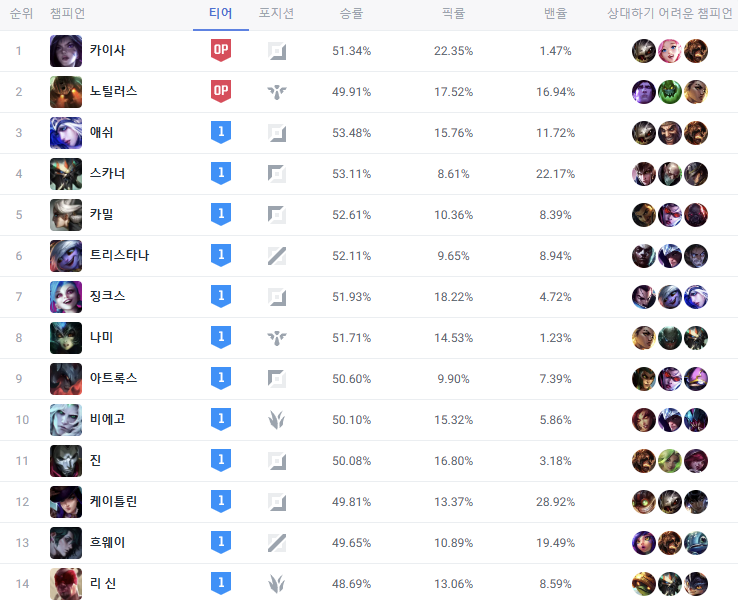

메타 챔피언은 다음과 같다.

In [ ]:
# 팀 별 메타 챔피언 픽 수에 대한 feature 넣어주기
# 현재 1티어(메타)로 취급되는 챔피언 이름 목록
champ = ['Nautilus', 'Jinx', 'Skarner', 'Hwei', 'Caitlyn',
         'Ashe', 'Nami', 'Kaisa', 'Camille', 'Tristana',
         'Viego', 'Aatrox', 'LeeSin', 'Jhin']

# 카운트를 계산하는 함수 정의
def count_champions(champion_list, champ):
    count = 0
    # 챔피언 이름 리스트를 쉼표로 분리하여 리스트로 변환
    champions = champion_list.split(',')
    # 각 이름이 champ 리스트에 있는지 확인
    for name in champions:
        if name in champ:
            count += 1
    return count

# 데이터프레임에 count 열 추가 및 카운트 계산
mc_counts = temp_champ.apply(lambda x: count_champions(x, champ))

# 결과 출력
temp['mc_counts'] = mc_counts
temp.head()

# 카피한 데이터 프레임에 시리즈로 메타 챔피언 카운트 횟수 넣어주기
mc_data = []

for idx, value in enumerate(mc_counts):
    start_idx = idx * 5
    end_idx = start_idx + 5
    mc_data.extend([value] * 5)

mc_df = pd.Series(mc_data)
df_temp['mc_counts'] = mc_df

팀 별 데이터 프레임을 만든 후, 메타 챔피언 이름을 리스트에 할당해준 뒤, 만약 메타 챔피언이 팀에 있다면, 몇 명의 메타 챔피언이 팀에 있는지를 바꿔주는 코드 작성

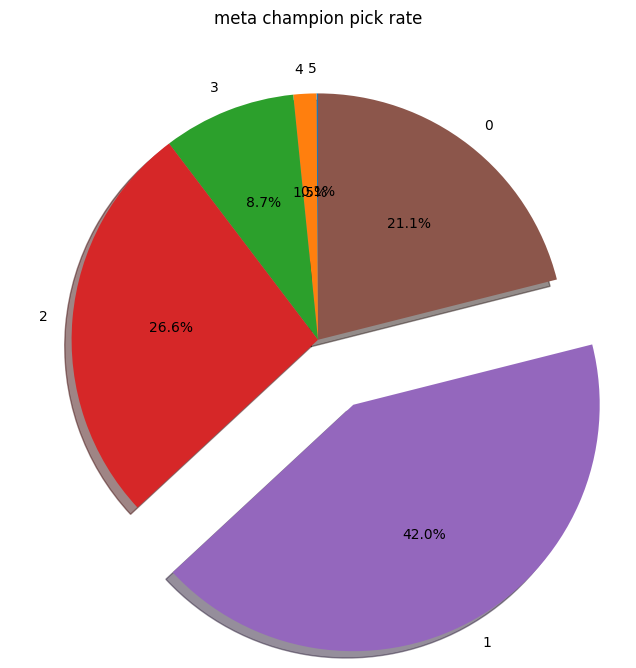

INFO:pycodestyle:5:23: E231 missing whitespace after ','


In [ ]:
# 메타 챔피언을 픽한 팀의 수는?
p = temp['mc_counts'].value_counts(normalize=True).sort_index(ascending=False)

# 파이 차트 그리기
plt.figure(figsize=(10,8))
sizes = [0.001, 0.015, 0.087, 0.265, 0.419, 0.210]
explode = [0, 0, 0, 0, 0.3, 0]
labels = ['5', '4', '3', '2', '1', '0']
plt.pie(sizes, explode=explode, labels=labels, autopct='%0.1f%%',
        shadow=True, startangle=90)
plt.title('meta champion pick rate')
plt.show()

1. 천상계 게임에서는 메타 챔피언을 픽하는 게임이 약 79%, 메타 챔피언을 픽하지 않는 게임이 21%였다.
2. 천상계 게임에서는 메타 챔피언이 1개인 픽을 하는 경우가 많았다.

Text(0.5, 1.0, 'Winning percentage between mc pick and normal pick')

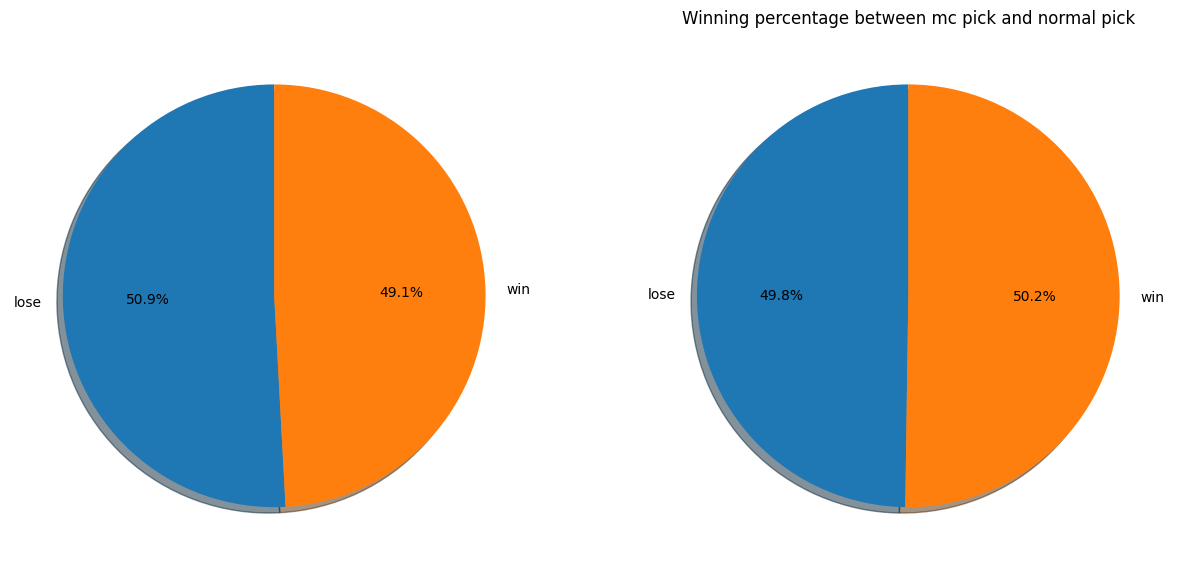

In [ ]:
# 메타 챔피언을 픽 수에 따라 게임 승률은 어떻게 될까?
# 메타 챔피언을 안 픽한 팀과 픽한 팀의 승률 차이는
palette = sns.color_palette('deep',10)
def meta_counts(x):
    if x>=1:
        return 'meta pick'
    else:
        return 'normal pick'
temp['mc_category'] = temp['mc_counts'].apply(meta_counts)
df_temp['mc_category'] = df_temp['mc_counts'].apply(meta_counts)
fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].pie(temp[temp['mc_category']=='normal pick']['win'].value_counts(normalize=True).sort_index(),
            labels=['lose','win'], autopct='%0.1f%%',shadow=True, startangle=90)
axes[1].pie(temp[temp['mc_category']=='meta pick']['win'].value_counts(normalize=True).sort_index(),
            labels=['lose', 'win'], autopct='%0.1f%%',shadow=True, startangle=90)
plt.title('Winning percentage between mc pick and normal pick')

메타 챔피언을 고른 팀의 경우 승률이 50.2%로 메타 챔피언을 고르지 않은 팀보다 승률이 1.1% 더 높게 나타난다.

<Axes: title={'center': 'Gold Earned between mc'}, xlabel='mc_counts', ylabel='goldEarned'>

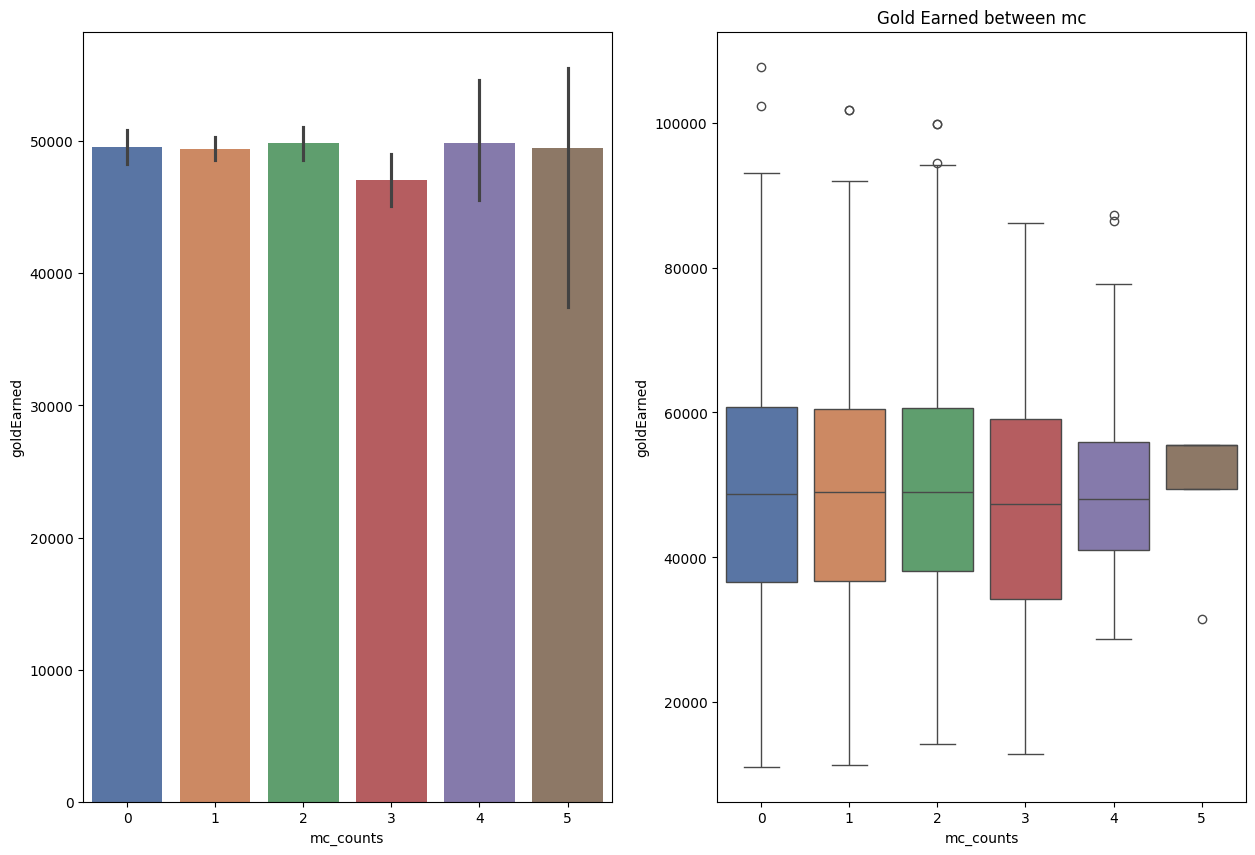

INFO:pycodestyle:3:26: E231 missing whitespace after ','
INFO:pycodestyle:5:17: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:5:19: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:5:39: E231 missing whitespace after ','
INFO:pycodestyle:6:31: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:6:33: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:7:17: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:7:19: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:8:31: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:8:33: E251 unexpected spaces around keyword / parameter equals


In [ ]:
# 메타 챔피언을 고른 팀의 골드 수급량은 어떻게 될까?
# 카테고리형 변수를 만들어 추가해준다.
fig, axs = plt.subplots(1,2, figsize=(15, 10))
plt.title('Gold Earned between mc')
sns.barplot(data = temp, x='mc_counts',y='goldEarned',
            ax=axs[0], palette = palette)
sns.boxplot(data = temp, x='mc_counts', y='goldEarned',
            ax=axs[1], palette = palette)

1. 천상계 게임이라 그런지 메타 챔피언 픽 수에 따라 골드 수급량에 차이가 거의 나타나지 않는다.
2. 4명이나 5명의 챔피언을 고르는 경우는 거의 없어서 데이터가 부정확하지만, 박스플롯을 볼 때 메타 챔피언을 고르는 수와 상관없이 평균에 수렴하는 것을 볼 수 있다.



<Axes: xlabel='mc_category', ylabel='totalDamageDealtToChampions'>

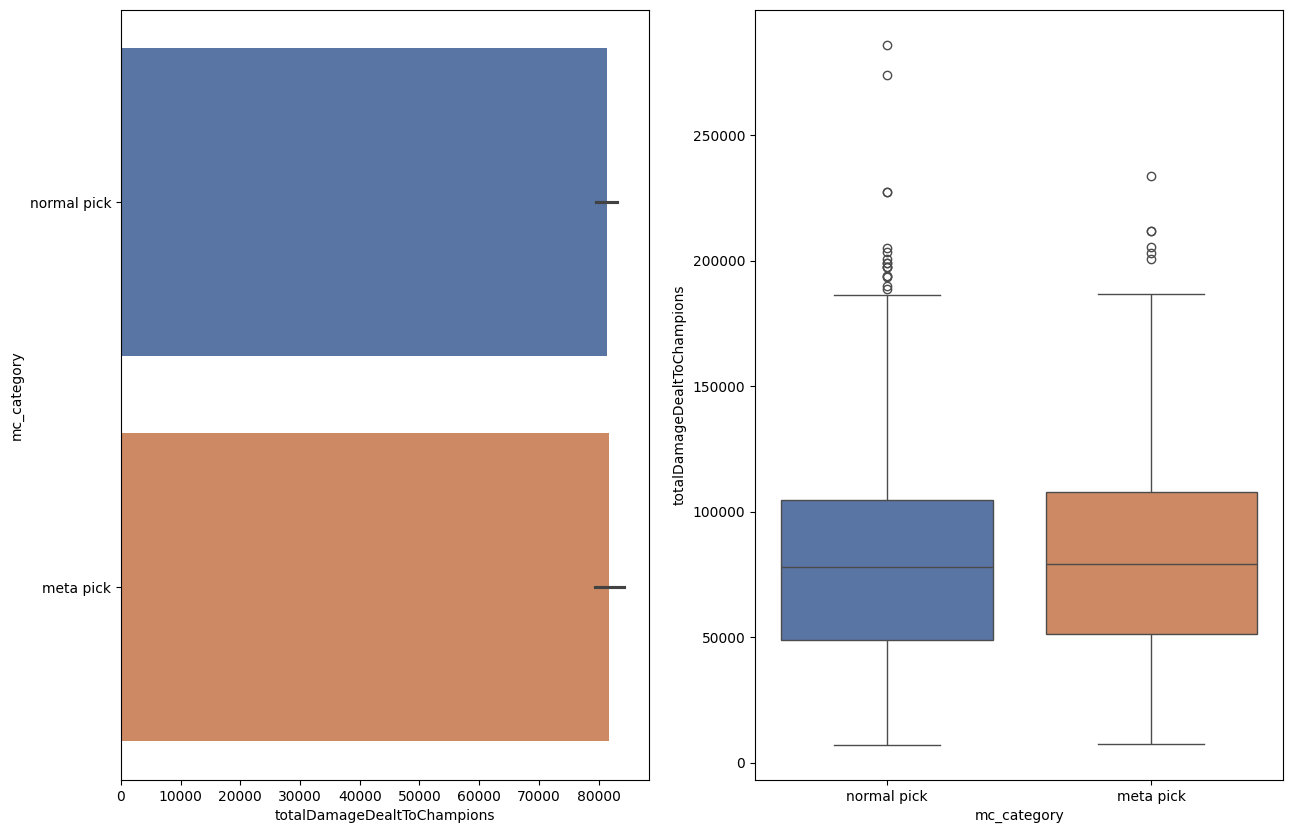

INFO:pycodestyle:5:31: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:5:33: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:7:31: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:7:33: E251 unexpected spaces around keyword / parameter equals


In [ ]:
# 메타 챔피언에 따라 챔피언에게 데미지를 입히는 것에 차이가 있을까?
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

sns.barplot(data=temp, x='totalDamageDealtToChampions', y='mc_category',
            ax=axs[0], palette = palette)
sns.boxplot(data=temp, x='mc_category', y='totalDamageDealtToChampions',
            ax=axs[1], palette = palette)

메타 챔피언을 픽한 팀과 픽하지 않은 팀에 있어서 챔피언에게 가한 피해량의 차이가 거의 없다.

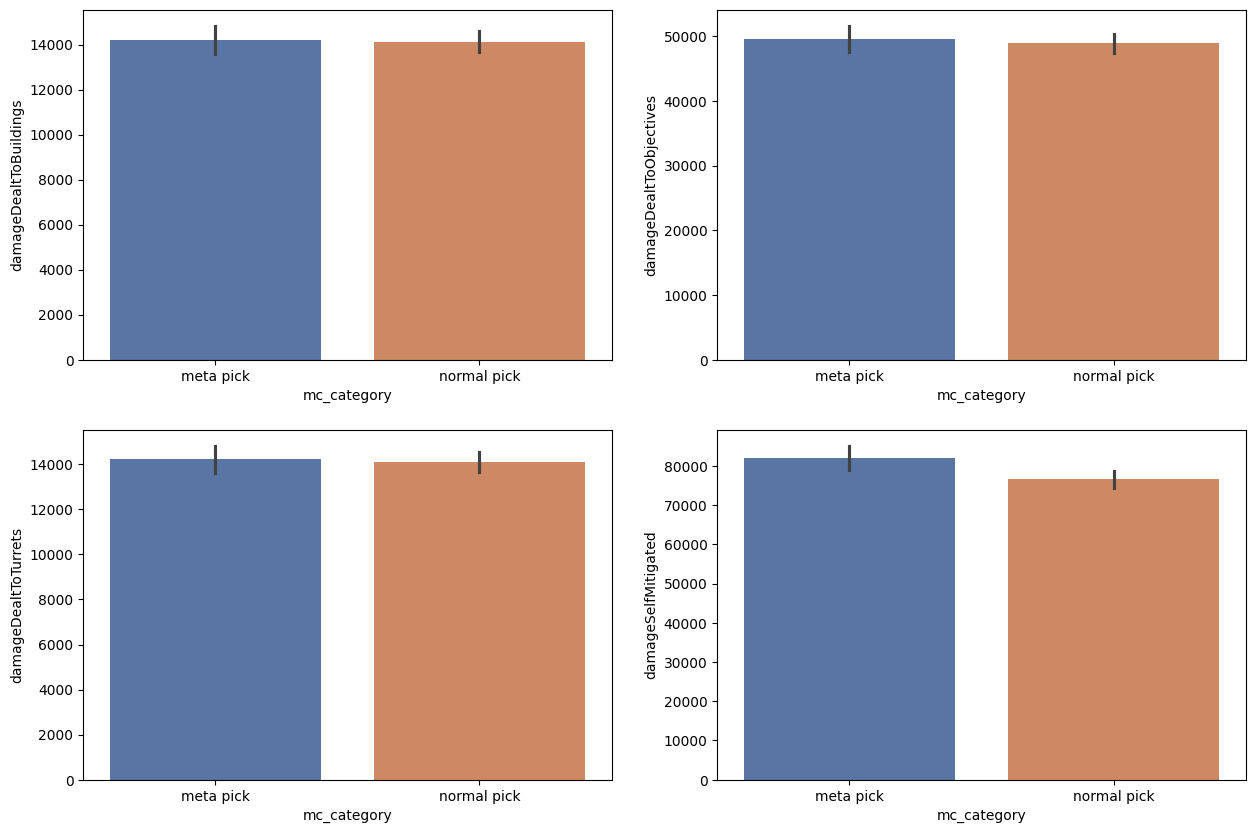

In [ ]:
# 메타 챔피언 픽에 따라 데미지를 입히는 것의 차이는 유의미하게 나타나는가?
damage_col = ['damageDealtToBuildings', 'damageDealtToObjectives',
              'damageDealtToTurrets', 'damageSelfMitigated']
fig, axs = plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    sns.barplot(data = temp, x='mc_category',y=damage_col[i], order=['meta pick','normal pick'], ax = axs[i//2,i%2], palette = palette)

포탑에 가한 피해, 오브젝트에 가한 피해, 건물(넥서스,억제기)에 가한 피해의 경우 메타 챔피언을 픽한 팀과 픽하지 않은 팀의 차이는 없었다.

 그러나 자기에게 받는 피해 감소량과 같은 경우 메타 픽이 더 높았다. 선정된 메타 챔피언들은 방어, 마법저항력이 높은 튼튼한 챔피언이거나  혹은 타인에게 쉴드를 제공해줄 수 있는 유틸리티성을 지닌 챔피언이기 때문에 납득할 수 있는 수치일 것 같다.

이것으로 보아 메타 챔피언이 일반 챔피언보다 좀 더 방어적인 기능을 가졌고, 방어적인 기능을 제공할 수 있는 챔피언이 더 많이 뽑혔겠다고 생각했다. 그렇다면,실제로 어느 라인의 챔피언이 많이 뽑혔을까?

In [ ]:
# 챔피언 포지션 만들기, 메타 침피언을 픽한 데이터들만 뽑기
def select_lines(row):
    if row['teamPosition_BOTTOM'] == 1:
        return 'bottom'
    elif row['teamPosition_JUNGLE'] == 1:
        return 'jungle'
    elif row['teamPosition_MIDDLE'] == 1:
        return 'mid'
    elif row['teamPosition_TOP'] == 1:
        return 'top'
    else:
        return 'utility'

df_temp['position'] = df_temp.apply(select_lines, axis=1)
mchamp = df_temp[df_temp['championName'].isin(champ)]

어느 포지션에서 메타 챔피언이 가장 많이 선택되는 지 보기 위해서 전처리하는 과정

<Axes: title={'center': 'positions of picked meta champions'}, xlabel='proportion', ylabel='position'>

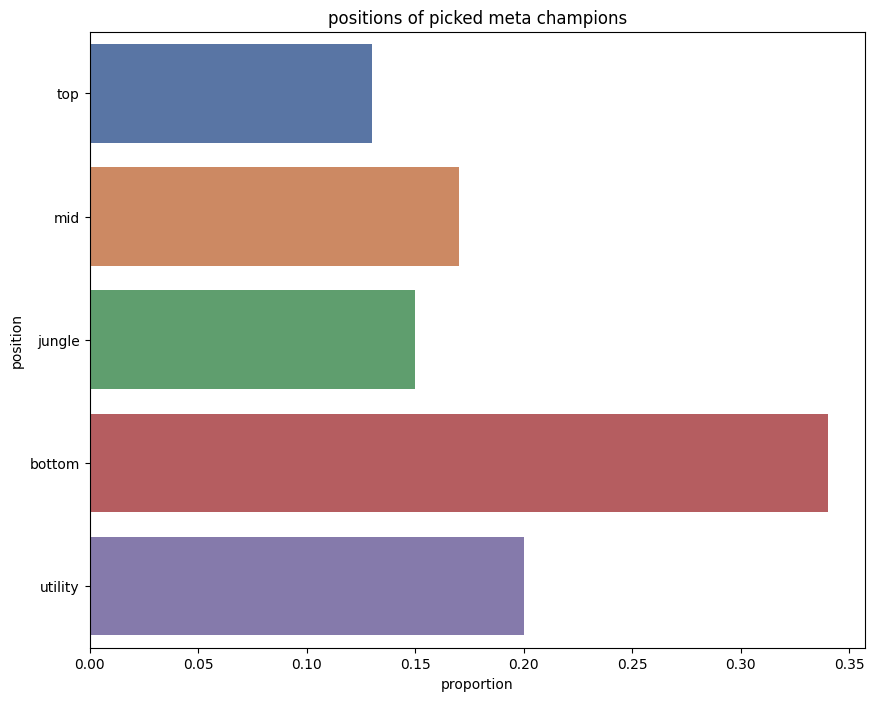

In [ ]:
# 어느 포지션에서 메타 챔피언이 가장 많이 선택될까?
t = mchamp['position'].value_counts(normalize=True).round(2).reset_index()
plt.figure(figsize=(10,8))
plt.title('positions of picked meta champions')
sns.barplot(t, x='proportion', y='position',
            order=['top', 'mid', 'jungle', 'bottom', 'utility'], palette = palette)

보아하니, 바텀 챔피언들이 많이 픽되고 있다. (utility도 바텀 라인임)
즉, 현재 메타는 바텀에서 챔피언을 뽑는게 중요하다고 해석될 수도 있는 부분이다.

<Axes: xlabel='count', ylabel='championName'>

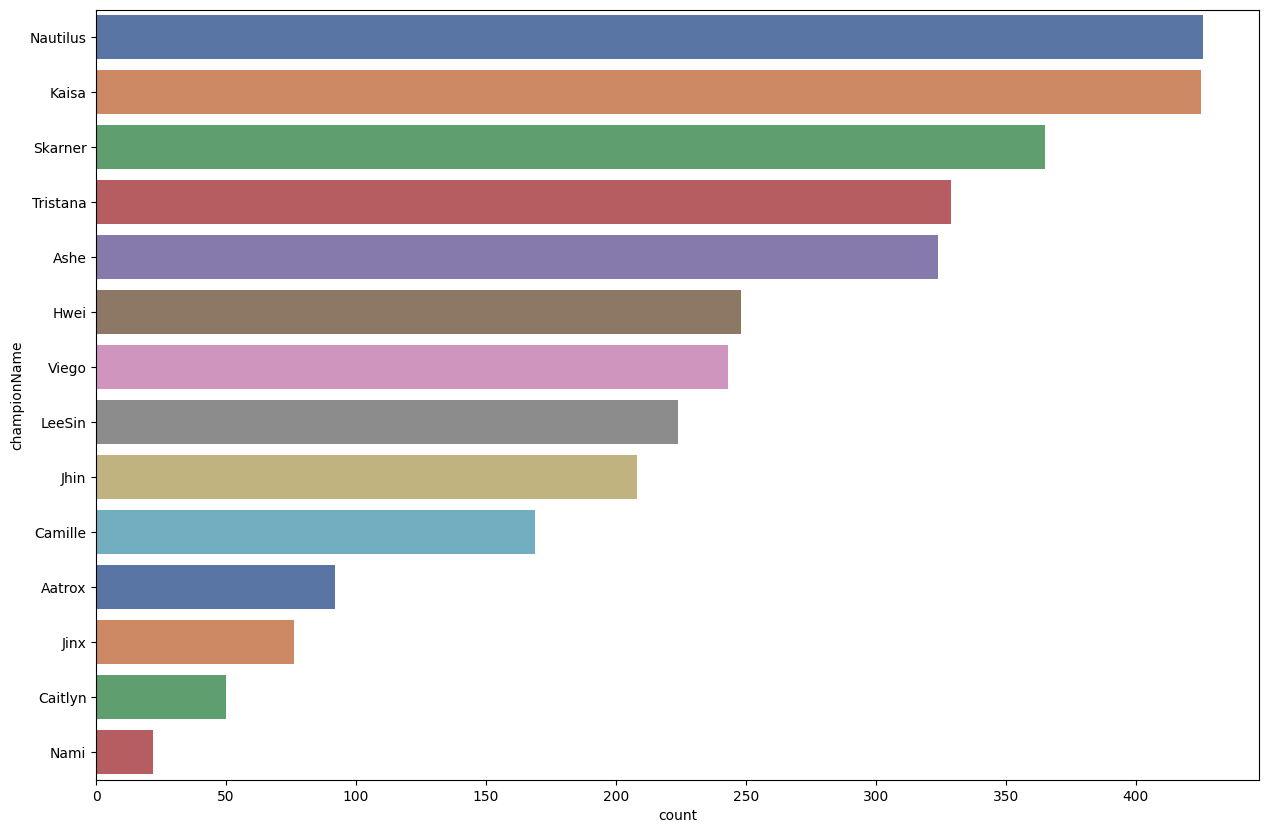

INFO:pycodestyle:7:80: E501 line too long (80 > 79 characters)
INFO:pycodestyle:8:23: E231 missing whitespace after ','
INFO:pycodestyle:9:53: E251 unexpected spaces around keyword / parameter equals
INFO:pycodestyle:9:55: E251 unexpected spaces around keyword / parameter equals


In [ ]:
# 픽 수가 가장 많은 현재 챔피언 순서
p = df_temp['championName'].value_counts().reset_index()
cs = []
for i in champ:
    if i in p['championName'].unique():
        cs.append(p[p['championName'] == i])
cs = pd.concat(cs, ignore_index=True).sort_values(by=['count'], ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(cs, x='count', y='championName', palette = palette)

노틸러스 - 카이사 - 스카너 - 트리스타나 - 애쉬 - 흐웨이 - 비에고 - 리신 - 진 - 카밀 - 아트록스 - 아트록스 - 징크스 - 아리 - 케이틀린 - 나미의 순서로 픽 수가 많다.

원딜, 탱커 계열의 챔피언이지만, 방어적인 이점을 제공하고 튼튼한 챔피언이 많이 픽되고 있다. 그러나 원딜과 같은 경우, 미드 트리스타나, 미드 카이사, 탑 노틸러스, 미드 애쉬처럼 미드에서 원딜 챔피언이 사용되는 경우가 많기 때문에 어느 라인으로 챔피언이 가장 많이 가는지 봐야한다.  



In [ ]:
# 메타 챔피언들은 어느 라인에 가장 많이 갈까?
t = mchamp.groupby(['championName'])['position'].value_counts(normalize=True).round(2).reset_index()
t

championName position  proportion
0        Aatrox      top        0.95
1        Aatrox      mid        0.05
2          Ashe   bottom        0.91
3          Ashe  utility        0.09
4       Caitlyn   bottom        1.00
5       Camille  utility        0.51
6       Camille      top        0.48
7       Camille      mid        0.01
8          Hwei      mid        0.90
9          Hwei  utility        0.09
10         Hwei   bottom        0.01
11         Hwei      top        0.00
12         Jhin   bottom        0.99
13         Jhin      top        0.01
14         Jinx   bottom        1.00
15        Kaisa   bottom        0.99
16        Kaisa      mid        0.01
17        Kaisa  utility        0.00
18        Kaisa      top        0.00
19       LeeSin   jungle        0.95
20       LeeSin      top        0.04
21       LeeSin      mid        0.01
22       LeeSin  utility        0.00
23         Nami  utility        0.95
24         Nami      mid        0.05
25     Nautilus  utility        0.96
26     Nautilus   bottom        0.04
27      Skarner      top        0.67
28      Skarner  utility        0.22
29      Skarner   jungle        0.09
30      Skarner      mid        0.01
31      Skarner   bottom        0.01
32     Tristana      mid        0.90
33     Tristana   bottom        0.08
34     Tristana      top        0.02
35     Tristana   jungle        0.00
36     Tristana  utility        0.00
37        Viego   jungle        0.90
38        Viego      mid        0.09
39        Viego      top        0.01

INFO:pycodestyle:2:80: E501 line too long (100 > 79 characters)


원딜 챔피언들의 경우, 트리스타나의 경우만을 제외하면, 원딜 챔피언이 바텀 라인의 챔피언으로 선택될 확률이 높다.
즉, 현재 메타는 바텀 메타 챔피언을 뽑는게 중요하다고 해석될 수도 있는 부분이다.

바텀 라인에 메타 챔피언이 픽이 되는 확률이 높으니 바텀 메타 챔피언을 픽한다면, 바텀 메타 챔피언을 픽하지 않은 팀보다 더 승률이 높을까? 궁금해졌다.

<Axes: title={'center': 'bottom line champs winning rate'}, xlabel='proportion', ylabel='championName'>

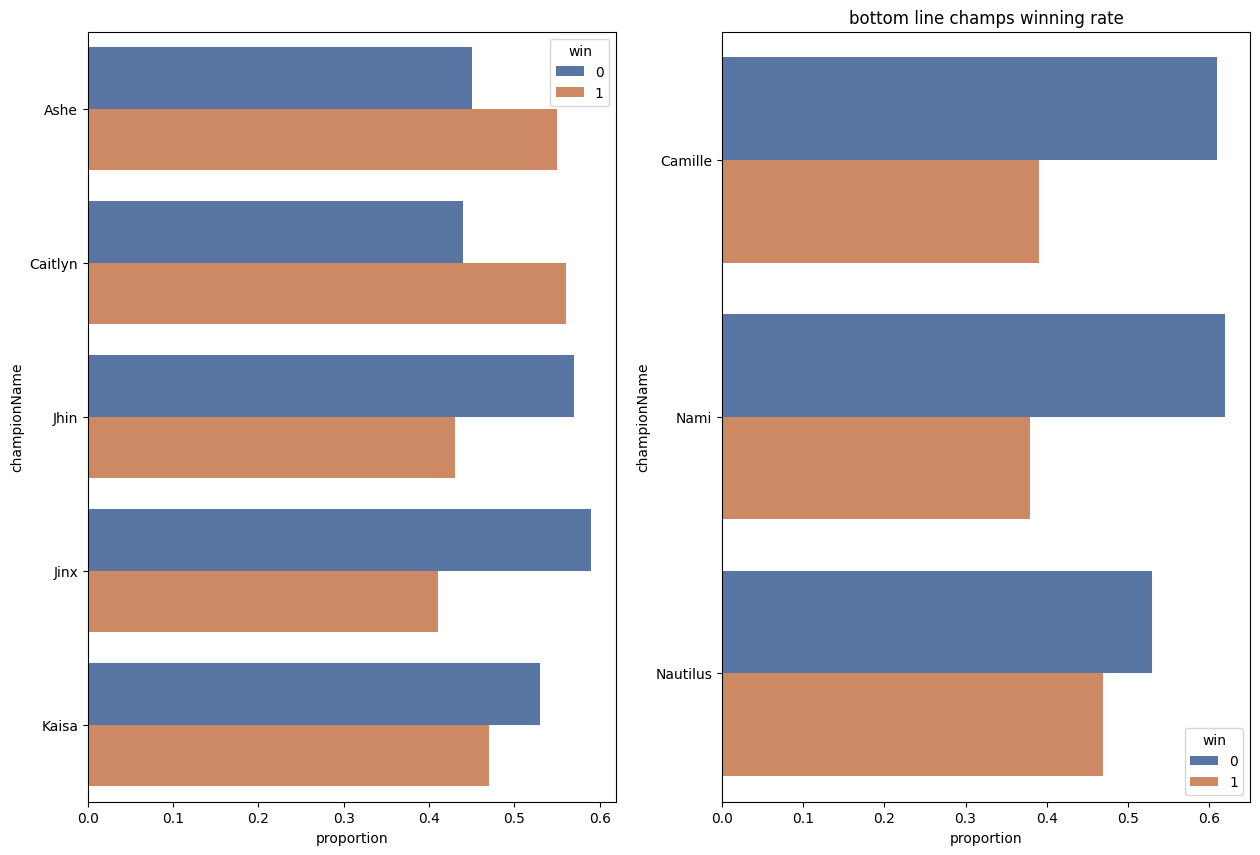

In [ ]:
# 바텀 라인(원딜)에서의 메타 챔피언 승률은 어떨까?
b = df_temp[(df_temp['championName'].isin(['Kaisa', 'Jhin', 'Jinx', 'Ashe', 'Caitlyn']))&
    (df_temp['position']=='bottom') & (df_temp['mc_category']=='meta pick')].groupby(['championName'])['win'].value_counts(normalize=True).round(2).reset_index()
u = df_temp[(df_temp['championName'].isin(['Camille' ,'Nami', 'Nautilus']))&
    (df_temp['position']=='utility') & (df_temp['mc_category']=='meta pick')].groupby(['championName'])['win'].value_counts(normalize=True).round(2).reset_index()
fig, axs = plt.subplots(1,2, figsize=(15,10))
plt.title('bottom line champs winning rate')
sns.barplot(b, x='proportion', y='championName', hue='win',
            palette = palette, ax=axs[0])
sns.barplot(u, x='proportion', y='championName', hue='win',
            palette = palette, ax=axs[1])

바텀라인의 메타 챔피언을 픽한다고, 승률이 크게 오르진 않았다. 다만, 알수 있는 것은

1. 애쉬, 케이틀린을 골랐을 때 승리할 확률이 패배할 확률보다 약간 10%정도 더 높다. 징크스,진,카이사의 경우 패배할 확률이 더 높다.
2. 나미, 카밀 같은 챔피언을 골랐을 경우, 승률이 매우 낮다. 노틸러스의 경우 평균 치랑 비슷하게 보인다.

반면, 애쉬와 케이틀린은 승률이 높은 이유는 무엇일까?? (애쉬 승률 55, 케이틀린 승률 56)
승률이 높은 이유로 다음과 같은 가설을 세울 수 있다.
1. 애쉬, 케이틀린은 사거리가 긴 챔피언이어서 라인전에 강하기 때문에 승률이 높을 것이다.
2. 애쉬, 케이틀린은 상대 챔피언을 방해할 수 있는 CC기가 있기 때문에 라인전에 강해 승률이 높을 것이다.
3. 애쉬, 케이틀린은 순수 상대방에게 가한 피해량이 다른 챔피언보다 기여도가 높기 때문에 승률이 높을 것이다.

In [ ]:
# 박스 플롯을 만드는 데 있어서 데이터가 이상해질 수 있으니, 추출되는 데이터는 20회 이상 픽된 챔피언으로 한다.
counts = df_temp['championName'].value_counts()
champ_20_over = counts[counts>=20]
champ_20_over = df_temp[df_temp['championName'].isin(champ_20_over.index)]

<Axes: title={'center': 'timeCCingOthers by bottom champ'}, xlabel='championName', ylabel='timeCCingOthers'>

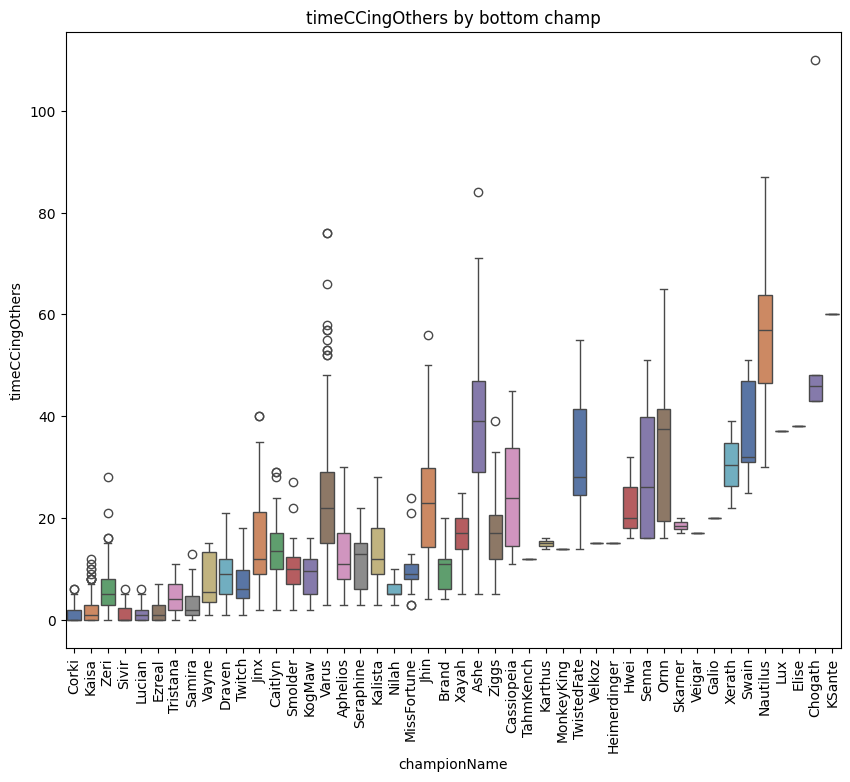

In [ ]:
# 그렇다면, 애쉬와 케이틀린은 승률이 높은 이유는 무엇일까?? (1)
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.title('timeCCingOthers by bottom champ')
sns.boxplot(champ_20_over[champ_20_over['position'] == 'bottom'].sort_values(by='timeCCingOthers'), x = 'championName',
            y = 'timeCCingOthers', palette = palette)

<Axes: title={'center': 'totalTimeCCDealt by bottom champ'}, xlabel='championName', ylabel='totalTimeCCDealt'>

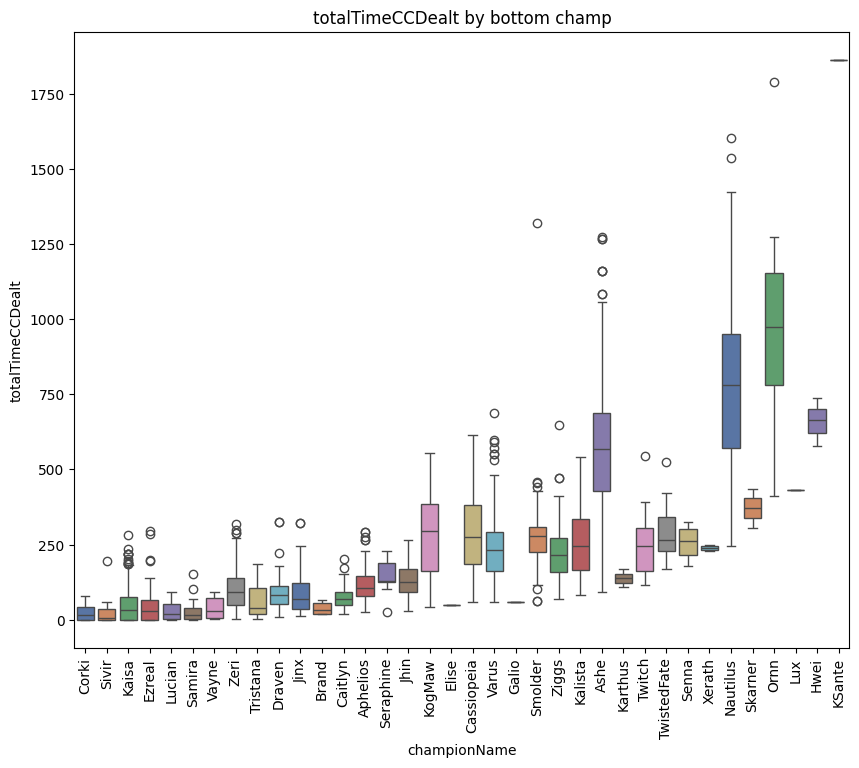

In [ ]:
# 그렇다면, 애쉬와 케이틀린은 승률이 높은 이유는 무엇일까??(2)
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.title('totalTimeCCDealt by bottom champ')
sns.boxplot(champ_20_over[champ_20_over['position']=='bottom'].sort_values(by='totalTimeCCDealt'), x='championName',
            y='totalTimeCCDealt', palette = palette)

위의 박스플롯들을 종합해보았을 때, 애쉬의 경우, 원거리 딜러들 중 CC기를 포함한 데미지를 주는 플롯이 가장 높게 나타난 챔피언이면서 CC기로 상대를 방해하는 시간이 가장 긴 때문에, 애쉬 챔피언의 승률에 영향을 줄 수 있는 변수라고 생각할 수 있다. 반면, 케이틀린 챔피언의 경우, CC기 플롯에 있어서 유의미한 결과를 볼 수 없었다. 뿐만 아니라, 사거리는 데이터 상 존재하지 않는 데이터기 때문에 애쉬, 케이틀린 둘다 가설을 입증하기 어렵고, 챔피언에게 가한 피해량과 같은 경우에는 애쉬, 케이틀린 두 챔피언 모두 다 박스 플롯이 의미있게 보이진 않았다.

#### 가설: 오브젝트(용,바론)을 잘 획득한 팀이 승률이 높을 것이다.

용, 바론은 게임 내에서 능력치를 주거나 강력한 버프를 주는 오브젝트이다.

특히 한 팀이 4번째 용을 처치하면 '용의 영혼' 이라는 강력한 버프 효과를 준다.

한 팀이 '용의 영혼'을 획득하고 나면 그 다음부터는 처치시 상대를 처형하는 버프를 주는 '장로 드래곤'이 등장한다.

이렇듯 오브젝트는 게임 내에서 많은 영향을 미치고 이것이 승률에 얼마나 영향을 미치는지 알아보기로 하였다.

우선 각 매치마다 분석해야하므로 첫 행부터 10개씩 끊어서 matchId를 부여하였다.

In [ ]:
# 데이터 읽기
data = pd.read_csv('/content/drive/MyDrive/team_LimJung_2/Data/total_cleaned_data_riot_api.csv')
data['matchId'] = (data.index // 10) + 1
data.columns
print('총 매치 수:', data['matchId'].max())

총 매치 수: 1248


총 1248개의 경기가 있었다.

먼저 바론 처치가 승률에 얼마나 관련되어있는지 알아보기 위해 분석해보았다.

바론은 게임시작 20분 이후에 등장하게 되므로 timePlayed 컬럼에 60으로 나눠 20분 보다 빨리 끝난 게임은 제외하도록 하였다.

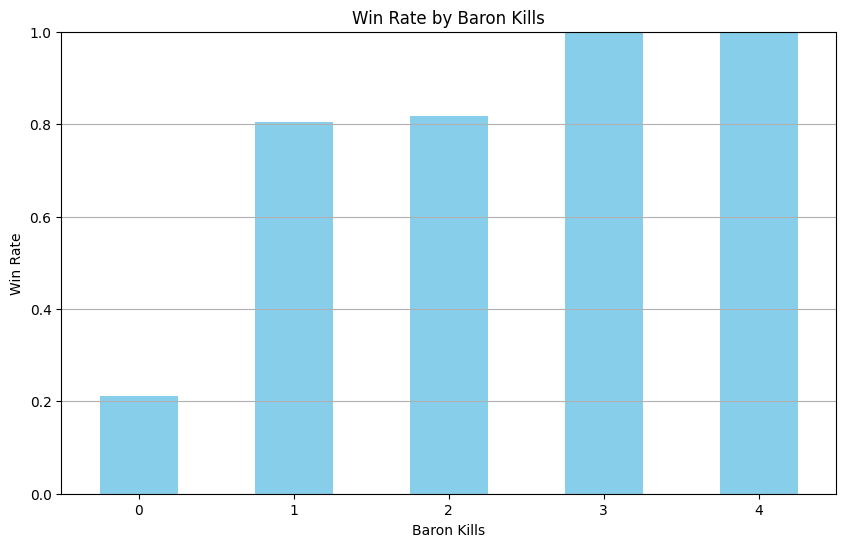

제외된 매치 수: 394


In [ ]:
# 20분 이하 게임 제외
data['timePlayed_minutes'] = data['timePlayed'] / 60
filtered_data = data[data['timePlayed_minutes'] > 20]

# 제외된 매치 수
excluded_matches = data['matchId'].nunique() - filtered_data['matchId'].nunique()

# 바론 킬별 팀 승률 계산
team_stats = filtered_data.groupby(['matchId', 'win']).agg({
    'baronKills': 'sum'
}).reset_index()

# 승률 계산
win_rate = team_stats.groupby('baronKills')['win'].mean()

# 시각화
plt.figure(figsize=(10, 6))
win_rate.plot(kind='bar', color='skyblue')
plt.title('Win Rate by Baron Kills')
plt.xlabel('Baron Kills')
plt.ylabel('Win Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')

plt.show()

# 필터링된 데이터프레임 표시
filtered_data.head()

# 결과 출력
print(f"제외된 매치 수: {excluded_matches}")

바론을 획득하였을 때 승률이 높아진다는 것을 알 수 있다.

천상계 게임에서는 바론을 획득하고 활용하여 이득을 얻어서 게임을 승리하는 방향으로 잘 이끌어간다고 생각할 수 있다.


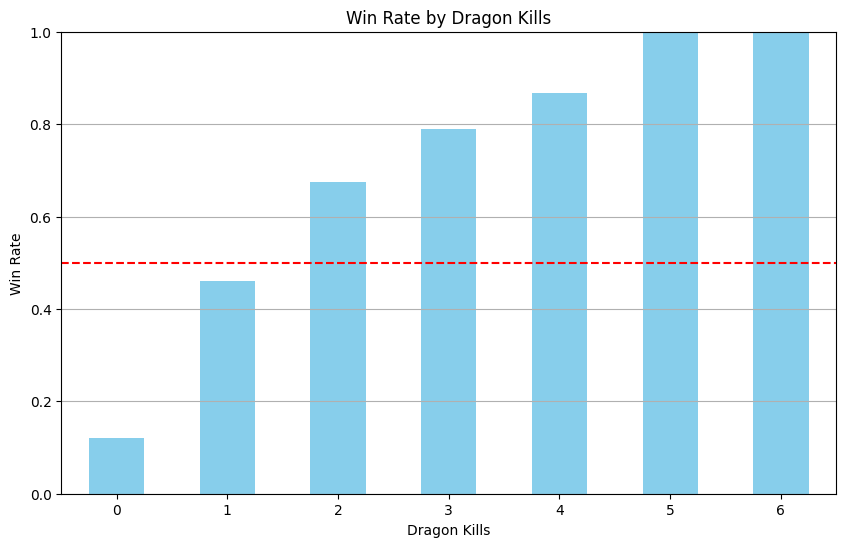

In [ ]:
# 용 처치별 팀 승률 계산
team_stats_dragon = data.groupby(['matchId', 'win']).agg({
    'dragonKills': 'sum'
}).reset_index()

# 승률 계산
win_rate_dragon = team_stats_dragon.groupby('dragonKills')['win'].mean()

# 시각화
plt.figure(figsize=(10, 6))
win_rate_dragon.plot(kind='bar', color='skyblue')
plt.title('Win Rate by Dragon Kills')
plt.xlabel('Dragon Kills')
plt.ylabel('Win Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.axhline(0.5, color='red', linestyle='--')
plt.grid(axis='y')

plt.show()


In [ ]:
# 팀별 드래곤 처치 횟수 계산
team_dragon_kills = data.groupby(['matchId', 'win']).agg({
    'dragonKills': 'sum'
}).reset_index()

# 드래곤 처치 횟수가 4 이상인 경우 필터링
teams_with_4_or_more_dragons = team_dragon_kills[team_dragon_kills['dragonKills'] >= 4]

# 결과 확인
teams_with_4_or_more_dragons

matchId  win  dragonKills
60         31    0            4
67         34    1            4
73         37    1            4
93         47    1            4
95         48    1            4
...       ...  ...          ...
2389     1195    1            4
2421     1211    1            4
2427     1214    1            4
2467     1234    1            4
2471     1236    1            4

[115 rows x 3 columns]

우선 용의 영혼을 획득한 경우가 얼마나 있는지 알아보았다.
115 경기에서 용의 영혼을 획득했다고 알 수 있다.

In [ ]:
# 팀별 드래곤 처치 횟수 계산
team_dragon_kills = data.groupby(['matchId', 'win']).agg({
    'dragonKills': 'sum'
}).reset_index()

# 드래곤 처치 횟수가 4 이상인 팀 필터링
matches_with_4_or_more_dragons = team_dragon_kills[team_dragon_kills['dragonKills'] >= 4]

# matchId별로 win이 0, 1 모두 존재하는 경우 필터링
matches_with_both_teams_4_or_more_dragons = matches_with_4_or_more_dragons.groupby('matchId').filter(lambda x: len(x) > 1)

# 결과 확인
matches_with_both_teams_4_or_more_dragons

Empty DataFrame
Columns: [matchId, win, dragonKills]
Index: []

드래곤 처치가 4일때도 용의 영혼을 차지하지 못했을 수 있는 경우의 수가 있는지 알아보기 위해 코드를 작성하였다.

리그오브레전드의 용은 한 팀이 4마리의 용을 처치하면 용의 영혼을 획득하고 다음부터 '장로 드래곤'이 일반 용을 대신하여 생성된다.

용의 영혼을 획득하지 못한 팀도 일반 드래곤 3마리 + 장로 드래곤 1마리 처치를 통해 4 이상을 기록할 수 있다.

장로 드래곤 처치할 시 게임에도 엄청난 영향을 미치므로 따로 알아보기로 하자

한 경기에서 두 팀 모두 드래곤 처치가 4 이상인 경우가 있는지 알아보았더니 경우가 존재하지 않는다고 결과가 나왔다.

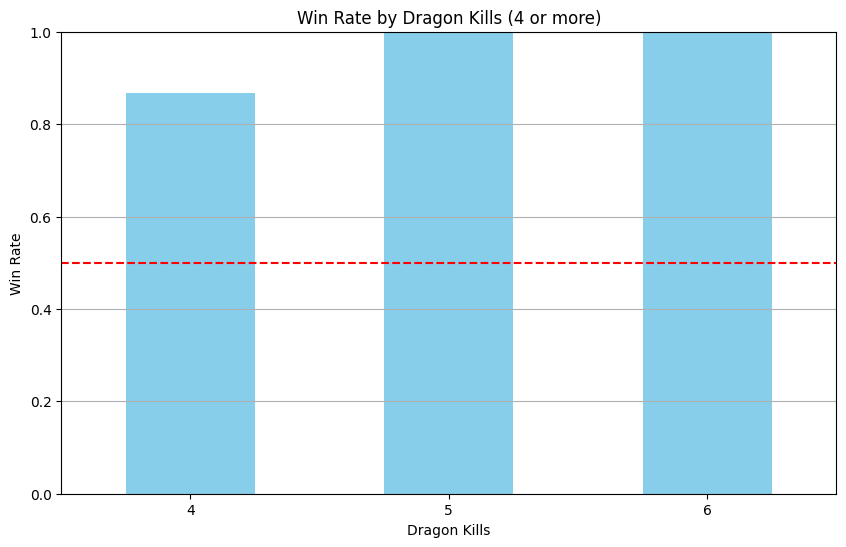

In [ ]:
# 팀별 드래곤 처치 횟수 계산
team_dragon_kills = data.groupby(['matchId', 'win']).agg({
    'dragonKills': 'sum'
}).reset_index()

# 드래곤 처치 횟수가 4 이상인 경우 필터링
teams_with_4_or_more_dragons = team_dragon_kills[team_dragon_kills['dragonKills'] >= 4]

# 승리할 확률 계산
win_rate_4_or_more_dragons = teams_with_4_or_more_dragons.groupby('dragonKills')['win'].mean()

# 시각화
plt.figure(figsize=(10, 6))
win_rate_4_or_more_dragons.plot(kind='bar', color='skyblue')
plt.title('Win Rate by Dragon Kills (4 or more)')
plt.xlabel('Dragon Kills')
plt.ylabel('Win Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.axhline(0.5, color='red', linestyle='--')
plt.grid(axis='y')

plt.show()

용의 영혼을 획득한 팀이 승률이 매우 높게 나오는 것을 알 수 있다.

또한 용의 영혼을 획득한 팀이 드래곤을 한번 또는 두번 더 획득하였을 때 (드래곤 처치 횟수가 5,6일때) 승률이 1이므로 용의 영혼을 획득하고 장로 드래곤을 처치하였을 때는 따로 분석하지 않아도 된다.

하지만 용의 영혼을 획득하지 않고 장로드래곤을 획득하였는지 데이터상으로 알 수가 없기에 분석할 수 없다.

현재까지의 결론은 바론과 드래곤, 두 오브젝트 모두 승률에 큰 영향을 끼친다고 알 수 있다.

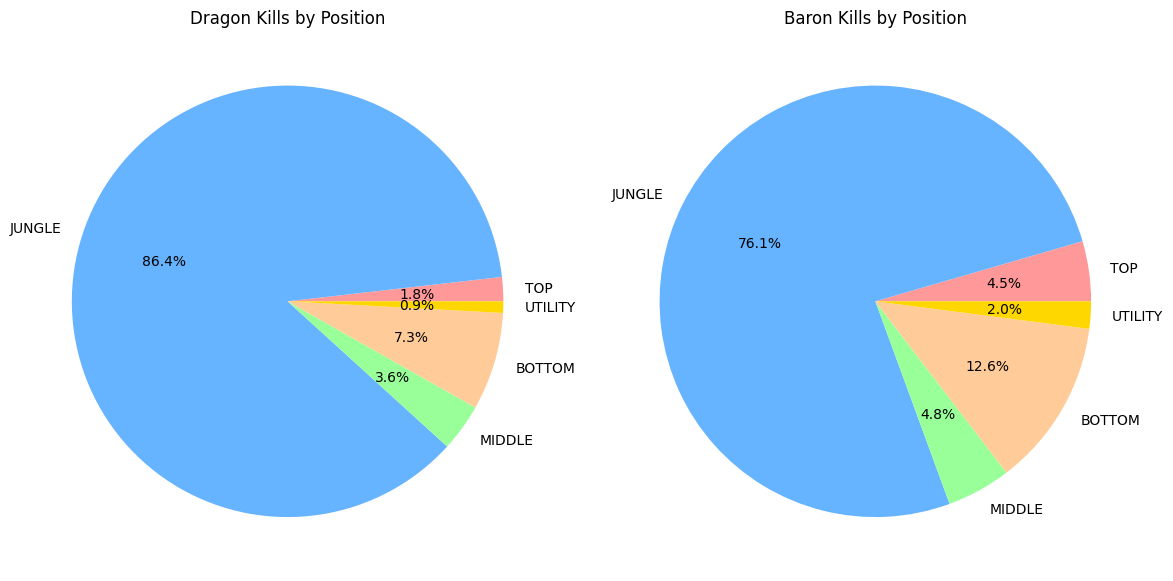

In [ ]:
# 각 포지션별 드래곤 처치 및 바론 처치 횟수 계산
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
dragon_kills_by_position = {}
baron_kills_by_position = {}

for pos in positions:
    position_col = f'teamPosition_{pos}'
    dragon_kills_by_position[pos] = data.loc[data[position_col] == 1, 'dragonKills'].sum()
    baron_kills_by_position[pos] = data.loc[data[position_col] == 1, 'baronKills'].sum()

# 결과를 데이터프레임으로 변환
kills_df = pd.DataFrame({
    'Position': positions,
    'DragonKills': [dragon_kills_by_position[pos] for pos in positions],
    'BaronKills': [baron_kills_by_position[pos] for pos in positions]
})
# 드래곤 처치 횟수 파이차트
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(kills_df['DragonKills'], labels=kills_df['Position'], autopct='%1.1f%%', colors=['#FF9999','#66B3FF','#99FF99','#FFCC99','#FFD700'])
plt.title('Dragon Kills by Position')

# 바론 처치 횟수 파이차트
plt.subplot(1, 2, 2)
plt.pie(kills_df['BaronKills'], labels=kills_df['Position'], autopct='%1.1f%%', colors=['#FF9999','#66B3FF','#99FF99','#FFCC99','#FFD700'])
plt.title('Baron Kills by Position')

plt.tight_layout()
plt.show()

대부분의 상황에서 오브젝트를 처치하는 포지션은 정글일 것이다.
왜냐하면 정글은 몬스터에서 큰 데미지를 줄 수 있는 '강타'라는 소환사 주문을 사용하기 때문이다.

하지만 스틸의 변수도 있고 적이 주변에 없는 안전한 상황에서는 '강타'를 사용하여 먹지 않을 수도 있기 때문에, 데이터셋에서 확인 할 수 있는 스틸의 횟수를 알아보겠다.

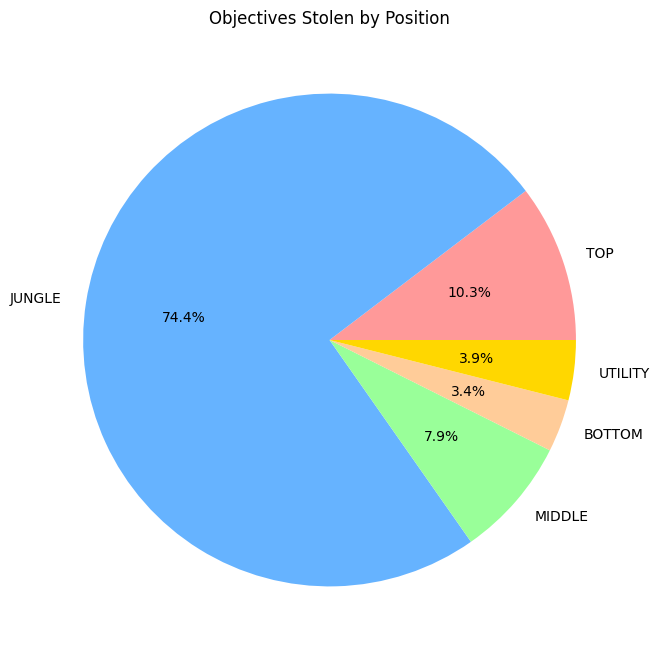

In [ ]:

# 각 포지션별 objectivesStolen 횟수 계산
positions = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY']
objectives_stolen_by_position = {}

for pos in positions:
    position_col = f'teamPosition_{pos}'
    objectives_stolen_by_position[pos] = data.loc[data[position_col] == 1, 'objectivesStolen'].sum()

# 결과를 데이터프레임으로 변환
objectives_stolen_df = pd.DataFrame({
    'Position': positions,
    'ObjectivesStolen': [objectives_stolen_by_position[pos] for pos in positions]
})

# objectivesStolen 횟수 파이차트
plt.figure(figsize=(8, 8))
plt.pie(objectives_stolen_df['ObjectivesStolen'], labels=objectives_stolen_df['Position'], autopct='%1.1f%%', colors=['#FF9999','#66B3FF','#99FF99','#FFCC99','#FFD700'])
plt.title('Objectives Stolen by Position')

plt.show()

오브젝트 스틸에서도 정글이 수치가 높은 것으로 보인다.

어느 정글 챔피언이 바론이나 드래곤을 잘 처치하는지 궁금해졌다.

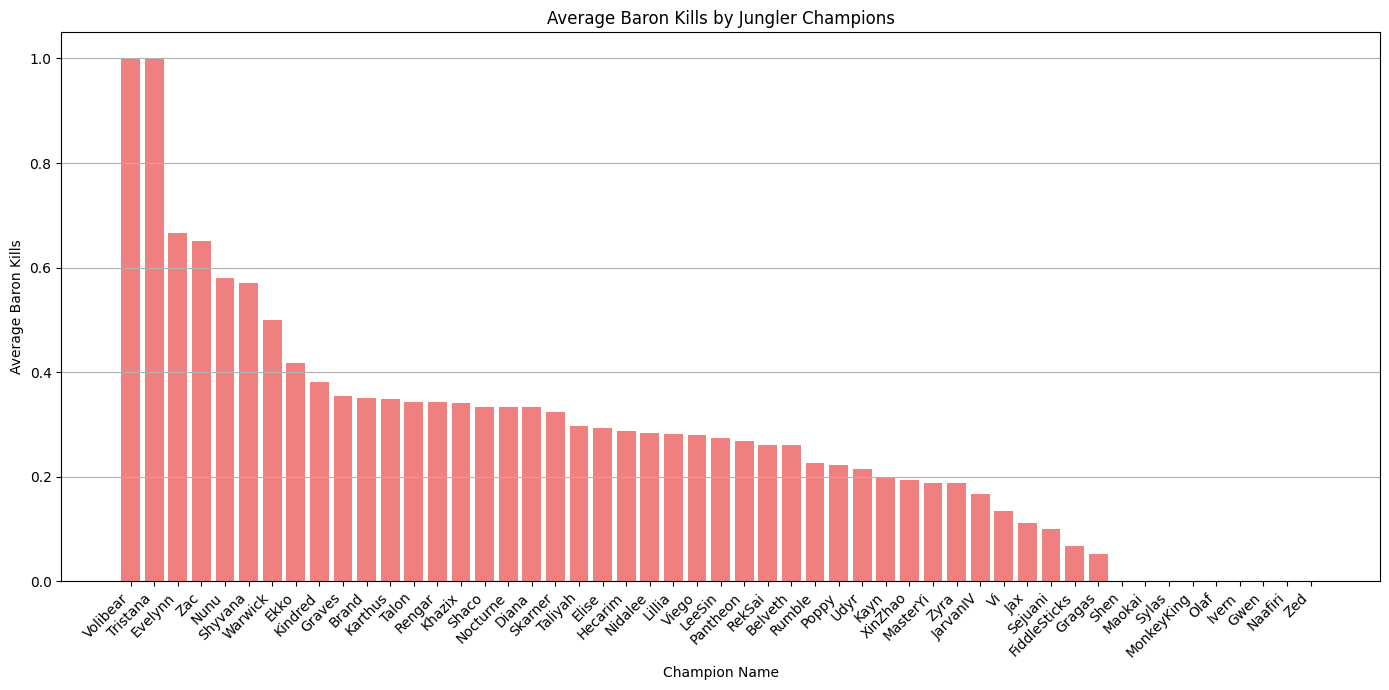

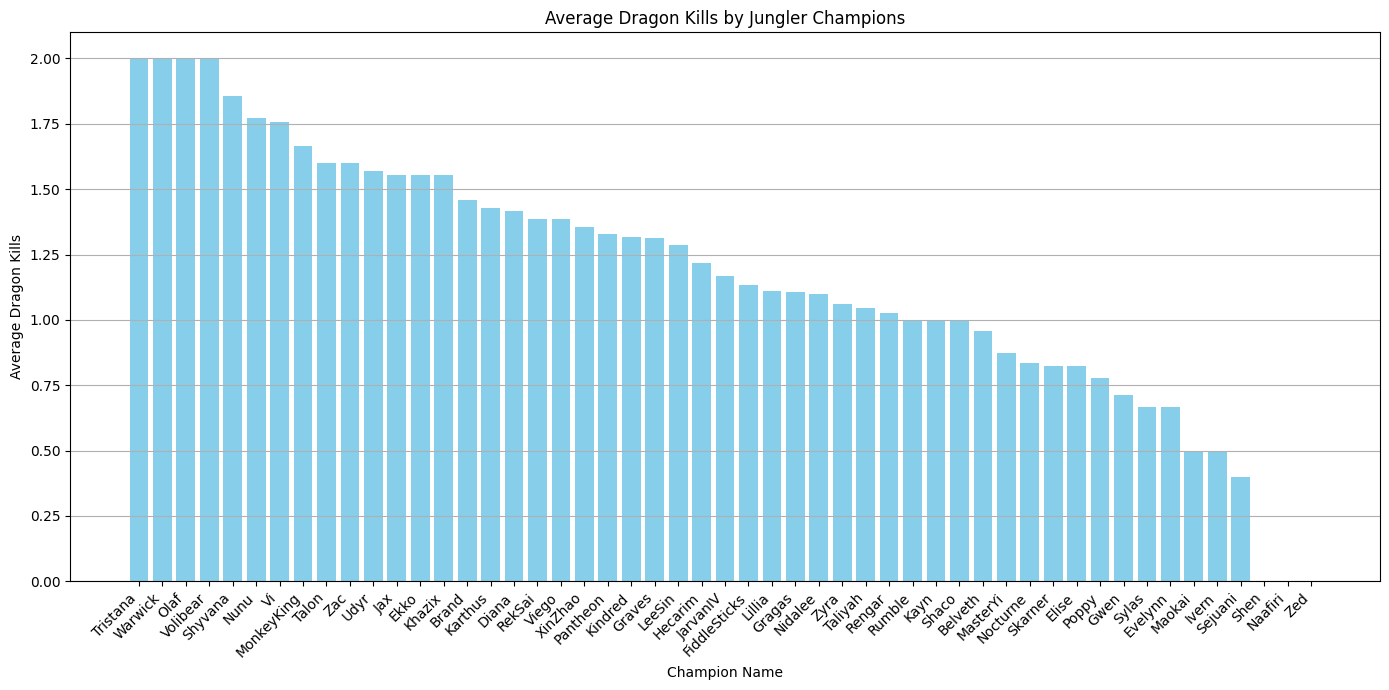

In [ ]:
# 정글 포지션의 챔피언별 바론과 드래곤 획득 횟수 계산
jungle_data = data[data['teamPosition_JUNGLE'] == 1]
champion_stats = jungle_data.groupby('championName').agg({
    'baronKills': 'mean',
    'dragonKills': 'mean'
}).reset_index()

# 바론 처치 횟수를 내림차순으로 정렬
champion_stats_baron = champion_stats.sort_values(by='baronKills', ascending=False)

# 드래곤 처치 횟수를 내림차순으로 정렬
champion_stats_dragon = champion_stats.sort_values(by='dragonKills', ascending=False)

# 바론 획득 횟수 시각화
plt.figure(figsize=(14, 7))
plt.bar(champion_stats_baron['championName'], champion_stats_baron['baronKills'], color='lightcoral')
plt.title('Average Baron Kills by Jungler Champions')
plt.xlabel('Champion Name')
plt.ylabel('Average Baron Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 드래곤 획득 횟수 시각화
plt.figure(figsize=(14, 7))
plt.bar(champion_stats_dragon['championName'], champion_stats_dragon['dragonKills'], color='skyblue')
plt.title('Average Dragon Kills by Jungler Champions')
plt.xlabel('Champion Name')
plt.ylabel('Average Dragon Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

결과를 나타낸 그래프 중 주 포지션이 정글이 아닌 챔피언이 있는 것 같다.

챔피언의 포지션 선호도를 조사해 정글로 20판 이상 플레이, 포지션 선호도 10% 이상 조건을 걸어 다시 해보기로 하였다.

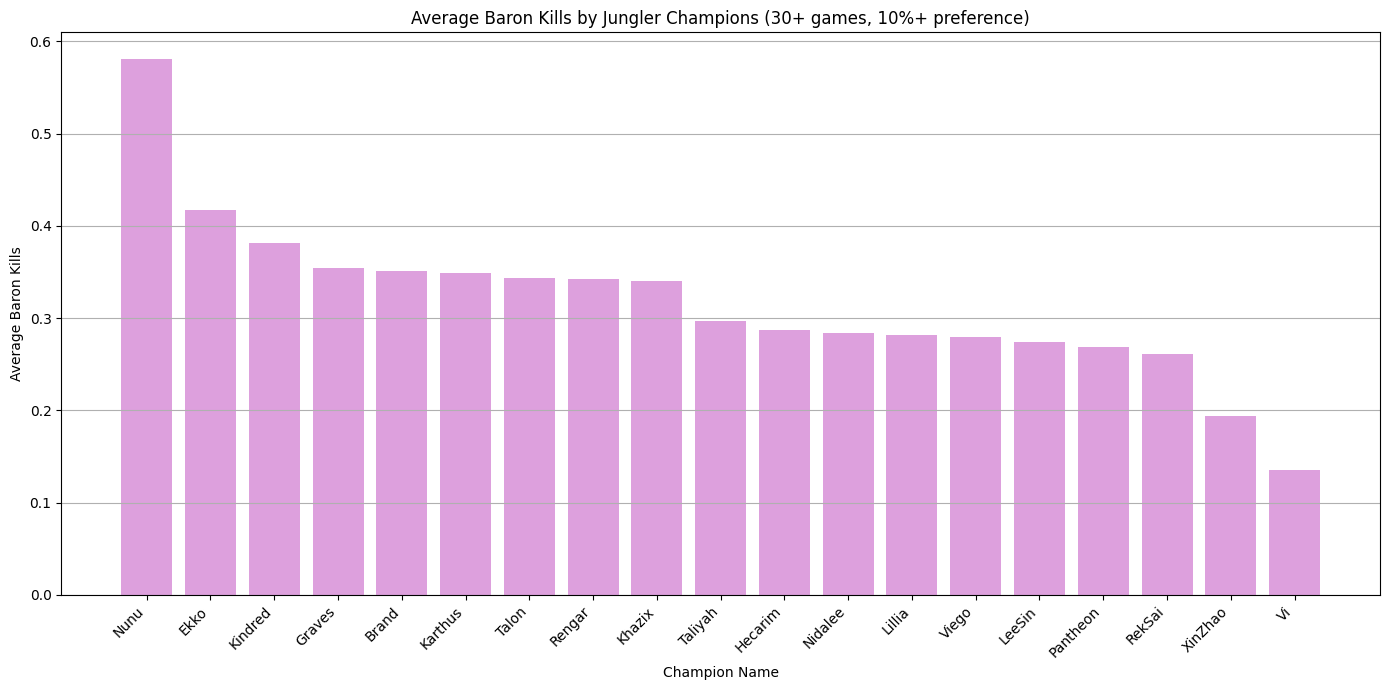

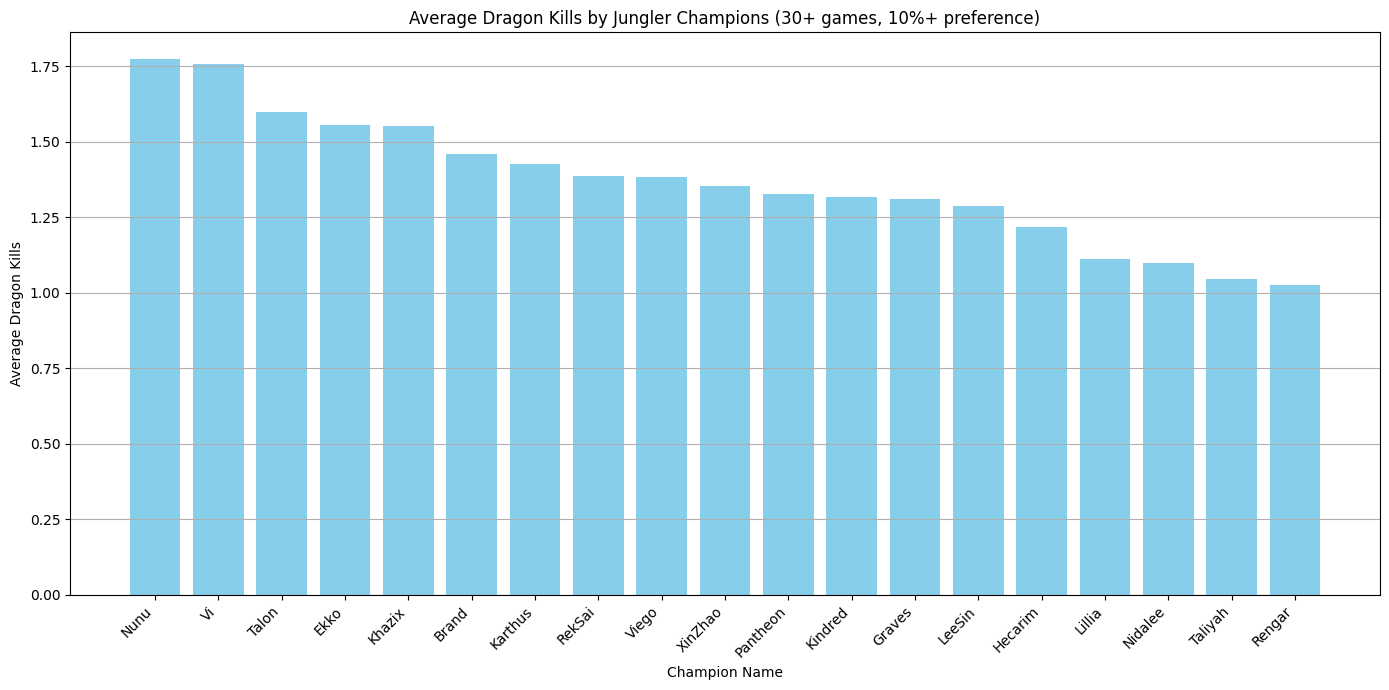

In [ ]:
# 정글 포지션의 데이터를 필터링
jungle_data = data[data['teamPosition_JUNGLE'] == 1]

# 각 챔피언별 포지션 선호도 계산
total_games = data.groupby('championName').size()
jungle_games = jungle_data.groupby('championName').size()
position_preference = (jungle_games / total_games).fillna(0) * 100

# 정글로 30판 이상 플레이하고 포지션 선호도가 10% 이상인 챔피언 필터링
qualified_champions = position_preference[(jungle_games >= 30) & (position_preference >= 10)].index

# 필터링된 챔피언 데이터
qualified_jungle_data = jungle_data[jungle_data['championName'].isin(qualified_champions)]

# 챔피언별 바론과 드래곤 획득 횟수 계산
champion_stats = qualified_jungle_data.groupby('championName').agg({
    'baronKills': 'mean',
    'dragonKills': 'mean'
}).reset_index()

# 바론 처치 횟수를 내림차순으로 정렬
champion_stats_baron = champion_stats.sort_values(by='baronKills', ascending=False)

# 드래곤 처치 횟수를 내림차순으로 정렬
champion_stats_dragon = champion_stats.sort_values(by='dragonKills', ascending=False)

# 바론 획득 횟수 시각화
plt.figure(figsize=(14, 7))
plt.bar(champion_stats_baron['championName'], champion_stats_baron['baronKills'], color='#DDA0DD')
plt.title('Average Baron Kills by Jungler Champions (30+ games, 10%+ preference)')
plt.xlabel('Champion Name')
plt.ylabel('Average Baron Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 드래곤 획득 횟수 시각화
plt.figure(figsize=(14, 7))
plt.bar(champion_stats_dragon['championName'], champion_stats_dragon['dragonKills'], color='skyblue')
plt.title('Average Dragon Kills by Jungler Champions (30+ games, 10%+ preference)')
plt.xlabel('Champion Name')
plt.ylabel('Average Dragon Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


정글로 30판 이상 플레이된 챔피언과 바론, 드래곤 획득량이 높은 정글 챔피언 10개를 비교하여 오브젝트 획득 능력이 높은 챔피언이 승률이 높은지 가설을 점검한다

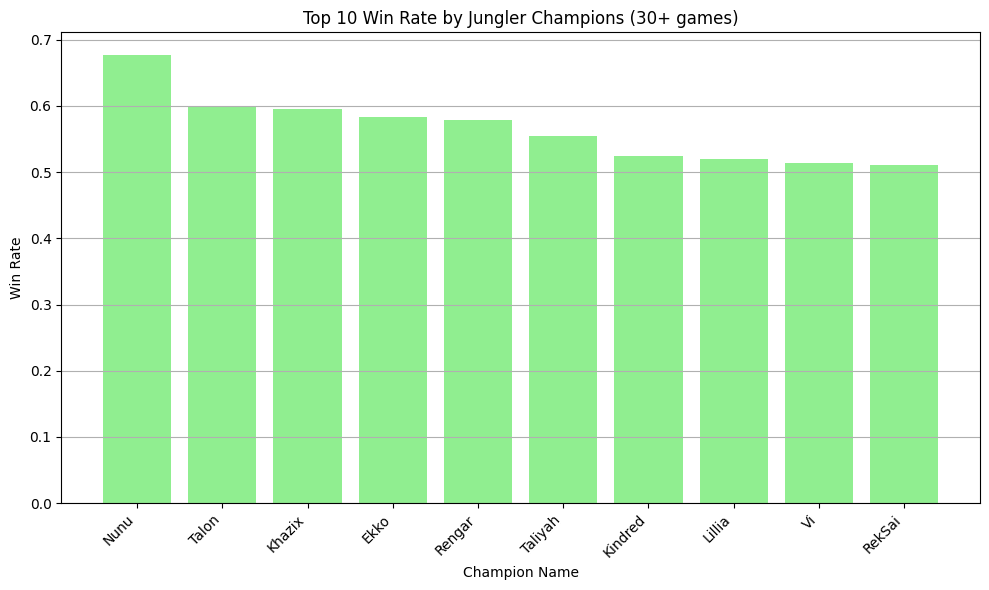

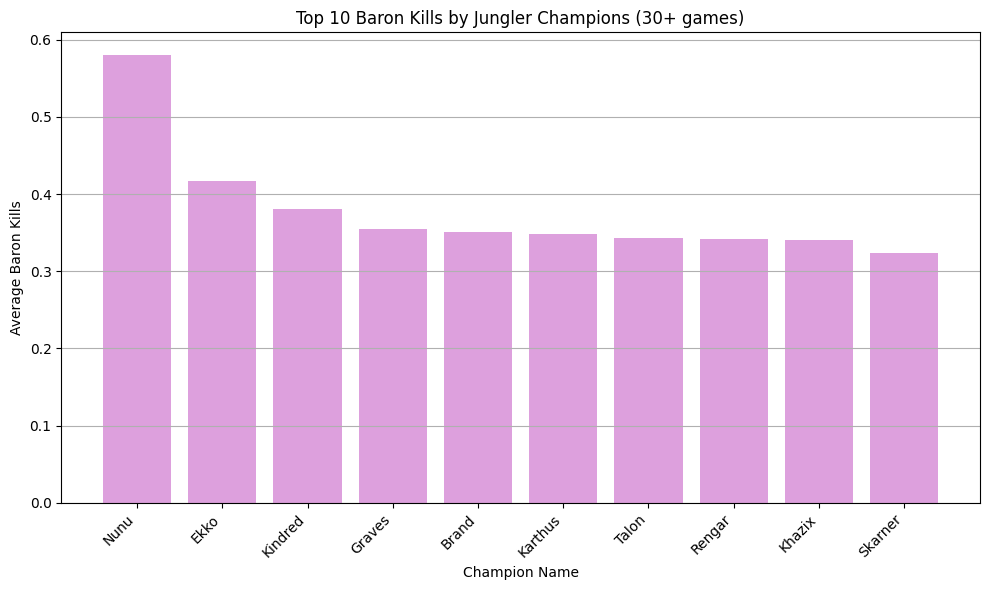

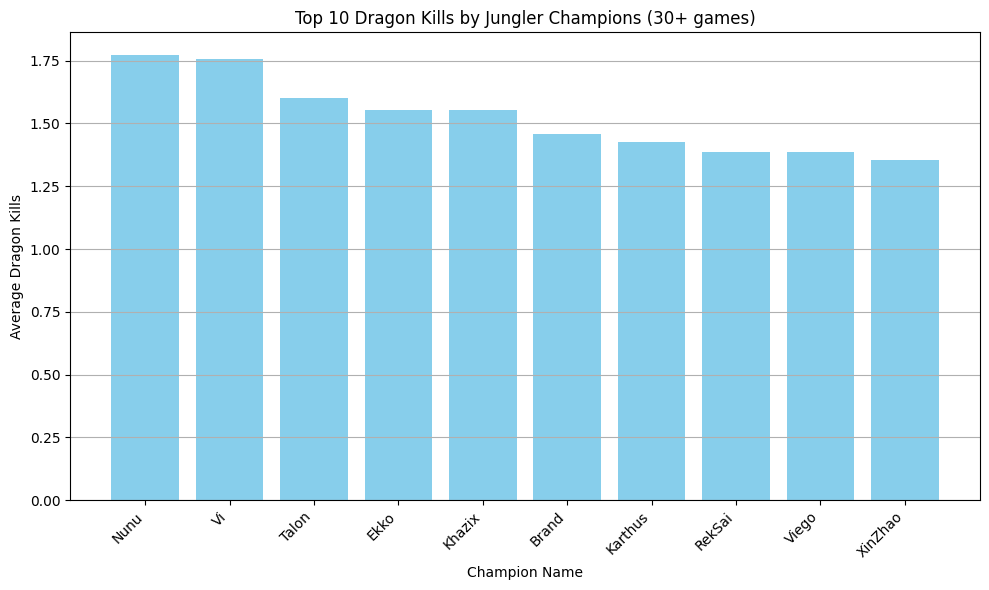

In [ ]:

# 정글 포지션의 데이터를 필터링
jungle_data = data[data['teamPosition_JUNGLE'] == 1]

# 각 챔피언별 포지션 선호도 계산
total_games = data.groupby('championName').size()
jungle_games = jungle_data.groupby('championName').size()

# 정글로 30판 이상 플레이된 챔피언 필터링
qualified_jungle_champions = jungle_games[jungle_games >= 30].index

# 필터링된 챔피언 데이터
qualified_jungle_data = jungle_data[jungle_data['championName'].isin(qualified_jungle_champions)]

# 챔피언별 승률 계산
win_rate = qualified_jungle_data.groupby('championName')['win'].mean().reset_index()
win_rate.columns = ['championName', 'winRate']

# 챔피언별 바론과 드래곤 획득 횟수 계산
champion_stats = qualified_jungle_data.groupby('championName').agg({
    'baronKills': 'mean',
    'dragonKills': 'mean'
}).reset_index()

# 승률 상위 10명
top10_win_rate = win_rate.sort_values(by='winRate', ascending=False).head(10)
# 바론 획득량 상위 10명
top10_baron_kills = champion_stats.sort_values(by='baronKills', ascending=False).head(10)
# 드래곤 획득량 상위 10명
top10_dragon_kills = champion_stats.sort_values(by='dragonKills', ascending=False).head(10)

# 승률 상위 10명 시각화
plt.figure(figsize=(10,6))
plt.bar(top10_win_rate['championName'], top10_win_rate['winRate'], color='lightgreen')
plt.title('Top 10 Win Rate by Jungler Champions (30+ games)')
plt.xlabel('Champion Name')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 바론 획득량 상위 10명 시각화
plt.figure(figsize=(10,6))
plt.bar(top10_baron_kills['championName'], top10_baron_kills['baronKills'], color='#DDA0DD')
plt.title('Top 10 Baron Kills by Jungler Champions (30+ games)')
plt.xlabel('Champion Name')
plt.ylabel('Average Baron Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 드래곤 획득량 상위 10명 시각화
plt.figure(figsize=(10,6))
plt.bar(top10_dragon_kills['championName'], top10_dragon_kills['dragonKills'], color='skyblue')
plt.title('Top 10 Dragon Kills by Jungler Champions (30+ games)')
plt.xlabel('Champion Name')
plt.ylabel('Average Dragon Kills')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
common_champions_withbaron = set(top10_win_rate['championName']).intersection(set(top10_baron_kills['championName']))

# 결과 출력
print(f"Common champions in top 10 win rate and top 10 baron kills: {common_champions}")
print(f"Number of common champions: {len(common_champions_withbaron)}")

Common champions in top 10 win rate and top 10 baron kills: {'Ekko', 'RekSai', 'Vi', 'Khazix', 'Nunu', 'Talon'}
Number of common champions: 6


In [ ]:
common_champions_withdragon = set(top10_win_rate['championName']).intersection(set(top10_dragon_kills['championName']))

# 결과 출력
print(f"Common champions in top 10 win rate and top 10 dragon kills: {common_champions}")
print(f"Number of common champions: {len(common_champions_withdragon)}")

Common champions in top 10 win rate and top 10 dragon kills: {'Ekko', 'RekSai', 'Vi', 'Khazix', 'Nunu', 'Talon'}
Number of common champions: 6


용, 바론 처치 top 10개의 챔피언중 6개의 챔피언이 승률과 오브젝트 획득률이 모두 높게 나오므로

오브젝트 획득률과 승률이 관계있다는 가설을 입증할 수 있었다.

#### **가설: visionScore가 천상계 게임 승리에서 가장 중요한 요인일 것이다.**

시야 점수가 높으면 맵의 가용성이 높아지기에 승률이 더 높아질 것이다. 가설을 입증하기 위해 먼저 상관관계 분석을 진행해본다.

In [ ]:
# 와드와 관계되어 있는 지표인 'visionScore', 'visionWardsBoughtInGame', 'wardsKilled',
# 'wardsPlaced'에 대한 지표를 확인해보자. 먼저 describe()를 통해 전체적인 지표를 확인한다.
ward_data = df[['wardsPlaced', 'wardsKilled', 'visionScore',
                  'visionWardsBoughtInGame', 'win']]
ward_data.describe()

wardsPlaced   wardsKilled   visionScore  visionWardsBoughtInGame  \
count  12499.000000  12499.000000  12499.000000             12499.000000   
mean      12.922874      5.021682     31.103608                 3.947436   
std       13.647412      4.376861     25.836603                 3.957997   
min        0.000000      0.000000      0.000000                 0.000000   
25%        6.000000      2.000000     15.000000                 1.000000   
50%        8.000000      4.000000     23.000000                 3.000000   
75%       13.000000      7.000000     36.000000                 5.000000   
max      133.000000     42.000000    209.000000                39.000000   

               win  
count  12499.00000  
mean       0.50004  
std        0.50002  
min        0.00000  
25%        0.00000  
50%        1.00000  
75%        1.00000  
max        1.00000

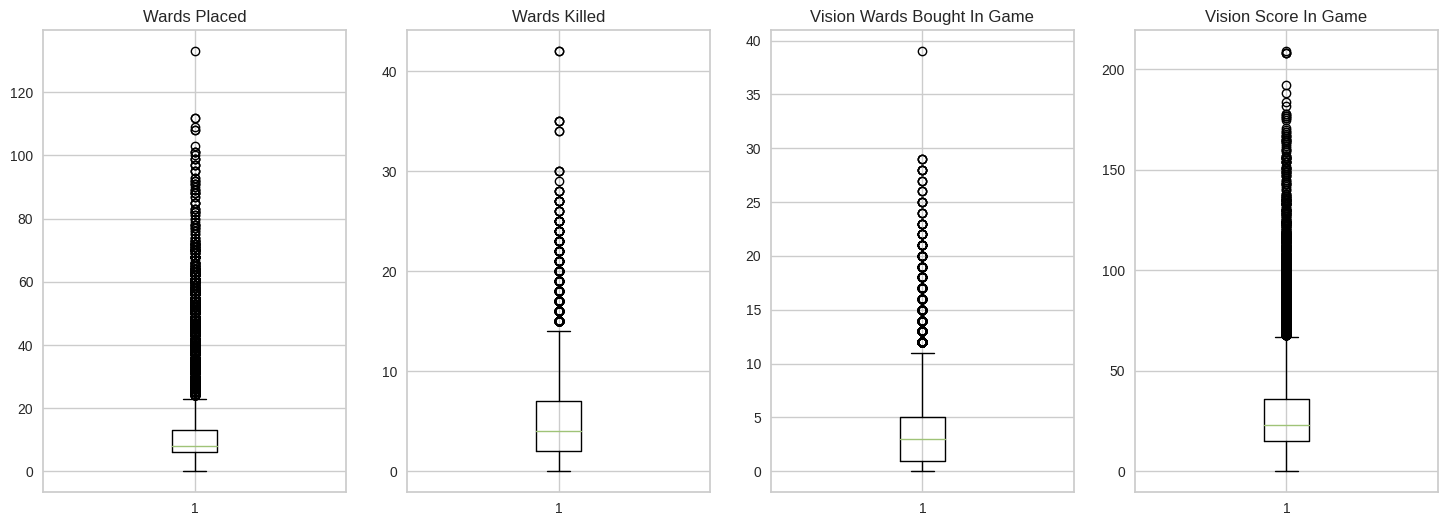

In [ ]:
# 와드가 0개에서 133개까지 설치된 경우 등 이상치 일수도 있는 것들이 확인된다.
# Boxplot을 그려 시각화를 통해 확인해보자.
# 이상치 확인을 위한 박스플롯 생성
fig, ax = plt.subplots(1, 4, figsize=(18, 6))

ax[0].boxplot(ward_data['wardsPlaced'])
ax[0].set_title('Wards Placed')

ax[1].boxplot(ward_data['wardsKilled'])
ax[1].set_title('Wards Killed')

ax[2].boxplot(ward_data['visionWardsBoughtInGame'])
ax[2].set_title('Vision Wards Bought In Game')

ax[3].boxplot(ward_data['visionScore'])
ax[3].set_title('Vision Score In Game')

plt.show()

In [ ]:
# 확실히 이상치가 확인된다. 따라서 95% 이상의 값만 제한해서 이상치를 제거해보자.
percentile_95 = ward_data.quantile(0.95)

# 상한 값으로 이상치 제한
ward_data['wardsPlaced'] = ward_data['wardsPlaced'].clip(upper=percentile_95 \
                                                        ['wardsPlaced'])
ward_data['visionWardsBoughtInGame'] = ward_data['visionWardsBoughtInGame'] \
                                      .clip(upper=percentile_95 \
                                       ['visionWardsBoughtInGame'])
ward_data['wardsKilled'] = ward_data['wardsKilled'].clip(upper=percentile_95 \
                                                        ['wardsKilled'])
ward_data['visionScore'] = ward_data['visionScore'].clip(upper=percentile_95 \
                                                        ['visionScore'])

# 이상치 처리 후의 기초 통계량 다시 확인
ward_data.describe()

<ipython-input-20-493c8449f204>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_data['wardsPlaced'] = ward_data['wardsPlaced'].clip(upper=percentile_95 \
<ipython-input-20-493c8449f204>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_data['visionWardsBoughtInGame'] = ward_data['visionWardsBoughtInGame'] \
<ipython-input-20-493c8449f204>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

wardsPlaced   wardsKilled   visionScore  visionWardsBoughtInGame  \
count  12499.000000  12499.000000  12499.000000             12499.000000   
mean      12.229058      4.797344     29.882631                 3.762061   
std       11.117382      3.699352     21.682124                 3.370259   
min        0.000000      0.000000      0.000000                 0.000000   
25%        6.000000      2.000000     15.000000                 1.000000   
50%        8.000000      4.000000     23.000000                 3.000000   
75%       13.000000      7.000000     36.000000                 5.000000   
max       44.000000     13.000000     88.000000                12.000000   

               win  
count  12499.00000  
mean       0.50004  
std        0.50002  
min        0.00000  
25%        0.00000  
50%        1.00000  
75%        1.00000  
max        1.00000

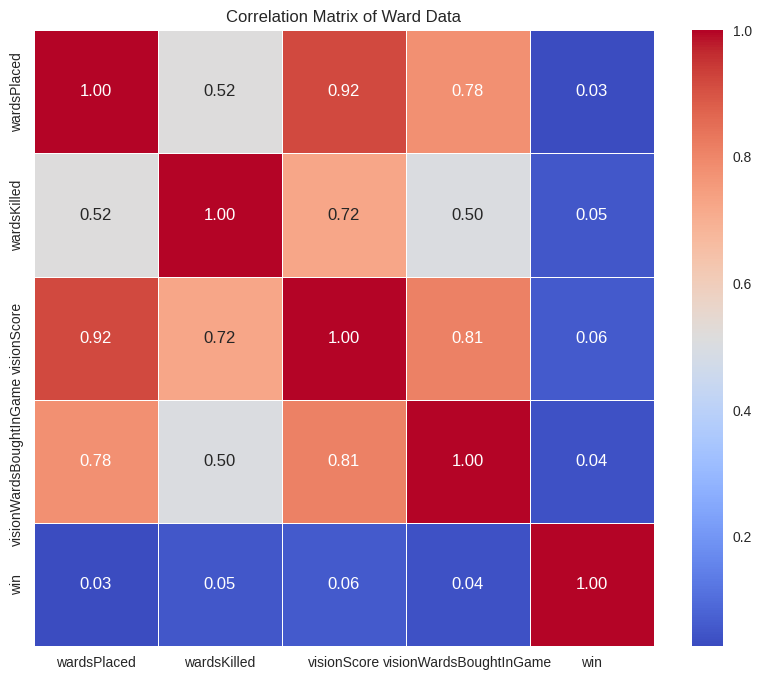

In [ ]:
# 다음으로 상관관계를 시각화 해보자.
correlation_matrix = ward_data.corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix of Ward Data")
plt.show()

생각보다 시야는 큰 영향을 주지 않았다. 더 정확한 요인 분석이 필요하다고 생각된다. 다른 요인이 어떤 것이 있을지 상관관계 지표를 그려보자.
먼저 데이터간 중복되는 컬럼들이 있는것 같다. 이 지표들을 확인해보자.

### **상관관계 행렬 (Correlation Matrix)을 통한 데이터 전처리**

더욱 정확한 요인을 분석해 보고 승리 예측도 해보기 위해 머신 러닝 모델을 사용해보기로 결정했다. 선택한 모델은 **Logistic Regression**, **Random Forest**, **Light Gradient Boosting Model**로 진행해보기로 결정했다. 모델에 집어 넣을 변수를 분류하기 위해 먼저 상관관계 행렬을 그려 변수간 상관관계를 파악한다.

In [ ]:
# 중복될수도 있는 데이터들이 있기에 상관관계 지표를 그려 어떤것을 걸러낼지 골라본다.
variables = ['damageDealtToObjectives', 'damageDealtToBuildings',
             'damageDealtToTurrets', 'turretKills', 'inhibitorKills',
             'inhibitorTakedowns', 'inhibitorsLost', 'totalDamageDealt',
             'totalDamageDealtToChampions', 'trueDamageDealt',
             'totalTimeSpentDead', 'visionScore', 'detectorWardsPlaced',
             'wardsKilled', 'firstBloodKill', 'firstBloodAssist',
             'firstTowerKill', 'firstTowerAssist', 'champExperience',
             'champLevel', 'trueDamageTaken', 'itemsPurchased',
             'consumablesPurchased', 'timeCCingOthers',
             'totalTimeCCDealt']

In [ ]:
# 변수간 완전히 독립적일수는 없겠지만 너무 상관있는것은 다중공산성으로 인하여 정확한 요인 확인이 불가능하다.
# 따라서 0.7 이상 변수가 관계 있다면 제외하기로 결정했다.
correlation_matrix = df[variables].corr()
filtered_correlation = correlation_matrix[correlation_matrix >= 0.7].notna()

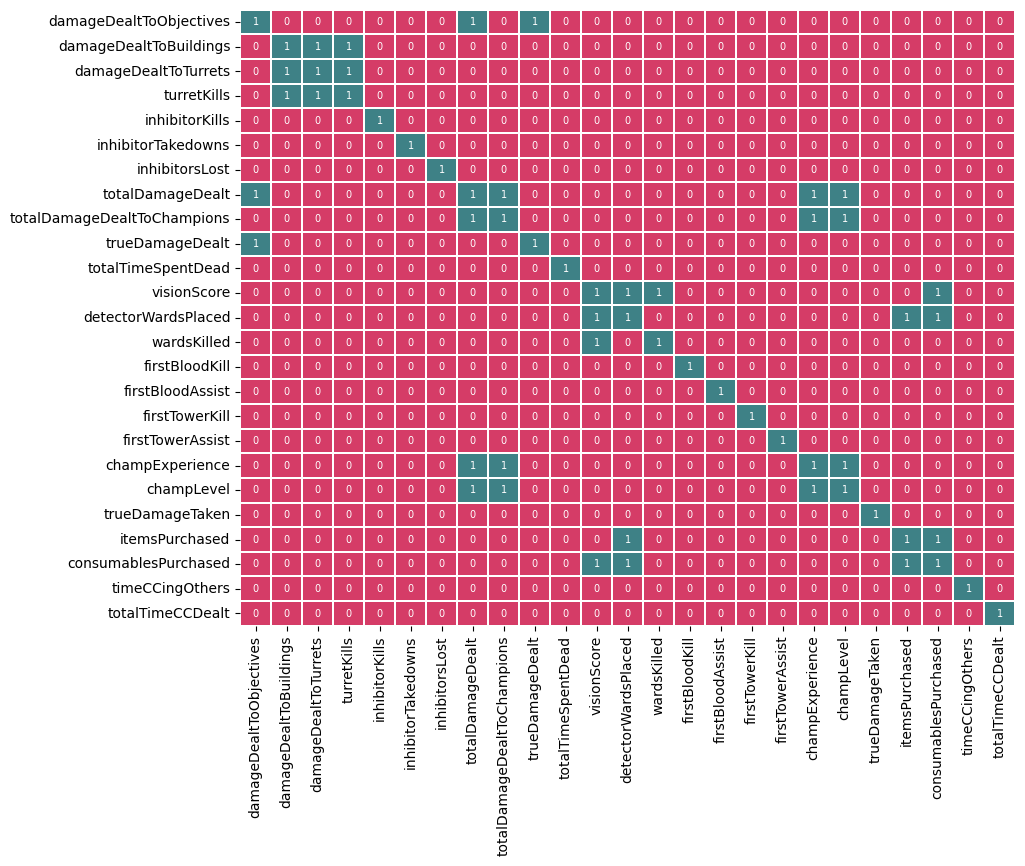

In [ ]:
# 0.7 이상의 상관관계를 갖고 있는 경우 1, 아닐경우 0으로 하여 상관관계 행렬로 시각화
plt.figure(figsize = (10, 8))

# Plot the Correlation Matrix
cmap = sns.diverging_palette(1, 200, as_cmap = True)
sns.heatmap(filtered_correlation, cmap = cmap, annot = True,
            annot_kws = {"size": 7}, linewidths = 0.1, cbar = False)
plt.show()

In [ ]:
# 다음과 같은 컬럼들이 서로 비슷한 변수들이라고 판단되어 drop하기로 결정했다.
# 또한 inhibitor 지표가 3가지나 있어 3개중에 inhibitorTakedowns 변수를 가져가기로 결정했다.
# 요인분석에서 플레이어 포지션 지표는 필요 없을 것이라고 판단되어 같이 드랍하였다.
df.drop(['damageDealtToBuildings', 'damageDealtToTurrets',
         'champExperience', 'totalDamageDealtToChampions',
         'consumablesPurchased', 'detectorWardsPlaced',
         'visionWardsBoughtInGame', 'wardsKilled',
         'inhibitorKills', 'inhibitorsLost',
         'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
         'teamPosition_MIDDLE', 'teamPosition_TOP',
         'teamPosition_UTILITY'],
        axis=1, inplace=True)
df

baronKills  bountyLevel  champLevel  damageDealtToObjectives  \
0               0            2          13                     2695   
1               0            2          14                    20445   
2               0            1          14                     3304   
3               0            0          12                        0   
4               0            5          13                     1643   
...           ...          ...         ...                      ...   
12475           0            0          15                     3066   
12476           0            7          14                    19809   
12477           1            0          14                    15486   
12478           0           10          14                    18473   
12479           0            2          13                     1320   

       damageSelfMitigated  dragonKills  firstBloodAssist  firstBloodKill  \
0                    14517            0                 0               0   
1                    19762            1                 0               1   
2                     8710            0                 0               0   
3                     7828            0                 0               0   
4                     5932            0                 0               0   
...                    ...          ...               ...             ...   
12475                20221            0                 0               0   
12476                15614            2                 0               1   
12477                 7272            0                 1               0   
12478                12892            0                 1               0   
12479                 2867            0                 1               0   

       firstTowerAssist  firstTowerKill  ...  totalTimeSpentDead  \
0                     0               0  ...                  33   
1                     0               0  ...                 109   
2                     0               1  ...                  75   
3                     0               0  ...                  69   
4                     0               0  ...                  81   
...                 ...             ...  ...                 ...   
12475                 0               0  ...                 194   
12476                 0               0  ...                  28   
12477                 0               0  ...                  90   
12478                 0               0  ...                  32   
12479                 0               0  ...                  33   

       totalUnitsHealed  trueDamageDealt  trueDamageDealtToChampions  \
0                     1              590                         226   
1                     1            60103                         412   
2                     1             2766                          75   
3                     5             1716                        1006   
4                     1              834                         482   
...                 ...              ...                         ...   
12475                 1              498                          90   
12476                 1            34855                         690   
12477                 1              675                          84   
12478                 1            31674                         346   
12479                 4             1763                         660   

       trueDamageTaken  turretKills  visionScore  wardsPlaced  win  totalPing  
0                 2588            0           19            6    1         17  
1                 1365            1            7            2    1         29  
2                  683            2           18            9    1         25  
3                  853            0           79           37    1         72  
4                 1347            1           17            9    1         15  
...                ...          ...          ...          ...  ... 

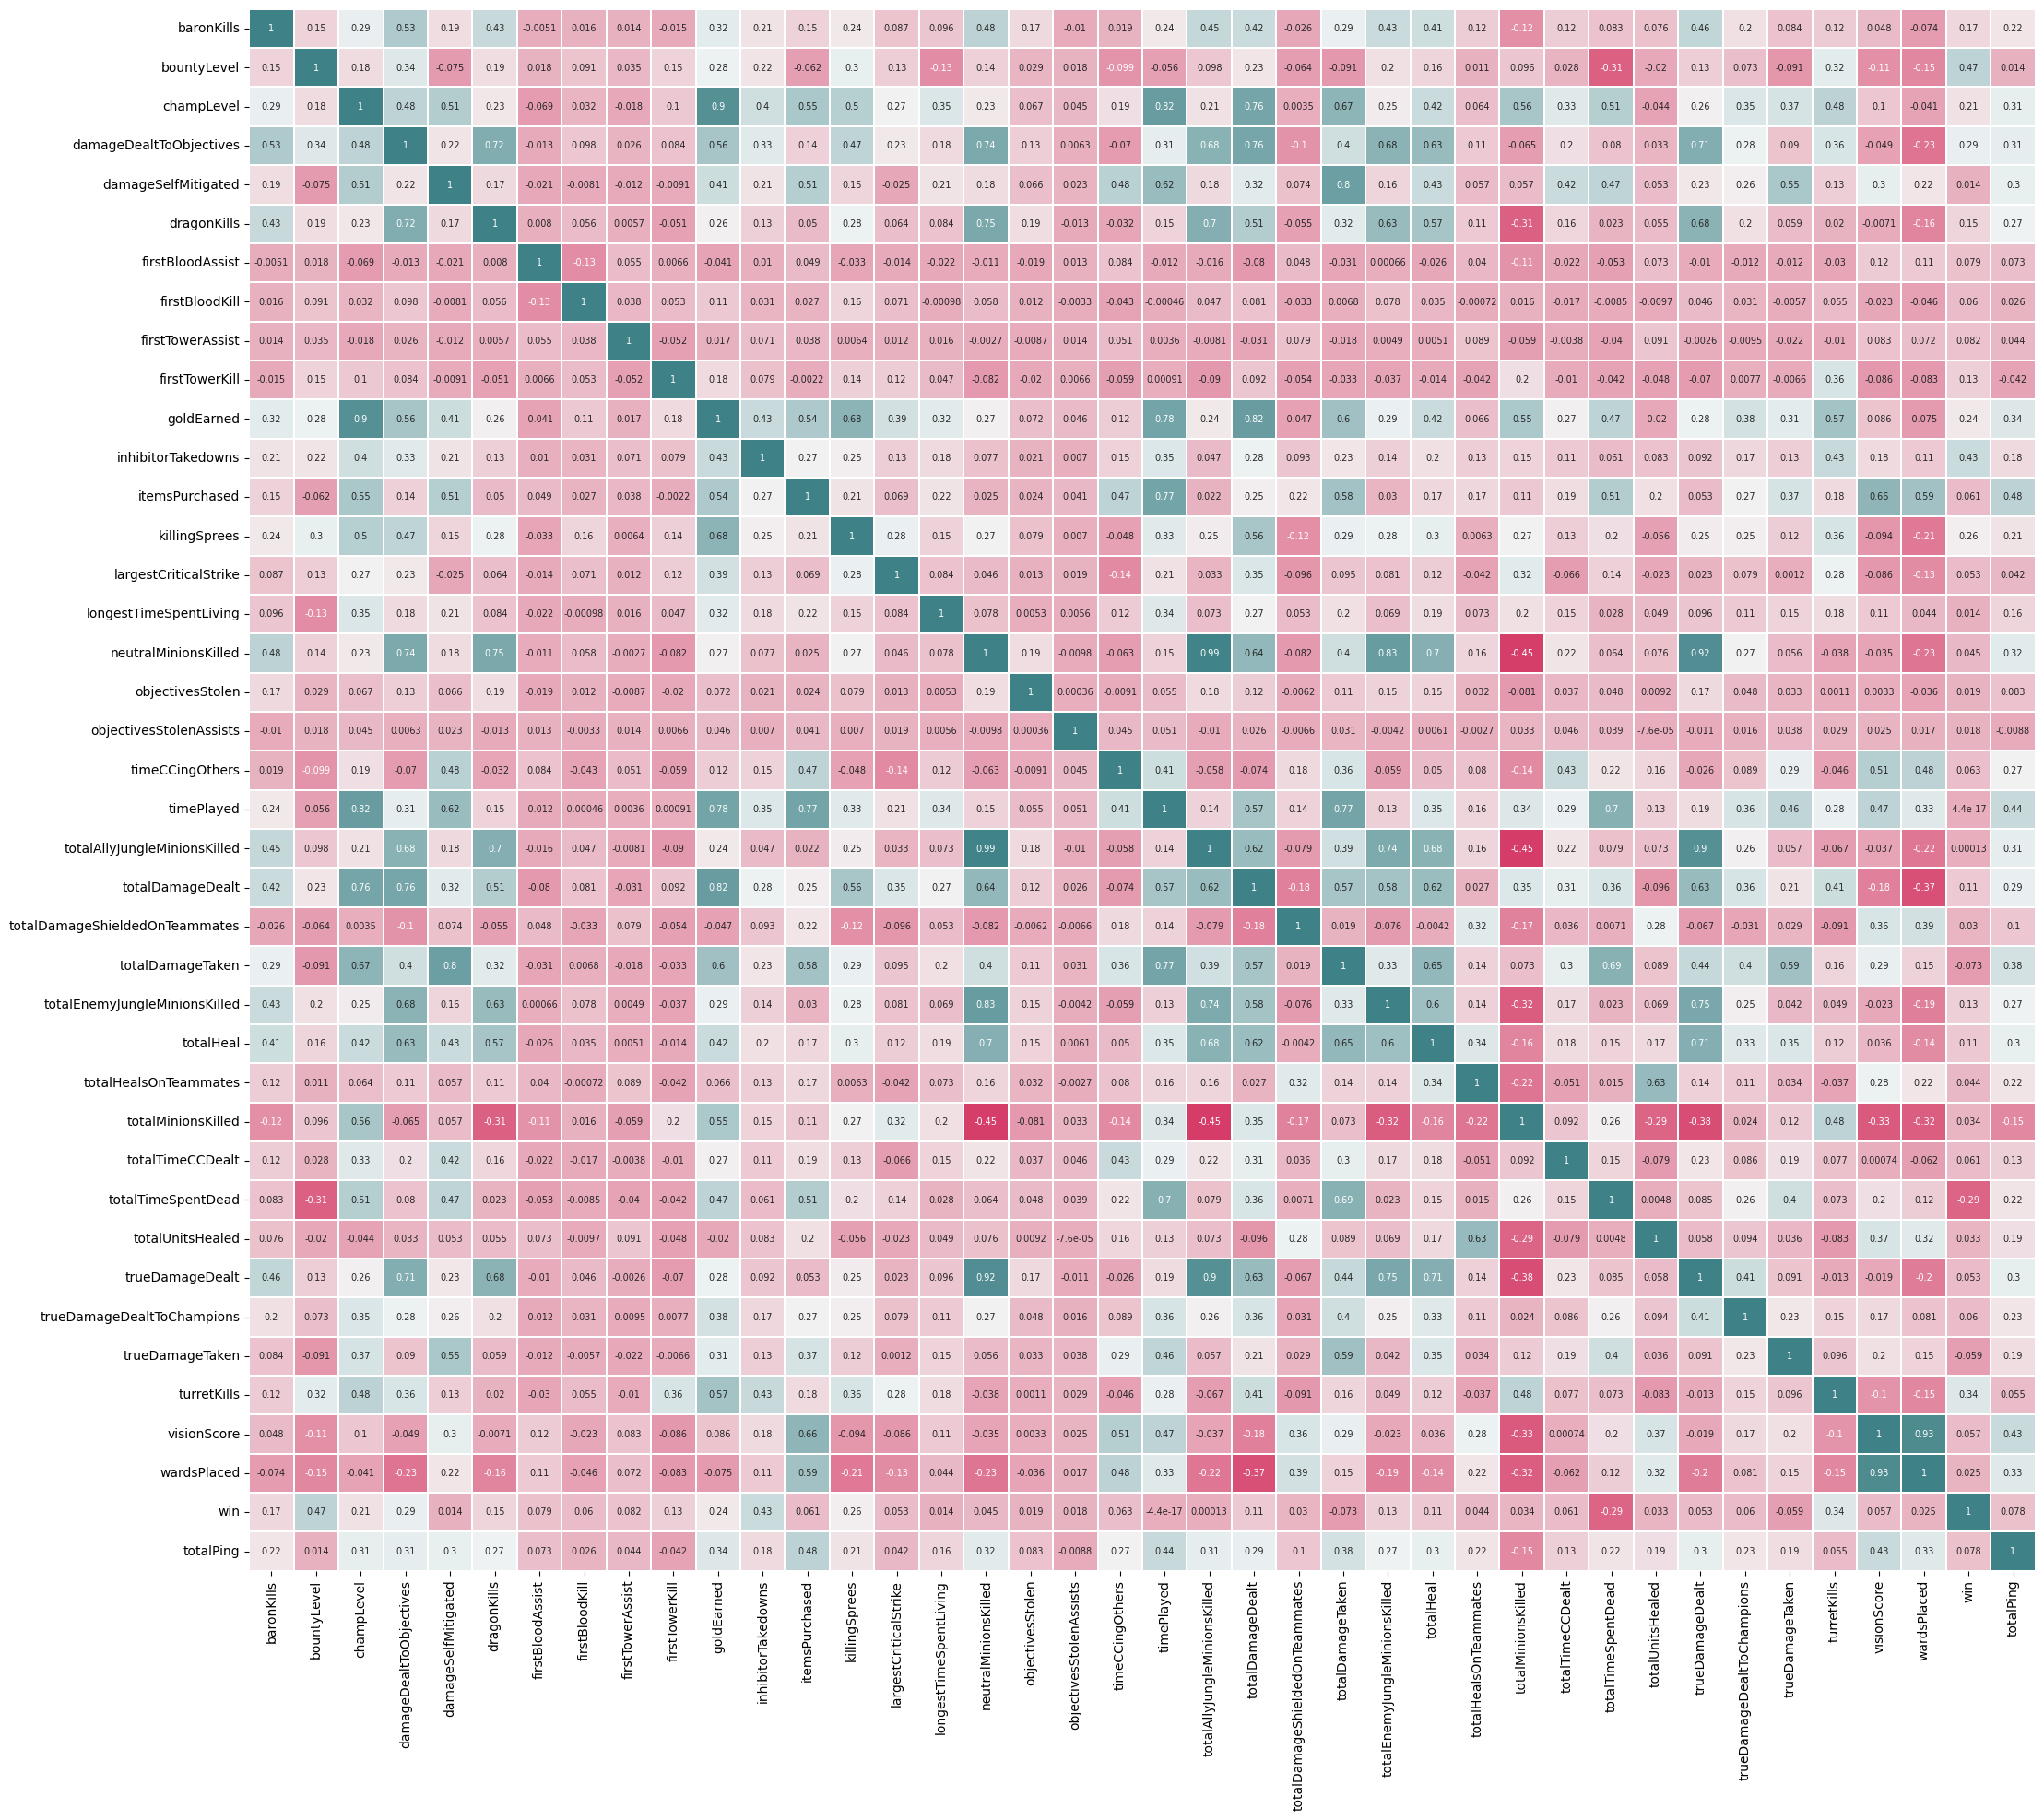

In [ ]:
# 다시한번 상관관계 지표를 확인해본다.
# Set Figure Size
plt.figure(figsize = (25, 22))

# Plot the Correlation Matrix
cmap = sns.diverging_palette(1, 200, as_cmap = True)
sns.heatmap(df.corr(), cmap = cmap, annot = True, annot_kws = {"size": 7}, linewidths = 0.1, cbar = False)
plt.show()

In [ ]:
# Feature들을 0.1이상의 상관관계가 있을경우 분석에 포함하기로 결정했다.
correlation_matrix = df.corr()
filtered_correlation = correlation_matrix[((correlation_matrix <= -0.1) |
                                          (correlation_matrix >= 0.1)) &
                                          (correlation_matrix != 1)]

In [ ]:
filtered_correlation[filtered_correlation['win'].notna()]['win'].round(2)

baronKills                       0.17
bountyLevel                      0.47
champLevel                       0.21
damageDealtToObjectives          0.29
dragonKills                      0.15
firstTowerKill                   0.13
goldEarned                       0.24
inhibitorTakedowns               0.43
killingSprees                    0.26
totalDamageDealt                 0.11
totalEnemyJungleMinionsKilled    0.13
totalHeal                        0.11
totalTimeSpentDead              -0.29
turretKills                      0.34
Name: win, dtype: float64

In [ ]:
# 필터링할 컬럼 지정
column_to_filter = ['baronKills', 'bountyLevel', 'champLevel',
                    'damageDealtToObjectives','dragonKills', 'firstTowerKill',
                    'goldEarned', 'inhibitorTakedowns', 'killingSprees',
                    'totalDamageDealt', 'totalEnemyJungleMinionsKilled',
                    'totalHeal', 'totalTimeSpentDead', 'turretKills', 'win']

In [ ]:
# 지정한 컬럼들로 데이터프레임 필터링
df = df[column_to_filter]

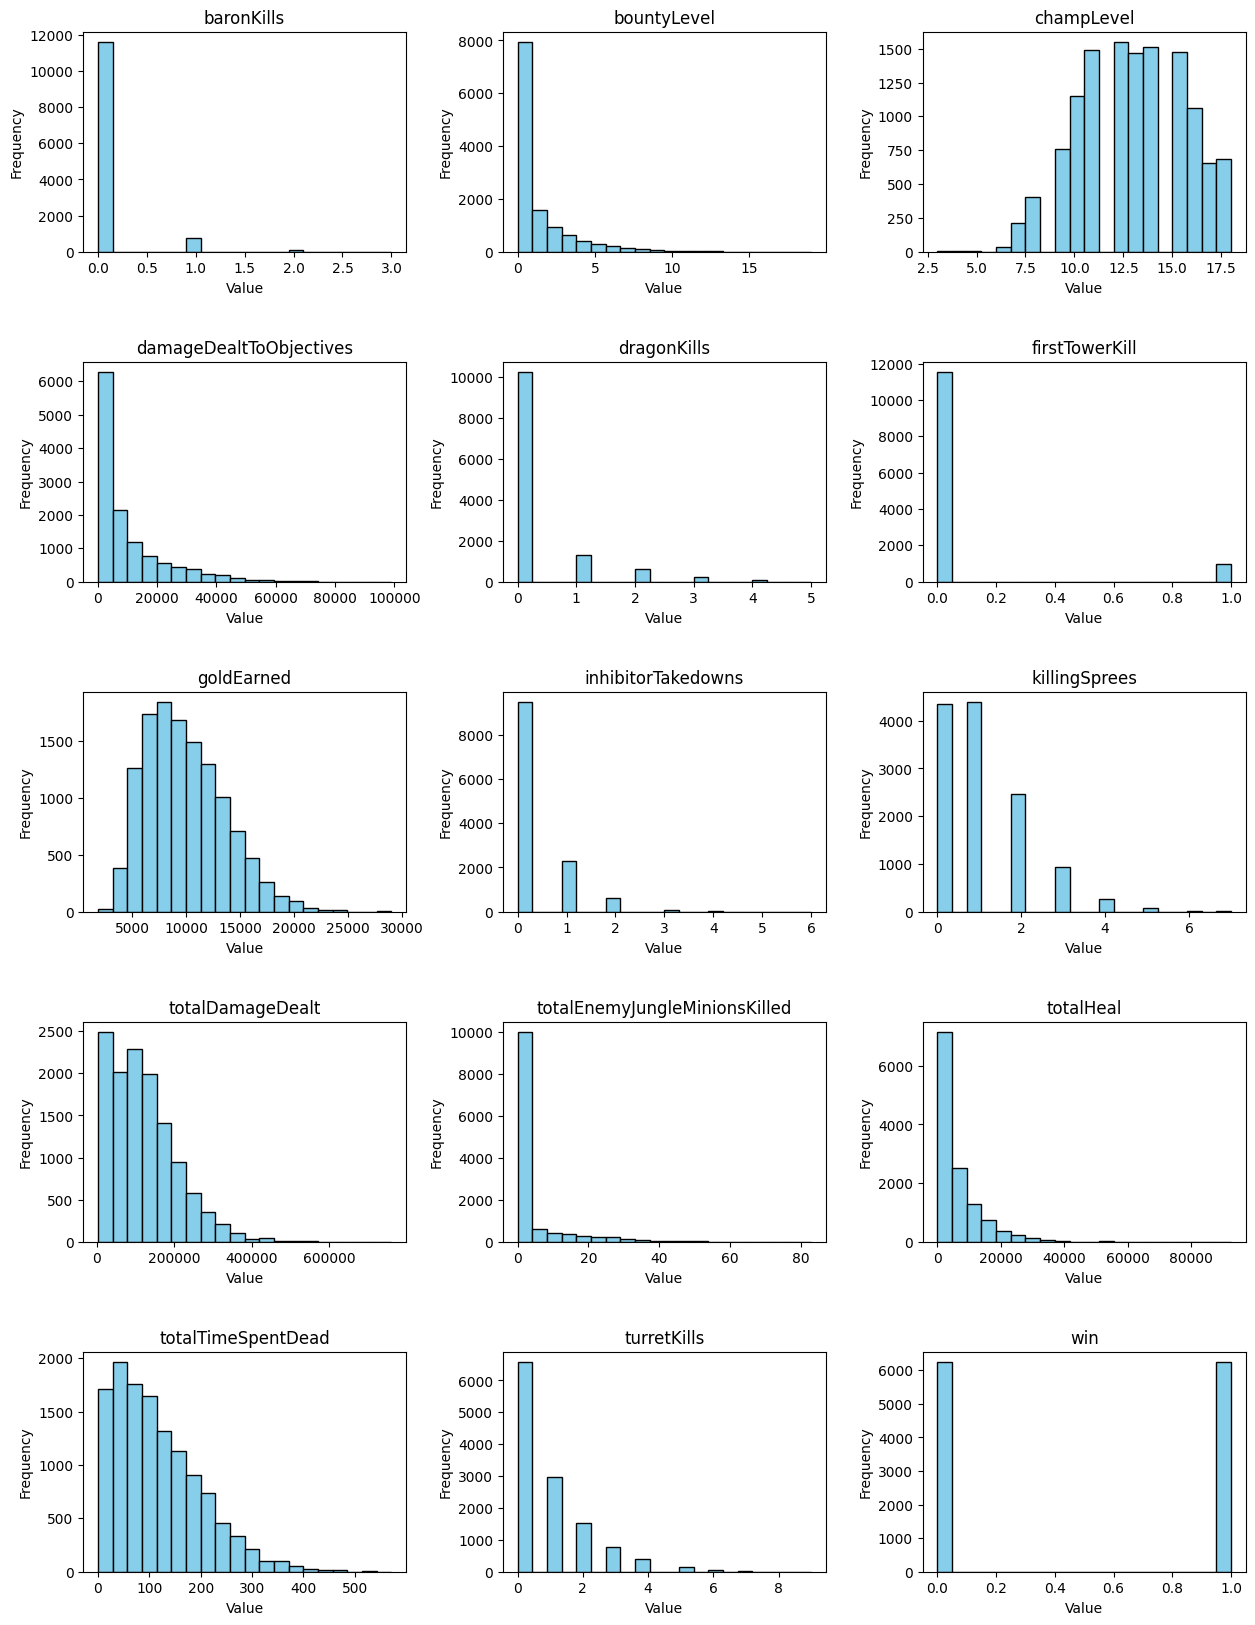

In [ ]:
# Feature들의 Histogram을 그려 전체적인 데이터의 분포를 확인한다.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Assigning columns to subplots
for ax, column in zip(axes.flatten(), df.columns):
    ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

In [ ]:
#히스토그램과 박스플롯을 통해서 이상하다고 생각되는 feature를 가져와서 왜도 보기
#Skewness가 절댓값 1을 넘으면 정규분포에 벗어난 것이라고 한다.
unbal = ['baronKills','bountyLevel','dragonKills','damageDealtToObjectives',
         'totalEnemyJungleMinionsKilled','totalHeal','totalDamageDealt',
         'inhibitorTakedowns', 'turretKills']

for un in unbal:
    print(un, "Skew :", df[un].skew())

baronKills Skew : 4.216166763103491
bountyLevel Skew : 2.7422827532617444
dragonKills Skew : 2.7603642264231425
damageDealtToObjectives Skew : 1.9329535393022386
totalEnemyJungleMinionsKilled Skew : 2.892964747177504
totalHeal Skew : 2.669878056058085
totalDamageDealt Skew : 1.0038769667738396
inhibitorTakedowns Skew : 2.2996408378887656
turretKills Skew : 1.6958448475226813


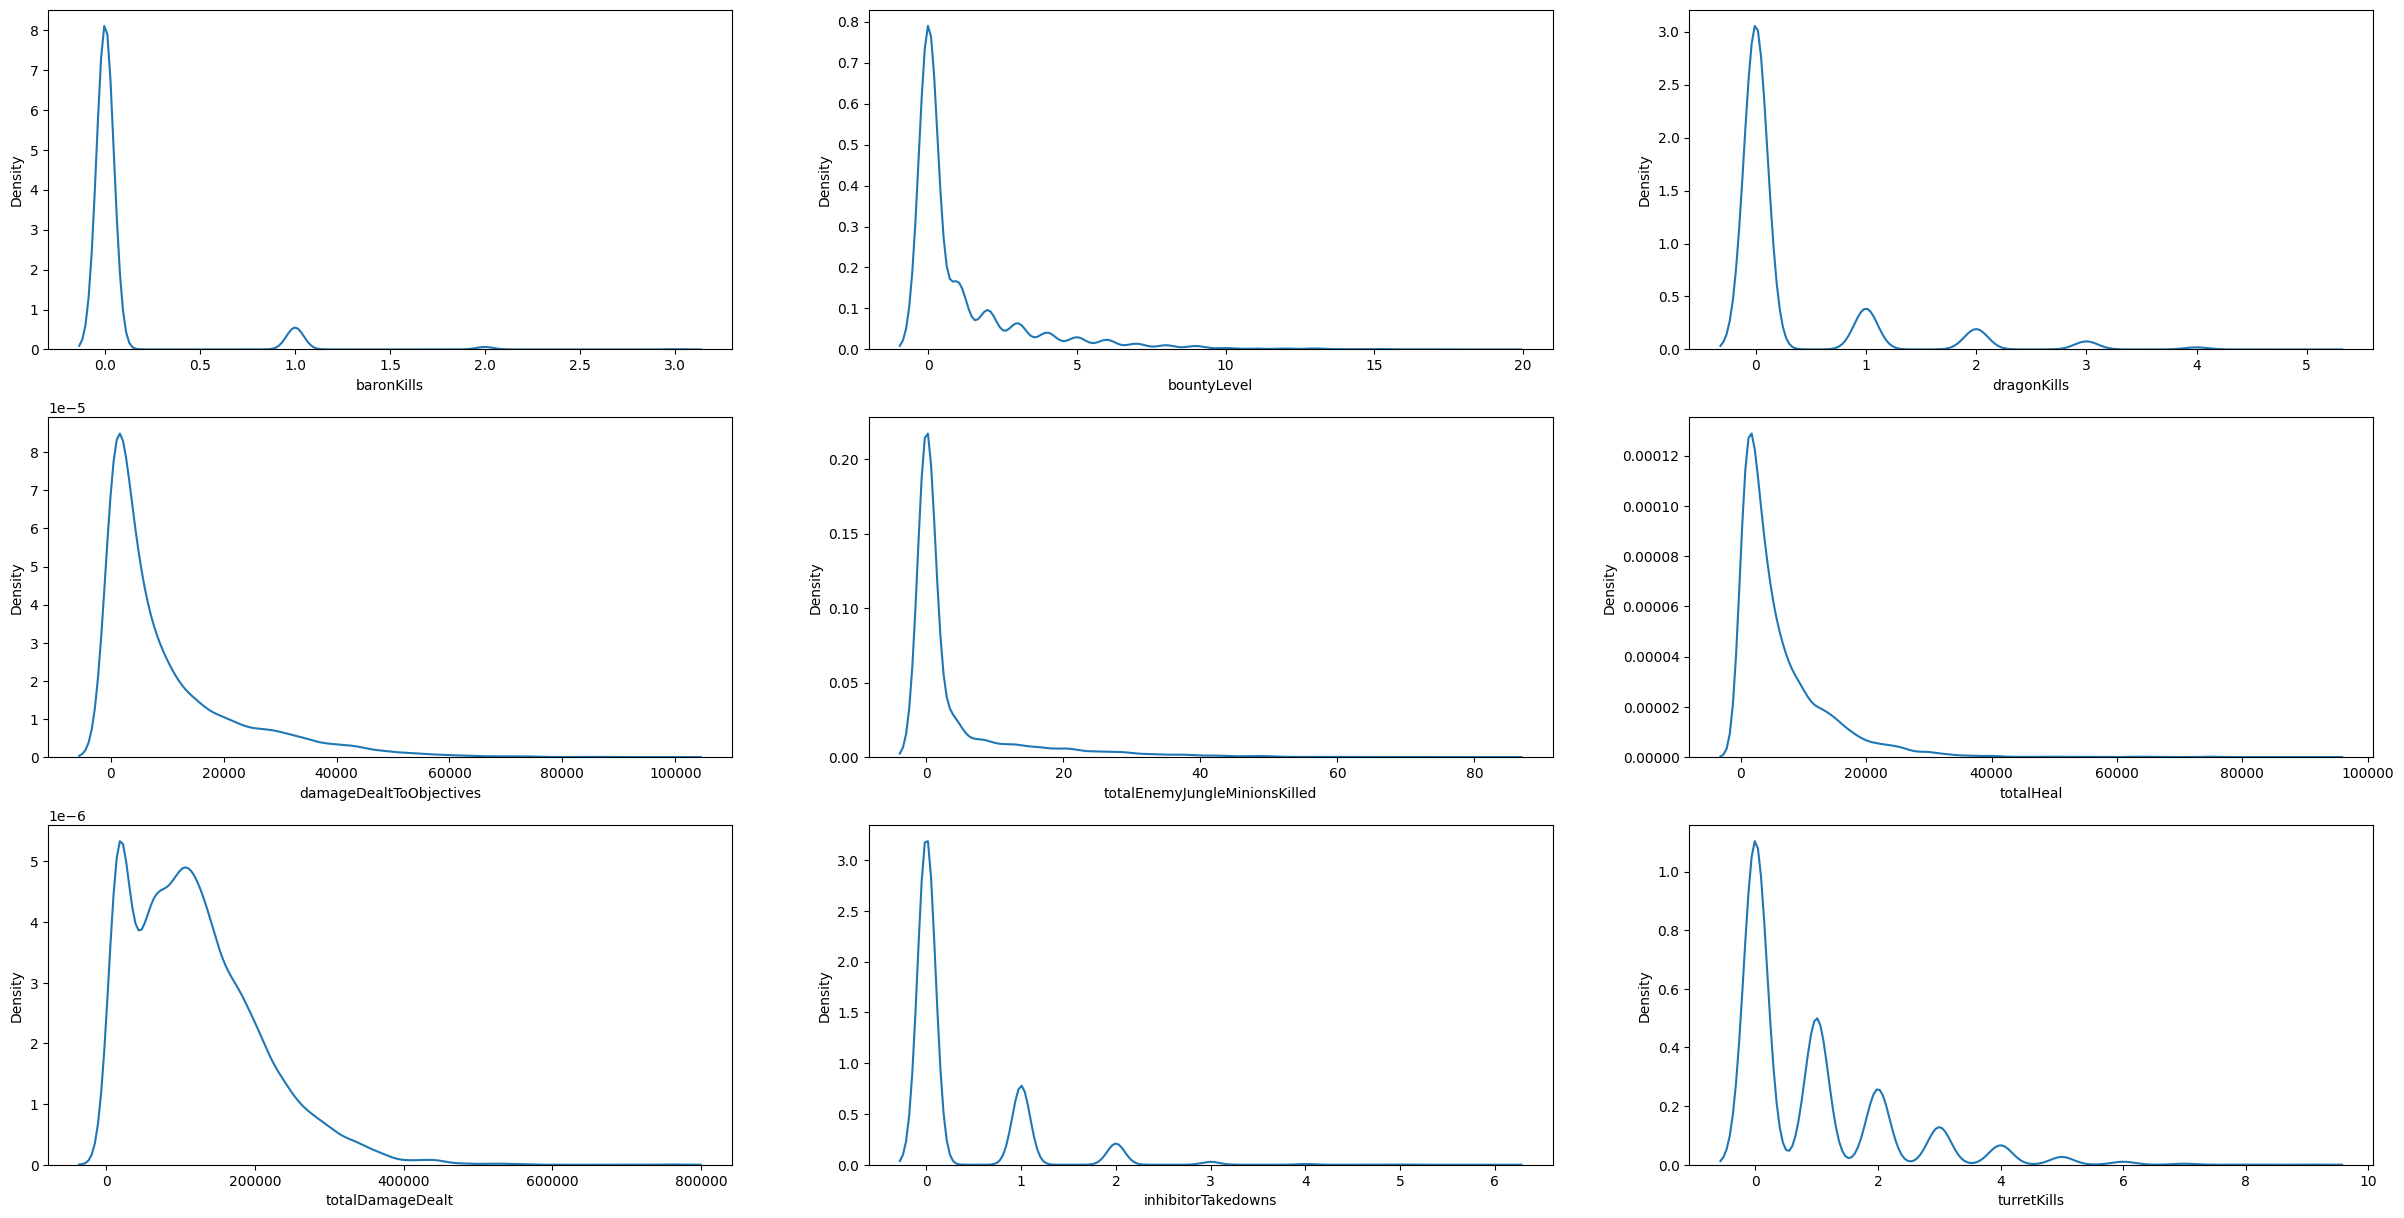

In [ ]:
# 왜도 시각화
# 매우 좌편향 되어있음을 알 수 있다.
fig, axs = plt.subplots(3, 3, figsize = (30, 15))

for xint in range(9):
    sns.kdeplot(x = df[unbal[xint]], data = df, ax = axs[xint//3,xint%3])

In [ ]:
# X와 y값을 지정한다.
X = df[['baronKills', 'bountyLevel', 'champLevel', 'damageDealtToObjectives',
       'dragonKills', 'firstTowerKill', 'goldEarned',
       'inhibitorTakedowns', 'killingSprees',
       'totalDamageDealt', 'totalEnemyJungleMinionsKilled', 'totalHeal',
       'totalTimeSpentDead', 'turretKills']]
y = df['win']

In [ ]:
# Train_test_split을 통해 데이터를 나눠준다. 훈련 데이터 세트에는 70%의 데이터를,
# 테스트 데이터에는 30%의 데이터로 나눠준다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)
X_train.shape

(8736, 14)

In [ ]:
# 데이터의 분포를 히스토그램을 통해 확인한 결과 전체적으로 스케일링이 필요한것 같다.
# 따라서 분류모델에 적합한 standard scaler를 적용한다.
# 스케일링 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 스케일된 데이터에 컬럼명 다시 부여
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns,
                             index=X_test.index)

In [ ]:
# 피처 중요도 시각화 함수
# Function to Plot Feature Importance
def feature_importance_func(importance, name, model_type):

  # Create Arrays from Feature Importance and Names
  feature_importance = np.array(importance)
  feature_names = np.array(name)

  # Create Dataframe using a Dictionary
  data = {'feature_names': feature_names, 'feature_importance': feature_importance}
  fi_df = pd.DataFrame(data)

  # Sort in Descending Order of Feature Importance
  fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)

  # Set Figure Size
  plt.figure(figsize = (6, 4))

  # Plot Bar Chart
  sns.set(style = "whitegrid")
  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")

  # Add Labels
  plt.title(model_type + ' FEATURE IMPORTANCE', fontsize = 10)
  plt.xlabel('FEATURE IMPORTANCE', fontsize = 7)
  plt.ylabel('FEATURE NAMES', fontsize = 7)

### **Machine Learning Model**


#### 로지스틱 회귀

승리 또는 패배인 이진 분류 문제이므로 가장 기본적 모델인 로지스틱 회귀 모델을 통해 승리 예측을 해보기로 결정하였다. 모델 해석이 용이하기 때문에 후에 적용할 다른 모델들에 대해서도 도움이 될것이라 생각해 먼저 해보기로 하였다.

In [ ]:
# 로지스틱 회귀 모델 생성 및 학습
# Max_iteration은 1000, random_state은 42로 고정시켰다.
lr_m = LogisticRegression(max_iter=1000, random_state=42)
lr_m.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# 로지스틱 회귀 모델로 예측
y_pred = lr_m.predict(X_test_scaled)

In [ ]:
# Feature Importance 확인
coefficients = lr_m.coef_[0]
feature_importance = pd.DataFrame({"Feature": X_train_scaled.columns,
                                   "Coefficient": coefficients})

# 계수를 바탕으로 중요도를 테이블로 출력해본다.
feature_importance.sort_values(by="Coefficient", ascending=False, inplace=True)
feature_importance

Feature  Coefficient
1                     bountyLevel     2.946918
7              inhibitorTakedowns     1.227079
3         damageDealtToObjectives     1.029059
2                      champLevel     0.949523
6                      goldEarned     0.756716
13                    turretKills     0.436060
10  totalEnemyJungleMinionsKilled     0.390707
4                     dragonKills     0.184472
0                      baronKills     0.138981
5                  firstTowerKill     0.051478
8                   killingSprees     0.036275
11                      totalHeal    -0.168198
12             totalTimeSpentDead    -1.083318
9                totalDamageDealt    -2.313681

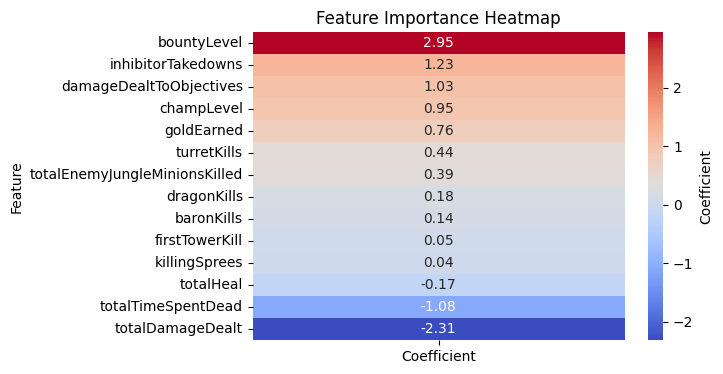

In [ ]:
# Coefficient들을 시각화해본다.
plt.figure(figsize=(6, 4))
sns.heatmap(feature_importance.set_index('Feature'), cmap='coolwarm',
            annot=True, fmt=".2f", cbar_kws={'label': 'Coefficient'})
plt.title('Feature Importance Heatmap')
plt.show()

In [ ]:
# Confusion Matrix를 그려 확인해본다.
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1656  163]
 [ 350 1575]]


##### **Confusion Matrix(혼동 행렬 지표)**

다음 형식의 혼동 행렬이 주어진 경우:

|               | 예측된 부정 | 예측된 긍정 |
|---------------|-----------|-----------|
| 실제 부정       | TN (진짜 부정) | FP (거짓 긍정) |
| 실제 긍정       | FN (거짓 부정) | TP (진짜 긍정) |



1. **정확도(Accuracy)**: 모델의 전체 정확성을 측정.

   $ \text{정확도} = \frac{TP + TN}{TP + TN + FP + FN} $

2. **정밀도(Precision)**: 긍정 예측(True Positive)의 정확성을 측정.
   
   $ \text{정밀도} = \frac{TP}{TP + FP} $

3. **재현율(Recall)**: "민감도" 또는 "진짜 긍정 비율(True Positive Rate, TPR)"이라고도 하며, 모델이 모든 관련 사례(실제 긍정)를 찾는 능력을 측정.
   
   $ \text{재현율} = \frac{TP}{TP + FN} $

4. **F1-스코어(F1-Score)**: 정밀도와 재현율의 조화 평균이며 거짓 긍정과 거짓 부정을 모두 고려할 필요가 있을 때 유용한 지표.
   
   $ \text{F1-스코어} = 2 \times \frac{\text{정밀도} \times \text{재현율}}{\text{정밀도} + \text{재현율}} $

In [ ]:
# Classification report를 통해 모든 지표를 한눈에 비교해본다.
performance = classification_report(y_test, y_pred)
print("Classification Report:\n", performance)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1819
           1       0.91      0.82      0.86      1925

    accuracy                           0.86      3744
   macro avg       0.87      0.86      0.86      3744
weighted avg       0.87      0.86      0.86      3744



- 정확도는 87%, f1-score는 패배의 경우 87%, 승리의 경우 86%를 기록했다. 이는 모델의 성능이 합리적이라고 평가된다.

In [ ]:
# Logistic Regression Model의 Summary를 확인한다.
# 여기서 예측의 시작점을 설정하기 위해 상수 항을 추가한다
X_train_sm = sm.add_constant(X_train_scaled)  # 상수항 추가
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
summary = result.summary()

print("\nModel Summary:\n", summary)

Optimization terminated successfully.
         Current function value: 0.326618
         Iterations 9

Model Summary:
                            Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 8736
Model:                          Logit   Df Residuals:                     8721
Method:                           MLE   Df Model:                           14
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.5287
Time:                        05:49:52   Log-Likelihood:                -2853.3
converged:                       True   LL-Null:                       -6054.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.1222      0.060  

#### 주요 결과
- Pseudo R-squared: 0.5287. 데이터의 변동성의 절반 이상을 설명하는 것으로 보인다.
- LLR p-value: 0.000이라는 것은 모델이 통계적으로 매우 유의미하다라고 보여진다.

**유의미한 변수들**:

- bountyLevel, champLevel, damageDealtToObjectives, inhibitorTakedowns, totalDamageDealt, totalEnemyJungleMinionsKilled, totalTimeSpentDead, turretKills는 P값이 매우 낮다 (P < 0.01). 이는 승리 예측에 있어 매우 유의미한 요인으로 분석된다.
- 특히, **bountyLevel**의 Coefficient는 2.9945으로, 이 변수가 증가할 때 승리 확률이 크게 증가함을 나타낸다.
- 반대로 **totalDamageDealt**는 Coefficient가 -2.3519로, 이는 총 피해량이 높을수록 오히려 승리 확률이 감소한다는 것으로 보여진다.
- 하지만 변수간 어쩔 수 없이 **다중공산성(Multicolinearity)**이 존재한다. 따라서 이로인해 모델의 Coefficient들은 믿을 수 없다.

유의미하지 않은 변수들:
firstTowerKill과 killingSprees는 P-값이 각각 0.199, 0.548으로, 통계적으로 유의미하지 않다. (P > 0.05)

#### Random Forest

다음으로 피처 중요도(Feature Importance)를 측정하기 위해 랜덤 포레스트 모델을 사용한다. 각 피처가 최종 승리 예측에 기여하는 정도를 측정할 수 있고, 여러 개별 결정 트리를 통해 매치 데이터 변수간의 비선형 관계를 잘 포착하기 때문에 선정하였다.

In [ ]:
# 랜덤포레스트를 적용하여 피처 중요도를 계산한다. 트리의 개수는 200개, random_state은 42로 고정한다.
r_m = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
# 예측을 해본다.
r_m.fit(X_train_scaled, y_train)
preds = r_m.predict(X_test_scaled)

print(r_m.score(X_train_scaled, y_train))
print(r_m.score(X_test_scaled, y_test))
print("OOB Score:", r_m.oob_score_)

1.0
0.8998397435897436
OOB Score: 0.9005265567765568


In [ ]:
# 피처 중요도 출력
r_m.feature_importances_

array([0.00617293, 0.22252851, 0.04077037, 0.09262836, 0.00939219,
       0.00377754, 0.08350204, 0.13970544, 0.02781914, 0.09057515,
       0.01865602, 0.06097238, 0.1553779 , 0.04812201])

<ipython-input-47-bb681443d6ac>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")


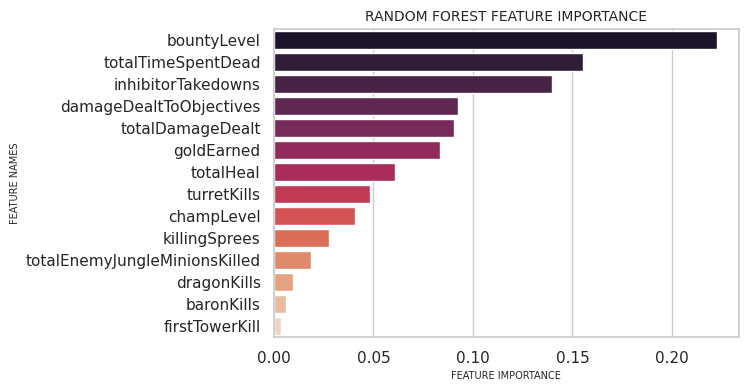

In [ ]:
# 피처 중요도 시각화
feature_importance_func(r_m.feature_importances_, X_train.columns, 'RANDOM FOREST')

In [ ]:
# 성능 지표 계산
accuracy = accuracy_score(y_test, preds).round(2)
precision = precision_score(y_test, preds, average='macro').round(2)
recall = recall_score(y_test, preds, average='macro').round(2)
f1 = f1_score(y_test, preds, average='macro').round(2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9


#### 주요 결과:

- OOB (Out-of-Bag) 점수가 0.9로 나왔다. 이는 90%의 정확도를 보이는 것으로 측정되며 성능이 좋은 것으로 판단된다.
- Accuracy, Precision, Recall, F1 Score 모두 90%로 측정 되었다. 이는 이전에 봤던 로지스틱 회귀 모델보다 승리 예측에 더 적합한 모델로 확인된다.
- 중요한 Feature들로 **bountyLevel, totalTimeSpentDead, inhibitorTakedowns, damageDealtToObjectives, totalDamageDealt, goldEarned**가 도출되었고, 특히 **bountyLevel**이 가장 승리와 연관된 중요한 요인으로 도출되었다.

#### LGBM

Gradient Boosting 모델을 적용해 보기 위해 효율성이 좋은 Light Gradient Boosting Model(LGBM)을 사용했다. LGBM Model은 트리 기반의 앙상블 모델이면서 그라디언트 부스팅 모델을 더욱 발전시킨 히스토그램 그라디언트 부스팅 모델로, 일반 그라디언트 부스팅 모델에 비해 학습하는 시간이 적고 과적합에 민감한 반응을 보이며 10000건이 넘는 데이터세트도 예측을 잘할 것 같다고 생각하여 적용해보았다.

트리 200개를 기본으로 설정한 베이스 라인 모델을 활용해본다.

In [ ]:
# lgbm 베이스 라인 모델을 적용해본다.
lgbm = LGBMClassifier(n_estimators=200,random_state=0)
lgbm.fit(X_train_scaled,y_train)
y_pred = lgbm.predict(X_test_scaled)
print('LGBM Train Score: ',lgbm.score(X_train_scaled,y_train))
print('LGBM Test Score: ',lgbm.score(X_test_scaled,y_test))

[LightGBM] [Info] Number of positive: 4315, number of negative: 4421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493933 -> initscore=-0.024269
[LightGBM] [Info] Start training from score -0.024269
LGBM Train Score:  0.9773351648351648
LGBM Test Score:  0.8977029914529915


In [ ]:
# LGBM Confusion Matrix 계산
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1656  163]
 [ 220 1705]]


In [ ]:
# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred).round(2)
precision = precision_score(y_test, y_pred, average='macro').round(2)
recall = recall_score(y_test, y_pred, average='macro').round(2)
f1 = f1_score(y_test, y_pred, average='macro').round(2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9


Accuracy, Precision, Recall, F1 Score 전부 0.9로 준수한 성능을 보여준다.

In [ ]:
#GridSearchCV에 넣을 lgbm 하이퍼 파라미터 딕셔너리를 지정해본다
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.15, 0.2]
}

모델의 성능을 높이기 위해 GridSearch를 활용한다.

**GridSearchCV**는 모델의 가장 좋은 성능을 낼 수 있는 하이퍼 파라미터를 찾아주고, 모델의 교차검증을 하기 위한 패키지로 사용. 여기서 'num_leaves','max_depth','learning_rate'는 LGBM Model이 가진 하이퍼 파라미터.

**'num_leaves'**: 하나의 트리가 가질 수 있는 최대 리프(leaf) 수.

**'num_leaves'의 효과** : 값이 크면 모델이 복잡해져 과적합할 수 있으며, 값이 작으면 모델이 단순해져 과소적합(underfitting)할 수 있다. 데이터의 크기와 복잡성에 따라 적절한 값을 선택한다.

**'max_depth'**: 트리의 최대 깊이를 설정한다. 트리가 너무 깊으면 과적합할 수 있다.

**max_depth의 효과**: 깊이를 제한하면 과적합을 방지할 수 있다. 하지만 너무 작은 값을 설정하면 모델이 충분히 학습하지 못할 수 있다.

**'learning_rate'**: 학습률을 나타낸다.

**learning_rate의 효과**: 학습률의 설정에 따라서, 손실함수의 최저 손실 지점을 찾는 것이 달라진다.

In [ ]:
#GridSearchCV를 이용하여 lgbm 하이퍼 파라미터 인자에 파라미터 딕셔너리 넣어주기
lgbm = LGBMClassifier(n_estimators=200, random_state=42)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4315, number of negative: 4421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493933 -> initscore=-0.024269
[LightGBM] [Info] Start training from score -0.024269


GridSearchCV(cv=5, estimator=LGBMClassifier(n_estimators=200, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [5, 10, 15], 'num_leaves': [31, 50, 70]},
             scoring='f1')

LGBM Model을 객체 'GridSearchCV에 넣어 할당한다. 이때, 교차 검증 횟수인 cv는 5로 설정하여 5번 교차 검증을 하도록 설정한다. 그리고 grid_search.fit을 이용하여 학습시킨다.

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation f1-score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 31}
Best cross-validation f1-score: 0.894


그 결과, GridSearchCV를 통해 가장 좋게 나타난 하이퍼 파라미터는 'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 31과 같고, F1-Score은 0.894점으로 나타났다

In [ ]:
#best f1_macro 수치와 best parameter확인
print("best f1_macro : {0: .3f}".format(grid_search.best_score_))
print("best param : ",grid_search.best_params_)

#dataframe으로 랭킹순보기
result_df = pd.DataFrame(grid_search.cv_results_)
result_df.sort_values(by=['rank_test_score'],inplace=True)

#plot
result_df[['params','mean_test_score','rank_test_score']].head(10)

best f1_macro :  0.894
best param :  {'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 31}


params  mean_test_score  \
6   {'learning_rate': 0.1, 'max_depth': 15, 'num_l...         0.893611   
8   {'learning_rate': 0.1, 'max_depth': 15, 'num_l...         0.893335   
5   {'learning_rate': 0.1, 'max_depth': 10, 'num_l...         0.893288   
4   {'learning_rate': 0.1, 'max_depth': 10, 'num_l...         0.893225   
21  {'learning_rate': 0.2, 'max_depth': 10, 'num_l...         0.892555   
7   {'learning_rate': 0.1, 'max_depth': 15, 'num_l...         0.892530   
16  {'learning_rate': 0.15, 'max_depth': 15, 'num_...         0.892524   
13  {'learning_rate': 0.15, 'max_depth': 10, 'num_...         0.892468   
14  {'learning_rate': 0.15, 'max_depth': 10, 'num_...         0.892439   
24  {'learning_rate': 0.2, 'max_depth': 15, 'num_l...         0.892413   

    rank_test_score  
6                 1  
8                 2  
5                 3  
4                 4  
21                5  
7                 6  
16                7  
13                8  
14                9  
24               10

위의 데이터 프레임은 하이퍼 파라미터를 몇으로 설정할 때, test_score가 얼마정도 나타나는 지를 보여주며, 성능이 좋은 순서대로 10개를 나열하여 보여준다.

In [ ]:
lgbm.feature_importances_

array([  59,  183,  380,  973,   68,   16,  885,  139,  167, 1078,  201,
        793,  933,  125], dtype=int32)

<ipython-input-47-bb681443d6ac>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")


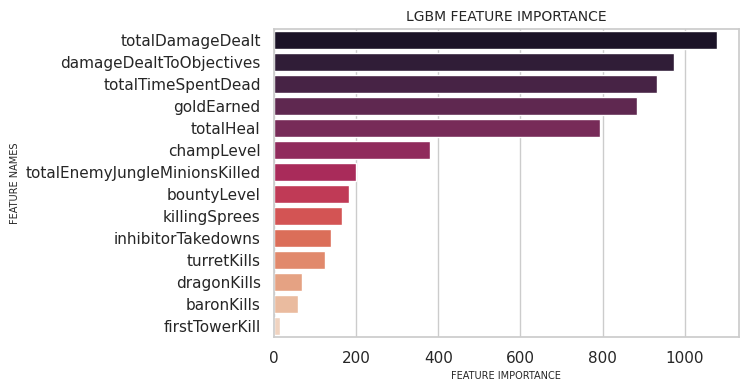

In [ ]:
feature_importance_func(lgbm.feature_importances_, X_train_scaled.columns, 'LGBM')

#### 주요 결과:

- GridSearchCV를 적용한 LGBM 모델의 accuracy, 0.897점, f1 score은 0.894점으로 비교적 안정적인 성능을 내는 모델로 판단된다.
- 다만, GridSearchCV를 적용한 LGBM 모델보다 베이스라인 모델이 0.9로 더 좋은 성능이 나왔으므로, 베이스라인 모델을 선택한다.

- lgbm 모델에서는 **totalDamageDealt**가 가장 승리에 영향을 많이 끼치는 주요 요인으로 평가되었으며, 차례로 **damageDeatToObjectives**, **totalTimeSpentDead, goldEarned, totalHeal**이 중요한 요인으로 평가된다.

#### 실제 데이터 모델 테스트

LGBM과 Random Forest의 성능은 둘다 90% 정도로 비슷한 성능을 보였다. 이에 실제 데이터에 대한 모델링을 통해 어떤 모델이 더 좋은 성능을 보이는지 테스트해본다.

In [ ]:
# 테스트 데이터셋을 가져온다 (챌린저와 마스터가 둘다 들어가 있을 수 있는 그랜드 마스터큐의 데이터를 새로 긁어왔다.)
test_df = pd.read_csv('Data/test_data.csv')
test_df

baronKills  bountyLevel  champExperience  champLevel  championId  \
0              0            0             9726          12         164   
1              0            0             9111          12          28   
2              0            1            10367          13          91   
3              0            0            10981          13         145   
4              0            0             7348          11         555   
...          ...          ...              ...         ...         ...   
4555           0            1            12848          14          72   
4556           1            2            14605          15         163   
4557           0            1            13872          15         234   
4558           0            6            11854          14         221   
4559           0            1             9192          12          12   

     championName  championTransform  consumablesPurchased  \
0         Camille                  0                     1   
1         Evelynn                  0                     6   
2           Talon                  0                     2   
3           Kaisa                  0                     3   
4            Pyke                  0                     7   
...           ...                ...                   ...   
4555      Skarner                  0                     8   
4556      Taliyah                  0                     8   
4557        Viego                  0                     6   
4558         Zeri                  0                     1   
4559      Alistar                  0                    11   

      damageDealtToBuildings  damageDealtToObjectives  ...  \
0                          0                      828  ...   
1                          0                    24666  ...   
2                       3634                     8508  ...   
3                       1817                     2629  ...   
4                       1061                     1620  ...   
...                      ...                      ...  ...   
4555                    3191                    10856  ...   
4556                    1223                    36389  ...   
4557                    5472                     5738  ...   
4558                   13253                    19203  ...   
4559                    1199                     2394  ...   

      visionWardsBoughtInGame  wardsKilled  wardsPlaced  win  totalPing  \
0                           0            2            7    0         13   
1                           5            0           11    0        117   
2                           1            4            6    0          3   
3                           2            2            6    0         44   
4                           5           13           50    0         48   
...                       ...          ...          ...  ...        ...   
4555                        6            1           12    1         33   
4556                        7            9            7    1         74   
4557                        7            8            6    1         64   
4558                        0           17            8    1         89   
4559                        8            7           35    1         17   

      teamPosition_BOTTOM  teamPosition_JUNGLE  teamPosition_MIDDLE  \
0                       0                    0                    0   
1                       0                    1                    0   
2                       0                    0                    1   
3                       1                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
4555                    0                    0                    0   
4556                    0                    1                    0   
4557                    0                    0                    1   
4558            

In [ ]:
# 아까와 같이 관련있는 컬럼들로 필터링해준다.
column_to_filter = ['baronKills', 'bountyLevel', 'champLevel',
                    'damageDealtToObjectives', 'dragonKills', 'firstTowerKill',
                    'goldEarned', 'inhibitorTakedowns', 'killingSprees',
                    'totalDamageDealt', 'totalEnemyJungleMinionsKilled',
                    'totalHeal', 'totalTimeSpentDead', 'turretKills', 'win']

In [ ]:
test_df = test_df[column_to_filter]

In [ ]:
# X와 y값을 지정한다.
X = test_df[['baronKills', 'bountyLevel', 'champLevel', 'damageDealtToObjectives',
       'dragonKills', 'firstTowerKill', 'goldEarned',
       'inhibitorTakedowns', 'killingSprees',
       'totalDamageDealt', 'totalEnemyJungleMinionsKilled', 'totalHeal',
       'totalTimeSpentDead', 'turretKills']]
y = test_df['win']

In [ ]:
# 아까 스케일링을 했던 것처럼, 스케일링을 다시 해준다.
# 스케일링 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X)

# 스케일된 데이터에 컬럼명 다시 부여
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X.index)

In [ ]:
# 랜덤포레스트 모델로 예측을 해본다.
preds = r_m.predict(X_test_scaled)
print("Score:", r_m.score(X_test_scaled, y))
print("OOB Score:", r_m.oob_score_)

Score: 0.8820175438596491
OOB Score: 0.9005265567765568


In [ ]:
# 피처 중요도 출력
r_m.feature_importances_

array([0.00617293, 0.22252851, 0.04077037, 0.09262836, 0.00939219,
       0.00377754, 0.08350204, 0.13970544, 0.02781914, 0.09057515,
       0.01865602, 0.06097238, 0.1553779 , 0.04812201])

<ipython-input-47-bb681443d6ac>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")


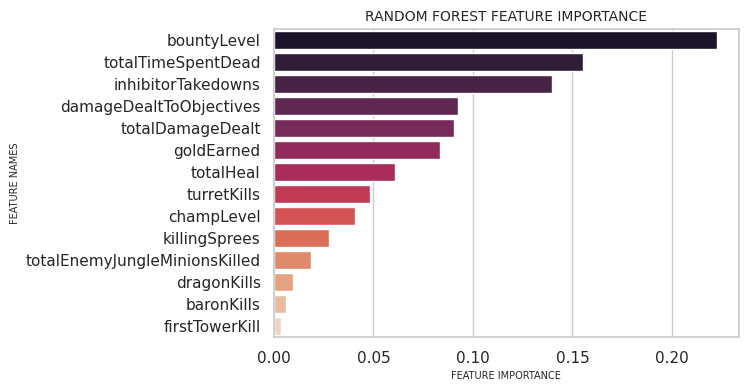

In [ ]:
# 피처 중요도 시각화
feature_importance_func(r_m.feature_importances_, X_test_scaled.columns, 'RANDOM FOREST')

In [ ]:
# 성능 지표 계산
accuracy = accuracy_score(y, preds).round(2)
precision = precision_score(y, preds, average='macro').round(2)
recall = recall_score(y, preds, average='macro').round(2)
f1 = f1_score(y, preds, average='macro').round(2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


In [ ]:
# 이번엔 lgbm을 적용하여 실제 데이터를 테스트해본다.
y_pred = lgbm.predict(X_test_scaled)
print('LGBM Test Score: ',lgbm.score(X_test_scaled, y))

LGBM Test Score:  0.8809210526315789


In [ ]:
# LGBM Confusion Matrix 계산
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2043  237]
 [ 306 1974]]


In [ ]:
# 성능 지표 계산
accuracy = accuracy_score(y, y_pred).round(2)
precision = precision_score(y, y_pred, average='macro').round(2)
recall = recall_score(y, y_pred, average='macro').round(2)
f1 = f1_score(y, y_pred, average='macro').round(2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


<ipython-input-47-bb681443d6ac>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'], palette = "rocket")


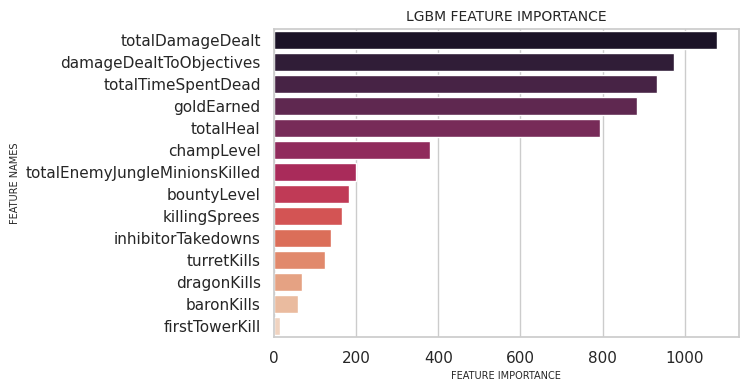

In [ ]:
# 피처 중요도 시각화
feature_importance_func(lgbm.feature_importances_,
                        X_test_scaled.columns, 'LGBM')

In [ ]:
# 성능 지표 계산
accuracy = accuracy_score(y, y_pred).round(2)
precision = precision_score(y, y_pred, average='macro').round(2)
recall = recall_score(y, y_pred, average='macro').round(2)
f1 = f1_score(y, y_pred, average='macro').round(2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


#### **결론**

- Random Forest와 Light Gradient Boosting Model 둘다 0.88 정도로 비슷한 점수를 기록하고 있다(f1-score).
- 다만, 둘의 피처 중요도 순위가 다르다.
  - 랜덤포레스트의 순위:
    1. bountyLevel
    2. totalTimeSpentDead
    3. inhibitorTakedowns
    4. damageDealtToObjectives
    5. totalDamageDealt
    6. goldEarned
  - LGBM의 순위:
    1. totalDamageDealt
    2. damageDealtToObjectives
    3. totalTimeSpentDead
    4. goldEarned
    5. totalHeal
    6. champLevel
- 이를 통해 추론할 수 있는 것은, 둘이 중요하게 여기는 요인이 승리 예측에 있어서 실제로 중요할 가능성이 높을 수 있다. 따라서, **totalTimeSpentDead, damageDealtToObjectives, totalDamageDealt, goldEarned**와 같은 요인들은 실제 승리 예측에 있어서 중요할 가능성이 크고, **bountyLevel, champLevel, totalHeal** 같은 요인들은 민감하게 반응하는 변수일 수도 있다.

#### **중요한 feature들 시각화**

랜덤포레스트와 LGBM에서 나온 중요한 Feature들을 Barplot을 통해 실제로도 승리쪽에 더 치우쳐져 있는지 확인해본다.

In [ ]:
# 먼저 seaborn의 style을 지정해준다.
sns.set(style="whitegrid")

# bar chart에 사용할 변수들을 지정한다.
variables = [
    'bountyLevel',
    'totalTimeSpentDead',
    'inhibitorTakedowns',
    'damageDealtToObjectives',
    'totalDamageDealt',
    'goldEarned',
    'champLevel',
    'totalHeal'
]

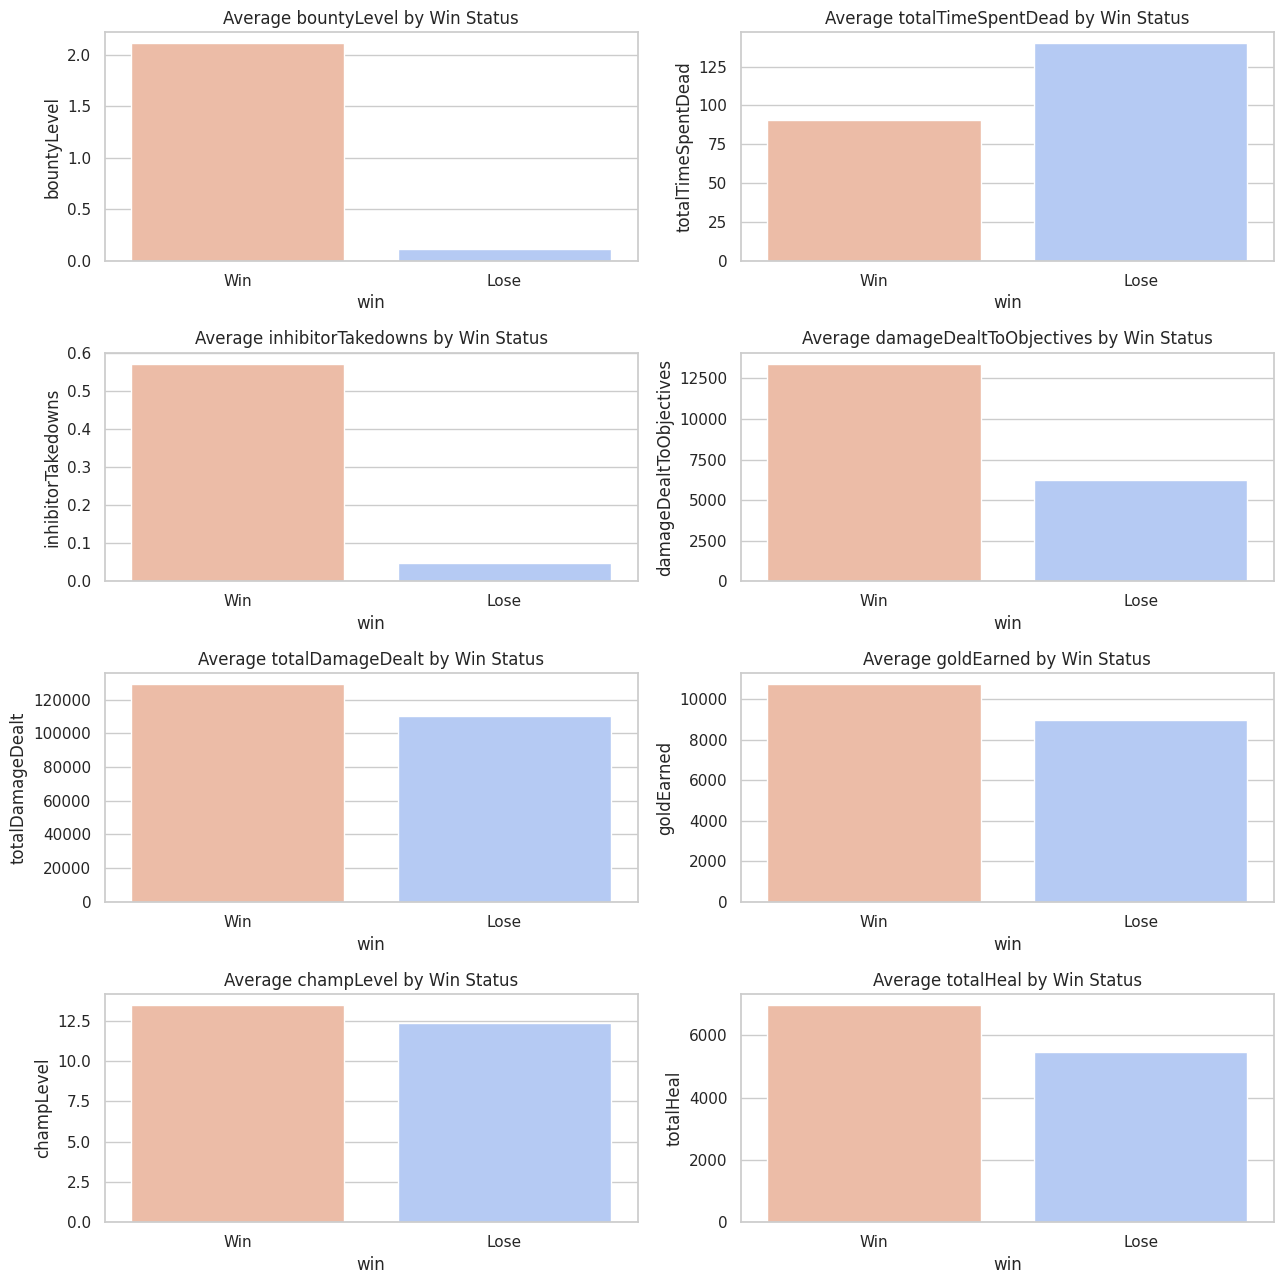

In [ ]:
# 요인들을 시각화 해본다.
# Create a figure to hold the subplots
plt.figure(figsize=(13, 13))

# Loop through the variables list and create a subplot for each
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.barplot(x=df['win'].map({0: 'Lose', 1: 'Win'}), y=var, data=df,
                                errorbar=None, palette='coolwarm',
                                hue='win', legend=False)
    plt.title(f'Average {var} by Win Status')

# Adjust layout
plt.tight_layout()
plt.show()

**결론**

- 피처들을 보면 대부분 승리 예측 모델들의 결과와 맞아 떨어진다.
- 즉, 모델링뿐만이 아닌 실제 데이터로 비교해봐도 연관 있는 데이터라고 추측된다.